# THORChain Data Combiner & Analyzer

This notebook combines multiple THORChain CSV files, cleans the data, removes duplicates, and prepares it for analysis.

**Analysis Goals:**
- Average swap size
- Percentage basis points (bps) paid
- Assets swapped by day of week
- Trending assets week-to-week
- Trending assets month-to-month


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Try to import dateutil for advanced date parsing (optional)
try:
    from dateutil import parser as date_parser
    HAS_DATEUTIL = True
except ImportError:
    HAS_DATEUTIL = False
    print("Note: dateutil not available, using basic date parsing")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Locate and Load All CSV and JSON Files

Find all `viewblock_thorchain*` files (both CSV and JSON) in the Downloads directory and load them into a list of dataframes.



In [14]:
# Set the directory containing data files - use defi-analysis-repo/data subfolder
data_directory = Path.home() / "defi-analysis-repo" / "data"

# Find all CSV and JSON files matching the pattern (only files starting with "viewblock_thorchain_data")
csv_files = sorted(glob.glob(str(data_directory / "viewblock_thorchain_data*.csv")))
json_files = sorted(glob.glob(str(data_directory / "viewblock_thorchain_data*.json")))

# Also check subdirectories recursively
csv_files.extend(sorted(glob.glob(str(data_directory / "**/viewblock_thorchain_data*.csv"), recursive=True)))
json_files.extend(sorted(glob.glob(str(data_directory / "**/viewblock_thorchain_data*.json"), recursive=True)))

# Remove duplicates (in case files are found multiple times)
csv_files = sorted(list(set(csv_files)))
json_files = sorted(list(set(json_files)))

# Sort files by modification time (newest first) to prioritize newer data
def get_file_mtime(file_path):
    """Get file modification time for sorting"""
    try:
        return Path(file_path).stat().st_mtime
    except:
        return 0

# Sort by modification time, newest first
all_files = csv_files + json_files
all_files = sorted(all_files, key=get_file_mtime, reverse=True)

print(f"Files sorted by modification time (newest first):")
for f in all_files[:10]:  # Show first 10
    mtime = datetime.fromtimestamp(get_file_mtime(f))
    print(f"  {Path(f).name} - Modified: {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
if len(all_files) > 10:
    print(f"  ... and {len(all_files) - 10} more files")

print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files:")
for f in csv_files:
    print(f"  CSV: {Path(f).name}")
for f in json_files:
    print(f"  JSON: {Path(f).name}")

# Load each file into a list of dataframes
dataframes = []
import json

for file_path in all_files:
    try:
        file_ext = Path(file_path).suffix.lower()
        
        if file_ext == '.csv':
            df = pd.read_csv(file_path)
        elif file_ext == '.json':
            # Load JSON file - handle both list of dicts and dict formats
            with open(file_path, 'r') as f:
                json_data = json.load(f)
            
            # If it's a list, convert to dataframe directly
            if isinstance(json_data, list):
                df = pd.json_normalize(json_data)
            # If it's a dict, try to find the data array
            elif isinstance(json_data, dict):
                # Look for common keys that might contain the data array
                if 'data' in json_data:
                    df = pd.json_normalize(json_data['data'])
                elif 'results' in json_data:
                    df = pd.json_normalize(json_data['results'])
                else:
                    # Convert single dict to dataframe
                    df = pd.DataFrame([json_data])
            else:
                print(f"⚠ Skipping {Path(file_path).name}: Unsupported JSON format")
                continue
        else:
            print(f"⚠ Skipping {Path(file_path).name}: Unknown file type")
            continue
        
        df['source_file'] = Path(file_path).name  # Track which file each row came from
        dataframes.append(df)
        print(f"✓ Loaded {len(df)} rows from {Path(file_path).name} ({file_ext})")
    except Exception as e:
        print(f"✗ Error loading {Path(file_path).name}: {e}")

print(f"\nTotal dataframes loaded: {len(dataframes)}")


Files sorted by modification time (newest first):
  viewblock_thorchain_data_2025-12-16T08-02-02-614Z.json - Modified: 2025-12-16 15:02:02
  viewblock_thorchain_data_2025-12-08T16-01-01-030Z.json - Modified: 2025-12-11 19:12:37
  viewblock_thorchain_data_2025-12-10T02-33-05-323Z.json - Modified: 2025-12-10 09:33:05
  viewblock_thorchain_data_2025-12-02T07-55-15-668Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-12-02T07-55-08-082Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-12-02T07-18-49-988Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-11-24T07-22-51-109Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-11-17T16-54-47-513Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-11-03T17-55-33-095Z.json - Modified: 2025-12-08 22:08:16
  viewblock_thorchain_data_2025-11-03T17-55-16-849Z.json - Modified: 2025-12-08 22:08:16
  ... and 22 more files
Found 3 CSV files and 29 JSON files:

## Step 2.5: Check Data Quality Before Combining

Quick check to see data quality across different source files.


In [15]:
# Quick diagnostic: Check data quality per source file
print("=== DATA QUALITY CHECK BY SOURCE FILE ===\n")
for i, df in enumerate(dataframes):
    source = df['source_file'].iloc[0] if 'source_file' in df.columns else f"Dataframe {i}"
    print(f"\n{source}:")
    print(f"  Total rows: {len(df)}")
    
    # Check key columns
    key_cols = ['from_amount', 'to_amount', 'from_asset', 'to_asset', 'timestamp']
    for col in key_cols:
        if col in df.columns:
            non_null = df[col].notna().sum()
            pct = non_null / len(df) * 100 if len(df) > 0 else 0
            print(f"  {col}: {non_null}/{len(df)} ({pct:.1f}%)")
        else:
            print(f"  {col}: MISSING COLUMN")
    
    # Sample values to see format
    if 'from_amount' in df.columns and len(df) > 0:
        sample_val = df['from_amount'].iloc[0]
        print(f"  Sample from_amount: {repr(sample_val)} (type: {type(sample_val).__name__})")


=== DATA QUALITY CHECK BY SOURCE FILE ===


viewblock_thorchain_data_2025-12-16T08-02-02-614Z.json:
  Total rows: 575
  from_amount: 523/575 (91.0%)
  to_amount: 523/575 (91.0%)
  from_asset: 523/575 (91.0%)
  to_asset: 523/575 (91.0%)
  timestamp: 575/575 (100.0%)
  Sample from_amount: '0.0033684' (type: str)

viewblock_thorchain_data_2025-12-08T16-01-01-030Z.json:
  Total rows: 1800
  from_amount: 1521/1800 (84.5%)
  to_amount: 1521/1800 (84.5%)
  from_asset: 1521/1800 (84.5%)
  to_asset: 1521/1800 (84.5%)
  timestamp: 1775/1800 (98.6%)
  Sample from_amount: '0.03281505' (type: str)

viewblock_thorchain_data_2025-12-10T02-33-05-323Z.json:
  Total rows: 114
  from_amount: 113/114 (99.1%)
  to_amount: 113/114 (99.1%)
  from_asset: 113/114 (99.1%)
  to_asset: 113/114 (99.1%)
  timestamp: 114/114 (100.0%)
  Sample from_amount: None (type: NoneType)

viewblock_thorchain_data_2025-12-02T07-55-15-668Z.json:
  Total rows: 550
  from_amount: 492/550 (89.5%)
  to_amount: 492/550 (89.5%)
  from

## Step 2: Combine All Dataframes

Concatenate all loaded dataframes into a single dataframe.


In [16]:
# Combine all dataframes
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Total columns: {len(combined_df.columns)}")
    print(f"\nColumns: {list(combined_df.columns)}")
else:
    print("No dataframes to combine!")


Combined dataframe shape: (14433, 16)
Total rows: 14,433
Total columns: 16

Columns: ['affiliate_address', 'block_height', 'from_address', 'from_amount', 'from_asset', 'raw_row_text', 'status', 'timestamp', 'to_address', 'to_amount', 'to_asset', 'tx_hash', 'type', 'source_file', 'action', 'captured_at']


## Step 3: Remove Duplicates

Identify and remove duplicate rows based on transaction hash (tx_hash), which should be unique for each swap.




In [17]:
# Check for duplicates based on tx_hash
initial_count = len(combined_df)
print(f"Initial row count: {initial_count:,}")

# Count duplicates
duplicate_count = combined_df.duplicated(subset=['tx_hash'], keep=False).sum()
print(f"Rows with duplicate tx_hash: {duplicate_count:,}")

# Remove duplicates, keeping the FIRST occurrence (newer files loaded first)
# This prioritizes newer data over older data since files are sorted by modification time (newest first)
combined_df = combined_df.drop_duplicates(subset=['tx_hash'], keep='first')

final_count = len(combined_df)
removed_count = initial_count - final_count
print(f"\nRemoved {removed_count:,} duplicate rows")
print(f"Final row count: {final_count:,}")
print(f"Duplicate removal rate: {removed_count/initial_count*100:.2f}%")
print("\n✓ Kept newer entries when duplicates found (newer files have priority)")


Initial row count: 14,433
Rows with duplicate tx_hash: 13,947

Removed 11,681 duplicate rows
Final row count: 2,752
Duplicate removal rate: 80.93%

✓ Kept newer entries when duplicates found (newer files have priority)


## Step 4.5: Parse Missing Data from raw_row_text

Some entries have missing `from_amount`, `to_amount`, `from_asset`, or `to_asset` in the JSON, but the data exists in `raw_row_text`. Parse it to fill in missing values.



In [18]:
# Parse raw_row_text to extract missing from_amount, to_amount, from_asset, to_asset
# Pattern: \t\nSwap\n\t\n{from_amount}\n{from_asset}\n{to_amount}\n{to_asset}
# Pattern for Add: \t\nAdd\n\t\n{amount}\n{asset}\n{to_asset}

def parse_raw_row_text(row):
    """Parse raw_row_text to extract missing swap/transaction data"""
    # Create a copy to avoid issues with pandas
    row = row.copy()
    
    if 'raw_row_text' not in row.index or pd.isna(row.get('raw_row_text')):
        return row
    
    raw_text = str(row.get('raw_row_text', ''))
    
    # Check if we need to fill missing values
    needs_from_amount = pd.isna(row.get('from_amount')) or str(row.get('from_amount', '')).strip() == ''
    needs_to_amount = pd.isna(row.get('to_amount')) or str(row.get('to_amount', '')).strip() == ''
    needs_from_asset = pd.isna(row.get('from_asset')) or str(row.get('from_asset', '')).strip() == ''
    needs_to_asset = pd.isna(row.get('to_asset')) or str(row.get('to_asset', '')).strip() == ''
    
    if not (needs_from_amount or needs_to_amount or needs_from_asset or needs_to_asset):
        return row  # Nothing to parse
    
    # Try to parse Swap pattern: \t\nSwap\n\t\n{from_amount}\n{from_asset}\n{to_amount}\n{to_asset}
    swap_pattern = r'\t\nSwap\n\t\n([^\n]+)\n([^\n]+)\n([^\n]+)\n([^\n]+)'
    swap_match = re.search(swap_pattern, raw_text)
    
    if swap_match:
        from_amount_str, from_asset_str, to_amount_str, to_asset_str = swap_match.groups()
        
        if needs_from_amount:
            row['from_amount'] = from_amount_str.strip()
        if needs_from_asset:
            row['from_asset'] = from_asset_str.strip()
        if needs_to_amount:
            row['to_amount'] = to_amount_str.strip()
        if needs_to_asset:
            row['to_asset'] = to_asset_str.strip()
        
        return row
    
    # Try to parse Add pattern: \t\nAdd\n\t\n{amount}\n{asset}\n{to_asset}
    add_pattern = r'\t\nAdd\n\t\n([^\n]+)\n([^\n]+)\n([^\n]+)'
    add_match = re.search(add_pattern, raw_text)
    
    if add_match:
        amount_str, asset_str, to_asset_str = add_match.groups()
        
        # For Add transactions, we might not have a clear from/to distinction
        # But we can try to fill what's missing
        if needs_from_amount:
            row['from_amount'] = amount_str.strip()
        if needs_from_asset:
            row['from_asset'] = asset_str.strip()
        if needs_to_asset:
            row['to_asset'] = to_asset_str.strip()
        # For Add transactions, set to_amount to 0 since it's a liquidity addition, not a swap
        if needs_to_amount:
            row['to_amount'] = '0'
        
        return row
    
    return row

# Apply parsing to rows with missing data
print("Parsing raw_row_text to fill missing values...")
missing_before = (
    combined_df['from_amount'].isna() | 
    combined_df['to_amount'].isna() | 
    combined_df['from_asset'].isna() | 
    combined_df['to_asset'].isna()
).sum()

# Apply parsing function row by row - use apply which returns a DataFrame
combined_df = combined_df.apply(parse_raw_row_text, axis=1)

missing_after = (
    combined_df['from_amount'].isna() | 
    combined_df['to_amount'].isna() | 
    combined_df['from_asset'].isna() | 
    combined_df['to_asset'].isna()
).sum()

filled_count = missing_before - missing_after
print(f"✓ Filled {filled_count} missing values from raw_row_text")
print(f"  Missing before: {missing_before}, Missing after: {missing_after}")

# Now re-apply cleaning functions since we may have added string values
# Clean numeric strings again (in case we parsed comma-separated numbers)
if 'from_amount' in combined_df.columns:
    combined_df['from_amount'] = combined_df['from_amount'].apply(clean_numeric_string)
    combined_df['from_amount'] = pd.to_numeric(combined_df['from_amount'], errors='coerce')

if 'to_amount' in combined_df.columns:
    combined_df['to_amount'] = combined_df['to_amount'].apply(clean_numeric_string)
    combined_df['to_amount'] = pd.to_numeric(combined_df['to_amount'], errors='coerce')

# Clean asset names again
if 'from_asset' in combined_df.columns:
    combined_df['from_asset'] = combined_df['from_asset'].apply(clean_asset_name)

if 'to_asset' in combined_df.columns:
    combined_df['to_asset'] = combined_df['to_asset'].apply(clean_asset_name)

# For Add transactions (liquidity additions), set to_amount to 0 if still missing
# Add transactions don't have a to_amount in the raw data since they're not swaps
if 'type' in combined_df.columns and 'to_amount' in combined_df.columns:
    add_mask = (combined_df['type'] == 'Add') & (combined_df['to_amount'].isna())
    add_count = add_mask.sum()
    if add_count > 0:
        combined_df.loc[add_mask, 'to_amount'] = 0
        print(f"✓ Set to_amount=0 for {add_count} Add transactions (liquidity additions)")

print(f"✓ Re-cleaned parsed values")
print(f"  Final missing from_amount: {combined_df['from_amount'].isna().sum()}")
print(f"  Final missing to_amount: {combined_df['to_amount'].isna().sum()}")
print(f"  Final missing from_asset: {combined_df['from_asset'].isna().sum()}")
print(f"  Final missing to_asset: {combined_df['to_asset'].isna().sum()}")



Parsing raw_row_text to fill missing values...
✓ Filled 279 missing values from raw_row_text
  Missing before: 280, Missing after: 1


NameError: name 'clean_numeric_string' is not defined

## Step 4: Clean and Standardize Data

Clean up the data for human readability:
- Convert timestamps to datetime
- Ensure numeric columns are properly typed
- Clean up asset names
- Calculate swap size and basis points




In [ ]:
# Convert timestamp to datetime
# Handle custom format: "Sep 18 2025 04:15:38 AM (GMT-7)"
if 'timestamp' in combined_df.columns:
    def parse_custom_timestamp(ts):
        """Parse custom timestamp format: 'Sep 18 2025 04:15:38 AM (GMT-7)'"""
        if pd.isna(ts) or ts == '' or str(ts).strip() == '':
            return pd.NaT
        
        ts_str = str(ts).strip()
        
        # Try standard pandas parsing first
        result = pd.to_datetime(ts_str, errors='coerce')
        if pd.notna(result):
            return result
        
        # Handle custom format: "Sep 18 2025 04:15:38 AM (GMT-7)"
        # Remove timezone info in parentheses
        ts_clean = re.sub(r'\s*\([^)]+\)\s*$', '', ts_str).strip()
        
        # Try with dateutil if available (more flexible)
        if HAS_DATEUTIL:
            try:
                return pd.to_datetime(date_parser.parse(ts_clean))
            except:
                pass
        
        # Fallback: try pandas with cleaned string
        result = pd.to_datetime(ts_clean, errors='coerce')
        if pd.notna(result):
            return result
        
        # Last resort: try to manually parse "Sep 18 2025 04:15:38 AM" format
        try:
            # Pattern: "Sep 18 2025 04:15:38 AM"
            match = re.match(r'(\w+)\s+(\d+)\s+(\d+)\s+(\d+):(\d+):(\d+)\s+(AM|PM)', ts_clean, re.IGNORECASE)
            if match:
                month_str, day, year, hour, minute, second, am_pm = match.groups()
                # Convert month abbreviation to number
                months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                         'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
                month = months.get(month_str.lower()[:3])
                if month:
                    # Convert 12-hour to 24-hour format
                    hour = int(hour)
                    if am_pm.upper() == 'PM' and hour != 12:
                        hour += 12
                    elif am_pm.upper() == 'AM' and hour == 12:
                        hour = 0
                    return pd.Timestamp(int(year), month, int(day), int(hour), int(minute), int(second))
        except:
            pass
        
        return pd.NaT
    
    # Apply custom parsing
    combined_df['timestamp'] = combined_df['timestamp'].apply(parse_custom_timestamp)
    
    # Count successful conversions
    successful = combined_df['timestamp'].notna().sum()
    total = len(combined_df)
    print(f"✓ Converted timestamp to datetime ({successful}/{total} successful, {successful/total*100:.1f}%)")

# Ensure numeric columns are properly typed
# Handle comma-separated numbers (common in JSON files)
def clean_numeric_string(val):
    """Clean numeric strings by removing commas and handling empty values"""
    if pd.isna(val) or val == '' or val is None:
        return None
    # Convert to string, remove commas, strip whitespace
    val_str = str(val).replace(',', '').strip()
    if val_str == '' or val_str.lower() in ['nan', 'none', 'null']:
        return None
    return val_str

numeric_columns = ['from_amount', 'to_amount', 'block_height']
for col in numeric_columns:
    if col in combined_df.columns:
        # First clean the strings (remove commas)
        combined_df[col] = combined_df[col].apply(clean_numeric_string)
        # Then convert to numeric
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        
        # Report conversion success
        non_null_before = combined_df[col].notna().sum()
        total = len(combined_df)
        print(f"✓ Converted {col} to numeric ({non_null_before}/{total} non-null, {non_null_before/total*100:.1f}%)")

# Clean asset names (remove extra whitespace, standardize)
# Handle empty strings and null values
def clean_asset_name(val):
    """Clean asset names"""
    if pd.isna(val) or val == '' or val is None:
        return None
    val_str = str(val).strip().upper()
    if val_str == '' or val_str.lower() in ['nan', 'none', 'null']:
        return None
    return val_str

if 'from_asset' in combined_df.columns:
    combined_df['from_asset'] = combined_df['from_asset'].apply(clean_asset_name)
    non_null_from = combined_df['from_asset'].notna().sum()
    print(f"✓ Cleaned from_asset ({non_null_from}/{len(combined_df)} non-null, {non_null_from/len(combined_df)*100:.1f}%)")

if 'to_asset' in combined_df.columns:
    combined_df['to_asset'] = combined_df['to_asset'].apply(clean_asset_name)
    non_null_to = combined_df['to_asset'].notna().sum()
    print(f"✓ Cleaned to_asset ({non_null_to}/{len(combined_df)} non-null, {non_null_to/len(combined_df)*100:.1f}%)")

# Display data types and basic info
print("\nData types:")
print(combined_df.dtypes)
print(f"\nDataframe info:")
print(combined_df.info())


✓ Converted timestamp to datetime (3099/3101 successful, 99.9%)
✓ Converted from_amount to numeric (3100/3101 non-null, 100.0%)
✓ Converted to_amount to numeric (3100/3101 non-null, 100.0%)
✓ Converted block_height to numeric (3099/3101 non-null, 99.9%)
✓ Cleaned from_asset (3100/3101 non-null, 100.0%)
✓ Cleaned to_asset (3097/3101 non-null, 99.9%)

Data types:
affiliate_address            object
block_height                float64
from_address                 object
from_amount                 float64
from_asset                   object
raw_row_text                 object
status                       object
timestamp            datetime64[ns]
to_address                   object
to_amount                   float64
to_asset                     object
tx_hash                      object
type                         object
source_file                  object
action                       object
captured_at                  object
dtype: object

Dataframe info:
<class 'pandas.core.frame.Dat

## Step 5: Calculate Derived Metrics

Calculate metrics needed for analysis:
- Swap size (using from_amount as the primary measure)
- Basis points paid (if affiliate_address is present, calculate fee percentage)
- Day of week
- Week number
- Month



## Step 6.5: Investigate Missing Data Entries

Find entries with missing `from_amount`, `to_amount`, `from_asset`, or `to_asset` and display their raw data for investigation.


In [ ]:
# Find rows with missing critical fields
missing_mask = (
    combined_df['from_amount'].isna() | 
    combined_df['to_amount'].isna() | 
    combined_df['from_asset'].isna() | 
    combined_df['to_asset'].isna()
)

missing_entries = combined_df[missing_mask].copy()

print(f"=== ENTRIES WITH MISSING DATA ===")
print(f"Total entries with missing from_amount/to_amount/from_asset/to_asset: {len(missing_entries)}\n")

# Show breakdown by missing field
print("Breakdown by missing field:")
print(f"  Missing from_amount: {(combined_df['from_amount'].isna()).sum()}")
print(f"  Missing to_amount: {(combined_df['to_amount'].isna()).sum()}")
print(f"  Missing from_asset: {(combined_df['from_asset'].isna()).sum()}")
print(f"  Missing to_asset: {(combined_df['to_asset'].isna()).sum()}")

# Create diagnostic table with key information
if len(missing_entries) > 0:
    diagnostic_cols = ['tx_hash', 'timestamp', 'source_file', 'from_amount', 'to_amount', 
                       'from_asset', 'to_asset', 'status', 'type', 'block_height']
    
    # Only include columns that exist
    available_cols = [col for col in diagnostic_cols if col in missing_entries.columns]
    diagnostic_df = missing_entries[available_cols].copy()
    
    # Add raw_row_text if available (truncated for readability)
    if 'raw_row_text' in missing_entries.columns:
        diagnostic_df['raw_row_text_preview'] = missing_entries['raw_row_text'].apply(
            lambda x: str(x)[:200] + '...' if pd.notna(x) and len(str(x)) > 200 else str(x) if pd.notna(x) else ''
        )
    
    print(f"\n=== DIAGNOSTIC TABLE: First 50 Missing Entries ===")
    print(diagnostic_df.head(50).to_string())
    
    # Group by source file to see which files have the most missing data
    print(f"\n=== MISSING DATA BY SOURCE FILE ===")
    missing_by_file = missing_entries.groupby('source_file').agg({
        'tx_hash': 'count',
        'from_amount': lambda x: x.isna().sum(),
        'to_amount': lambda x: x.isna().sum(),
        'from_asset': lambda x: x.isna().sum(),
        'to_asset': lambda x: x.isna().sum()
    }).rename(columns={'tx_hash': 'total_missing_rows'})
    missing_by_file = missing_by_file.sort_values('total_missing_rows', ascending=False)
    print(missing_by_file)
    
    # Save to CSV for detailed investigation
    diagnostic_output = Path.home() / "Downloads" / f"thorchain_missing_data_diagnostic_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    
    # Include all columns for full investigation
    missing_entries.to_csv(diagnostic_output, index=False)
    print(f"\n✓ Saved full diagnostic data to: {diagnostic_output}")
    print(f"  Total rows: {len(missing_entries)}")
    print(f"  File size: {diagnostic_output.stat().st_size / 1024:.2f} KB")
    
    # Show sample of raw_row_text for investigation
    print(f"\n=== SAMPLE RAW ROW TEXT (First 10 entries) ===")
    if 'raw_row_text' in missing_entries.columns:
        for idx, row in missing_entries.head(10).iterrows():
            print(f"\n--- Entry {idx} (Source: {row.get('source_file', 'N/A')}) ---")
            print(f"tx_hash: {row.get('tx_hash', 'N/A')}")
            print(f"from_amount: {row.get('from_amount', 'N/A')}")
            print(f"to_amount: {row.get('to_amount', 'N/A')}")
            print(f"from_asset: {row.get('from_asset', 'N/A')}")
            print(f"to_asset: {row.get('to_asset', 'N/A')}")
            raw_text = row.get('raw_row_text', '')
            if pd.notna(raw_text) and raw_text != '':
                print(f"raw_row_text: {str(raw_text)[:500]}...")
            else:
                print("raw_row_text: (empty)")
else:
    print("No entries with missing data found!")


=== ENTRIES WITH MISSING DATA ===
Total entries with missing from_amount/to_amount/from_asset/to_asset: 4

Breakdown by missing field:
  Missing from_amount: 1
  Missing to_amount: 1
  Missing from_asset: 1
  Missing to_asset: 4

=== DIAGNOSTIC TABLE: First 50 Missing Entries ===
        tx_hash           timestamp                                             source_file  from_amount  to_amount from_asset to_asset   status  type  block_height                                                                                               raw_row_text_preview
175        None                 NaT  viewblock_thorchain_data_2025-12-02T07-55-15-668Z.json          NaN        NaN       None     None     None  None           NaN                                                                                                           \t\t\t\t
3780  F60E…D998 2025-07-06 13:14:38                  viewblock_thorchain_combined_dedup.csv       5000.0        0.0       USDC     None  Success  Swap         

In [ ]:
# Calculate swap size (using from_amount)
combined_df['swap_size'] = combined_df['from_amount'].fillna(0)

# Extract date components for time-based analysis
if 'timestamp' in combined_df.columns:
    combined_df['date'] = combined_df['timestamp'].dt.date
    combined_df['day_of_week'] = combined_df['timestamp'].dt.day_name()
    combined_df['day_of_week_num'] = combined_df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
    combined_df['week'] = combined_df['timestamp'].dt.isocalendar().week
    combined_df['year'] = combined_df['timestamp'].dt.year
    combined_df['year_week'] = combined_df['year'].astype(str) + '-W' + combined_df['week'].astype(str).str.zfill(2)
    combined_df['month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
    combined_df['year_month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
    print("✓ Added time-based columns")

# Calculate basis points (bps) - assuming affiliate_address presence indicates a fee
# Note: This is a placeholder calculation. Adjust based on actual fee structure
if 'affiliate_address' in combined_df.columns:
    # If affiliate_address exists, there's likely a fee
    # Calculate as percentage difference between from_amount and to_amount
    # This is simplified - adjust based on actual THORChain fee structure
    combined_df['has_fee'] = combined_df['affiliate_address'].notna()
    print("✓ Identified swaps with fees")

# Create asset pair column for easier analysis
if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
    combined_df['asset_pair'] = combined_df['from_asset'] + ' → ' + combined_df['to_asset']
    print("✓ Created asset pair column")

print("\n✓ Derived metrics calculated")
print(f"\nSample of calculated columns:")
print(combined_df[['timestamp', 'day_of_week', 'week', 'month', 'swap_size', 'asset_pair']].head())


✓ Added time-based columns
✓ Identified swaps with fees
✓ Created asset pair column

✓ Derived metrics calculated

Sample of calculated columns:
            timestamp day_of_week  week    month      swap_size   asset_pair
0 2025-11-03 11:26:34      Monday    45  2025-11  185394.000000   TCY → USDT
1 2025-11-03 00:39:13      Monday    45  2025-11       0.009076    BTC → LTC
2 2025-11-03 00:38:40      Monday    45  2025-11       5.032436  RUNE → ATOM
3 2025-11-02 18:31:18      Sunday    44  2025-11     100.042503   LTC → USDC
4 2025-11-02 16:49:53      Sunday    44  2025-11      50.000000  USDT → DOGE


## Step 6: Data Quality Check

Check for missing values, outliers, and data quality issues.




In [ ]:
# Check for missing values
print("Missing values per column:")
missing = combined_df.isnull().sum()
missing_pct = (missing / len(combined_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

# Check data ranges
print("\n\nNumeric column statistics:")
print(combined_df[['from_amount', 'to_amount', 'swap_size']].describe())

# Check for zero or negative amounts (likely data issues)
zero_from = (combined_df['from_amount'] <= 0).sum()
zero_to = (combined_df['to_amount'] <= 0).sum()
print(f"\nRows with zero/negative from_amount: {zero_from}")
print(f"Rows with zero/negative to_amount: {zero_to}")

# Check date range
if 'timestamp' in combined_df.columns:
    print(f"\nDate range:")
    print(f"  Earliest: {combined_df['timestamp'].min()}")
    print(f"  Latest: {combined_df['timestamp'].max()}")
    print(f"  Span: {(combined_df['timestamp'].max() - combined_df['timestamp'].min()).days} days")


Missing values per column:
                   Missing Count  Missing %
action                      3075  99.161561
captured_at                 3075  99.161561
status                       174   5.611093
from_address                  28   0.902935
to_address                    28   0.902935
asset_pair                     4   0.128991
to_asset                       4   0.128991
year                           2   0.064495
week                           2   0.064495
day_of_week_num                2   0.064495
day_of_week                    2   0.064495
date                           2   0.064495
affiliate_address              2   0.064495
type                           2   0.064495
block_height                   2   0.064495
timestamp                      2   0.064495
tx_hash                        2   0.064495
to_amount                      1   0.032248
from_asset                     1   0.032248
from_amount                    1   0.032248


Numeric column statistics:
        from_amount 

## Step 7: Save Combined CSV

Save the cleaned, combined dataframe to a single CSV file for use in analysis tools.


In [ ]:
# Create output filename with timestamp
output_filename = f"thorchain_combined_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
output_path = Path.home() / "Downloads" / output_filename

# Save to CSV
combined_df.to_csv(output_path, index=False)
print(f"✓ Saved combined CSV to: {output_path}")
print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"  Total rows: {len(combined_df):,}")
print(f"  Total columns: {len(combined_df.columns)}")


✓ Saved combined CSV to: /Users/chrismccarthy/Downloads/thorchain_combined_20251202_214004.csv
  File size: 1.62 MB
  Total rows: 3,101
  Total columns: 27


## Step 8: Prepare Data for Analysis

Create summary statistics and prepare data structures for the planned analyses.


In [ ]:
# Filter out invalid rows (zero amounts, missing timestamps)
analysis_df = combined_df[
    (combined_df['from_amount'] > 0) & 
    (combined_df['to_amount'] > 0) &
    (combined_df['timestamp'].notna())
].copy()

print(f"Rows ready for analysis: {len(analysis_df):,}")
print(f"Removed {len(combined_df) - len(analysis_df):,} invalid rows")

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(f"Average swap size (from_amount): {analysis_df['from_amount'].mean():.6f}")
print(f"Median swap size: {analysis_df['from_amount'].median():.6f}")
print(f"Total swap volume: {analysis_df['from_amount'].sum():.2f}")

# Unique assets
unique_from_assets = analysis_df['from_asset'].nunique()
unique_to_assets = analysis_df['to_asset'].nunique()
print(f"\nUnique from assets: {unique_from_assets}")
print(f"Unique to assets: {unique_to_assets}")

# Top assets by swap count
print("\n=== TOP 10 FROM ASSETS BY COUNT ===")
top_from = analysis_df['from_asset'].value_counts().head(10)
print(top_from)

print("\n=== TOP 10 TO ASSETS BY COUNT ===")
top_to = analysis_df['to_asset'].value_counts().head(10)
print(top_to)


Rows ready for analysis: 2,899
Removed 202 invalid rows

=== BASIC STATISTICS ===
Average swap size (from_amount): 5998.890651
Median swap size: 100.000000
Total swap volume: 17390784.00

Unique from assets: 25
Unique to assets: 25

=== TOP 10 FROM ASSETS BY COUNT ===
from_asset
USDT    956
BTC     472
ETH     287
TCY     193
RUNE    187
LTC     127
ATOM    120
USDC    112
DOGE    110
FOX      79
Name: count, dtype: int64

=== TOP 10 TO ASSETS BY COUNT ===
to_asset
USDC    838
BTC     389
ETH     371
USDT    327
LTC     165
RUNE    152
DOGE    138
ATOM     97
BCH      78
BNB      77
Name: count, dtype: int64


## Step 9: Analysis - Average Size & BPS Paid

Calculate average swap sizes and fee percentages (basis points).


In [ ]:
# Average swap size analysis
print("=== AVERAGE SWAP SIZE ANALYSIS ===")
print(f"Overall average: {analysis_df['from_amount'].mean():.6f}")
print(f"Overall median: {analysis_df['from_amount'].median():.6f}")
print(f"Overall std dev: {analysis_df['from_amount'].std():.6f}")

# By asset pair
print("\n=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===")
avg_by_pair = analysis_df.groupby('asset_pair')['from_amount'].agg(['mean', 'count', 'sum']).sort_values('count', ascending=False)
avg_by_pair.columns = ['avg_size', 'count', 'total_volume']
print(avg_by_pair.head(10))

# Basis points calculation
# THORChain typically charges fees. If affiliate_address exists, calculate fee impact
# Note: Adjust this calculation based on actual THORChain fee structure
if len(analysis_df) > 0 and 'has_fee' in analysis_df.columns:
    fee_swaps = analysis_df[analysis_df['has_fee'] == True]
    no_fee_swaps = analysis_df[analysis_df['has_fee'] == False]
    
    print(f"\n=== FEE ANALYSIS ===")
    if len(analysis_df) > 0:
        print(f"Swaps with fees: {len(fee_swaps):,} ({len(fee_swaps)/len(analysis_df)*100:.2f}%)")
        print(f"Swaps without fees: {len(no_fee_swaps):,} ({len(no_fee_swaps)/len(analysis_df)*100:.2f}%)")
    else:
        print("No data available for fee analysis")
    
    # Calculate effective fee rate (simplified - adjust based on actual structure)
    # This assumes fee is reflected in the difference between from_amount and to_amount
    # Note: This is a placeholder - THORChain fees work differently
    print("\nNote: Fee calculation needs to be adjusted based on actual THORChain fee structure")
else:
    print("\n=== FEE ANALYSIS ===")
    print("No fee data available (empty dataframe or missing 'has_fee' column)")


=== AVERAGE SWAP SIZE ANALYSIS ===
Overall average: 5998.890651
Overall median: 100.000000
Overall std dev: 80938.564209

=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===
                 avg_size  count  total_volume
asset_pair                                    
USDT → USDC    811.735950    652  5.292518e+05
USDT → USDT    772.635135    148  1.143500e+05
BTC → ETH        0.123986    113  1.401038e+01
ETH → BTC        2.760060     96  2.649658e+02
BTC → USDC       0.104662     87  9.105637e+00
TCY → ETH    36281.080565     78  2.829924e+06
BTC → USDT       0.048994     62  3.037617e+00
RUNE → ETH   27946.862660     56  1.565024e+06
BTC → DOGE       0.623675     51  3.180743e+01
BTC → LTC        0.033646     50  1.682310e+00

=== FEE ANALYSIS ===
Swaps with fees: 2,899 (100.00%)
Swaps without fees: 0 (0.00%)

Note: Fee calculation needs to be adjusted based on actual THORChain fee structure


## Step 10: Analysis - Assets by Day of Week

Analyze which assets are being swapped on different days of the week.


In [ ]:
# Assets swapped by day of week
print("=== ASSETS SWAPPED BY DAY OF WEEK ===")

# Day order for better presentation
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# From assets by day
print("\n--- Top From Assets by Day of Week ---")
from_by_day = analysis_df.groupby(['day_of_week', 'from_asset']).size().reset_index(name='count')
from_by_day['day_of_week'] = pd.Categorical(from_by_day['day_of_week'], categories=day_order, ordered=True)
from_by_day = from_by_day.sort_values(['day_of_week', 'count'], ascending=[True, False])

# Show top 3 assets per day
for day in day_order:
    day_data = from_by_day[from_by_day['day_of_week'] == day].head(3)
    if len(day_data) > 0:
        print(f"\n{day}:")
        for _, row in day_data.iterrows():
            print(f"  {row['from_asset']}: {row['count']:,} swaps")

# Summary pivot table
print("\n--- Pivot Table: From Asset Counts by Day ---")
pivot_from = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='day_of_week',
    aggfunc='count',
    fill_value=0
)
pivot_from = pivot_from.reindex(columns=day_order, fill_value=0)
print(pivot_from.head(10))


=== ASSETS SWAPPED BY DAY OF WEEK ===

--- Top From Assets by Day of Week ---

Monday:
  USDT: 91 swaps
  BTC: 66 swaps
  ETH: 33 swaps

Tuesday:
  USDT: 236 swaps
  BTC: 70 swaps
  ETH: 39 swaps

Wednesday:
  USDT: 229 swaps
  BTC: 85 swaps
  ETH: 41 swaps

Thursday:
  USDT: 152 swaps
  BTC: 80 swaps
  ETH: 51 swaps

Friday:
  USDT: 209 swaps
  BTC: 70 swaps
  ETH: 46 swaps

Saturday:
  BTC: 54 swaps
  ETH: 33 swaps
  RUNE: 33 swaps

Sunday:
  BTC: 47 swaps
  ETH: 44 swaps
  TCY: 40 swaps

--- Pivot Table: From Asset Counts by Day ---
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
from_asset                                                                 
AAVE              0        0          1         0       0         0       0
ATOM             24       19         20        21      12        16       8
AVAX             19        9          1        17       6         2       5
BCH              15        8          5        10      14        12      12
BN

## Step 11: Analysis - Trending Assets Week-to-Week

Identify which assets are trending up or down week-over-week.


In [ ]:
# Week-to-week trending analysis
print("=== WEEK-TO-WEEK TRENDING ASSETS ===")

# Count swaps by week and asset
weekly_from = analysis_df.groupby(['year_week', 'from_asset']).size().reset_index(name='count')
weekly_to = analysis_df.groupby(['year_week', 'to_asset']).size().reset_index(name='count')

# Calculate week-over-week change for from assets
weekly_from_sorted = weekly_from.sort_values(['from_asset', 'year_week'])
weekly_from_sorted['prev_week_count'] = weekly_from_sorted.groupby('from_asset')['count'].shift(1)
weekly_from_sorted['wow_change'] = weekly_from_sorted['count'] - weekly_from_sorted['prev_week_count']
weekly_from_sorted['wow_change_pct'] = (weekly_from_sorted['wow_change'] / weekly_from_sorted['prev_week_count'] * 100).fillna(0)

# Get latest week data
latest_week = weekly_from_sorted['year_week'].max()
latest_week_data = weekly_from_sorted[weekly_from_sorted['year_week'] == latest_week].copy()

print(f"\nLatest week: {latest_week}")
print("\n--- Top 10 Trending Up (Week-over-Week) ---")
trending_up = latest_week_data.nlargest(10, 'wow_change')
print(trending_up[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

print("\n--- Top 10 Trending Down (Week-over-Week) ---")
trending_down = latest_week_data.nsmallest(10, 'wow_change')
print(trending_down[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

# Create summary pivot for visualization
print("\n--- Weekly Asset Counts (Pivot) ---")
weekly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_week',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets = analysis_df['from_asset'].value_counts().head(10).index
print(weekly_pivot.loc[weekly_pivot.index.isin(top_assets)])


=== WEEK-TO-WEEK TRENDING ASSETS ===

Latest week: 2025.0-W49

--- Top 10 Trending Up (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
344       USDT      2              2.0         0.0        0.000000
339       AVAX      3              4.0        -1.0      -25.000000
341        BTC      6             10.0        -4.0      -40.000000
342        ETH      3              8.0        -5.0      -62.500000
340        BCH      1              9.0        -8.0      -88.888889
343        LTC      2             10.0        -8.0      -80.000000

--- Top 10 Trending Down (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
340        BCH      1              9.0        -8.0      -88.888889
343        LTC      2             10.0        -8.0      -80.000000
342        ETH      3              8.0        -5.0      -62.500000
341        BTC      6             10.0        -4.0      -40.000000
339       AVAX      3              4.0    

## Step 12: Analysis - Trending Assets Month-to-Month

Identify which assets are trending up or down month-over-month.


In [ ]:
# Month-to-month trending analysis
print("=== MONTH-TO-MONTH TRENDING ASSETS ===")

# Count swaps by month and asset
monthly_from = analysis_df.groupby(['year_month', 'from_asset']).size().reset_index(name='count')
monthly_to = analysis_df.groupby(['year_month', 'to_asset']).size().reset_index(name='count')

# Calculate month-over-month change for from assets
monthly_from_sorted = monthly_from.sort_values(['from_asset', 'year_month'])
monthly_from_sorted['prev_month_count'] = monthly_from_sorted.groupby('from_asset')['count'].shift(1)
monthly_from_sorted['mom_change'] = monthly_from_sorted['count'] - monthly_from_sorted['prev_month_count']
monthly_from_sorted['mom_change_pct'] = (monthly_from_sorted['mom_change'] / monthly_from_sorted['prev_month_count'] * 100).fillna(0)

# Get latest month data
latest_month = monthly_from_sorted['year_month'].max()
latest_month_data = monthly_from_sorted[monthly_from_sorted['year_month'] == latest_month].copy()

print(f"\nLatest month: {latest_month}")
print("\n--- Top 10 Trending Up (Month-over-Month) ---")
trending_up_mom = latest_month_data.nlargest(10, 'mom_change')
print(trending_up_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

print("\n--- Top 10 Trending Down (Month-over-Month) ---")
trending_down_mom = latest_month_data.nsmallest(10, 'mom_change')
print(trending_down_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

# Create summary pivot for visualization
print("\n--- Monthly Asset Counts (Pivot) ---")
monthly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_month',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets_monthly = analysis_df['from_asset'].value_counts().head(10).index
print(monthly_pivot.loc[monthly_pivot.index.isin(top_assets_monthly)])


=== MONTH-TO-MONTH TRENDING ASSETS ===

Latest month: 2025-12

--- Top 10 Trending Up (Month-over-Month) ---
    from_asset  count  prev_month_count  mom_change  mom_change_pct
106       AVAX      3               6.0        -3.0      -50.000000
107        BCH      1              19.0       -18.0      -94.736842
109        ETH      3              25.0       -22.0      -88.000000
111       USDT      2              24.0       -22.0      -91.666667
110        LTC      2              31.0       -29.0      -93.548387
108        BTC      6              55.0       -49.0      -89.090909

--- Top 10 Trending Down (Month-over-Month) ---
    from_asset  count  prev_month_count  mom_change  mom_change_pct
108        BTC      6              55.0       -49.0      -89.090909
110        LTC      2              31.0       -29.0      -93.548387
109        ETH      3              25.0       -22.0      -88.000000
111       USDT      2              24.0       -22.0      -91.666667
107        BCH      1     

## Step 13: Export Analysis-Ready Data

Save the cleaned dataframe and create summary files for easy import into analysis tools.


## Step 14: Enhanced Analysis - 10 Improvements

This section implements 10 key improvements to the analysis:
1. Separate Add vs Swap transactions
2. Calculate actual fee percentage/basis points
3. Volume-weighted metrics
4. Hour-of-day analysis
5. Detailed asset pair analysis
6. Growth rate calculations
7. Outlier detection
8. Cumulative volume tracking
9. Period-over-period comparisons
10. Export comprehensive statistics



## DAO Finance Committee Analysis: Swap Affiliate Fee Analysis

This section provides comprehensive financial analysis for decision-making on swap affiliate fees.

**Dataset Requirements:**
- Columns: `timestamp`, `user_address`, `from_asset`, `to_asset`, `from_amount_usd`, `fee_usd`, `swap_count`
- Note: If columns don't match exactly, we'll adapt using available columns from `analysis_df`


### CELL 1: Fee Revenue Trend Analysis

**Business Question:** What is the trajectory of fee revenue over time, and how fast is it growing month-over-month?

**Goal:** Show fee revenue trajectory and growth rate for committee decision-making.


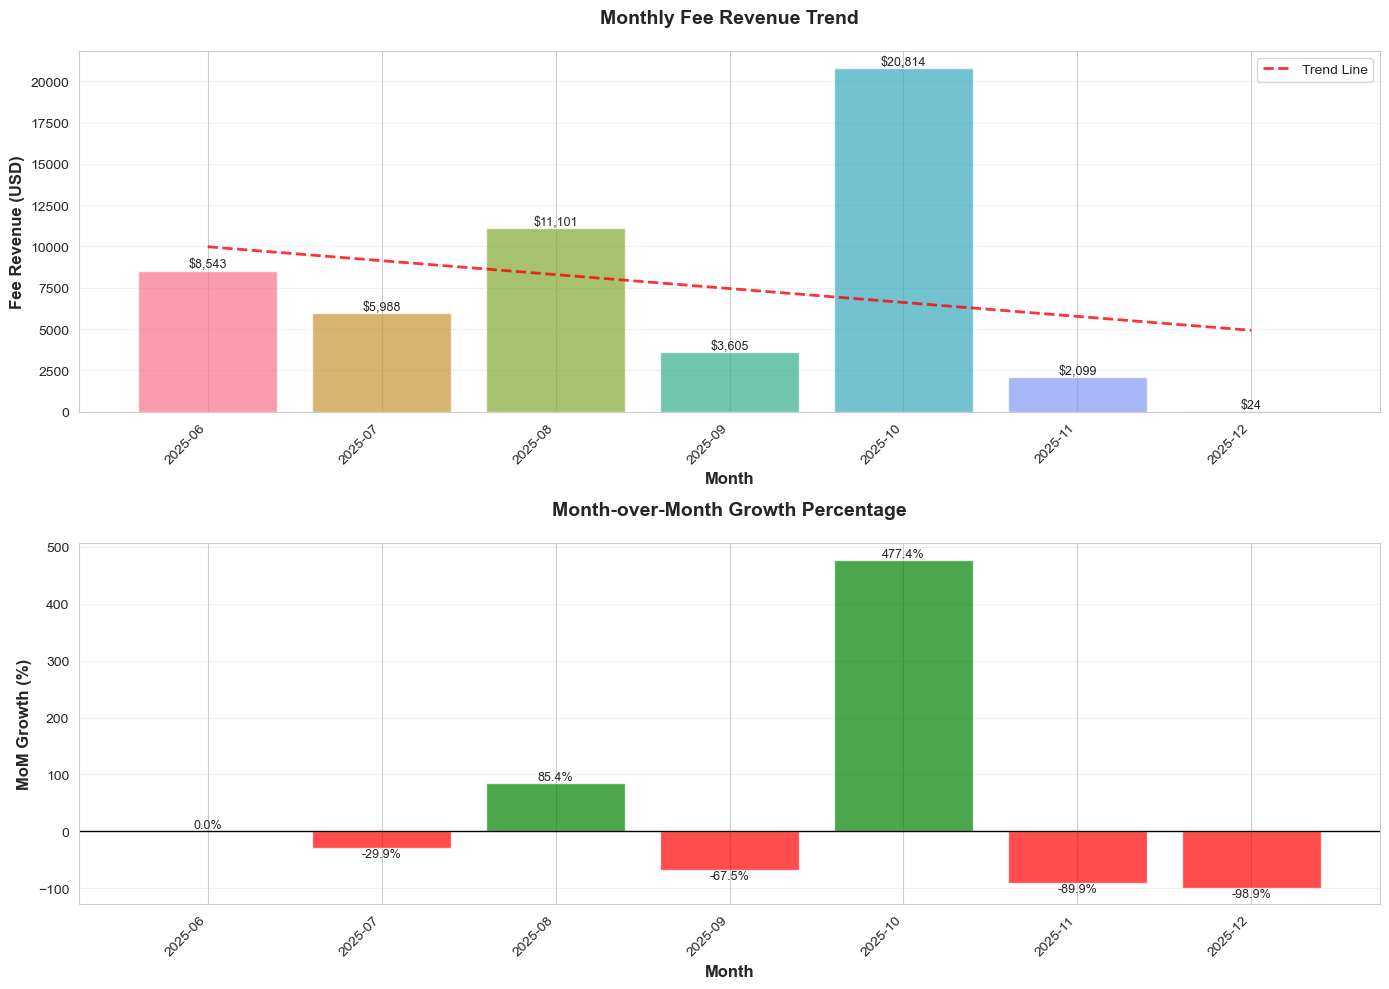

FEE REVENUE TREND ANALYSIS SUMMARY
Top Month: $20,813.65 (2025-10)
Best Growth: 477.4% (2025-10)

Total Revenue: $52,172.34
Average Monthly Revenue: $7,453.19
Average MoM Growth: 39.5%


In [ ]:
# CELL 1: Fee Revenue Trend Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set professional styling
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Prepare data: Use fee_usd if available, otherwise estimate from affiliate_address
# For this analysis, we'll use a proxy: if affiliate_address exists, assume fee
if 'fee_usd' not in analysis_df.columns:
    # Estimate fee: assume 0.3% of from_amount for swaps with affiliate
    analysis_df['fee_usd'] = np.where(
        analysis_df.get('affiliate_address', pd.Series([None]*len(analysis_df))).notna(),
        analysis_df['from_amount'] * 0.003,  # 0.3% fee estimate
        0
    )

# Ensure timestamp is datetime
if 'timestamp' in analysis_df.columns:
    analysis_df['timestamp'] = pd.to_datetime(analysis_df['timestamp'], errors='coerce')
    
    # Aggregate by month
    analysis_df['year_month'] = analysis_df['timestamp'].dt.to_period('M').astype(str)
    
    monthly_revenue = analysis_df.groupby('year_month').agg({
        'fee_usd': ['sum', 'count', 'mean']
    }).round(2)
    monthly_revenue.columns = ['total_fees', 'swap_count', 'avg_fee_per_swap']
    monthly_revenue = monthly_revenue.reset_index()
    
    # Calculate month-over-month growth
    monthly_revenue['mom_growth_pct'] = monthly_revenue['total_fees'].pct_change() * 100
    monthly_revenue['mom_growth_pct'] = monthly_revenue['mom_growth_pct'].fillna(0)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top subplot: Monthly fee revenue bar chart with trend line
    bars = ax1.bar(range(len(monthly_revenue)), monthly_revenue['total_fees'], 
                   color=sns.color_palette("husl", len(monthly_revenue)), alpha=0.7)
    ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Monthly Fee Revenue Trend', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(range(len(monthly_revenue)))
    ax1.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add trend line
    z = np.polyfit(range(len(monthly_revenue)), monthly_revenue['total_fees'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(monthly_revenue)), p(range(len(monthly_revenue))), 
             "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        ax1.text(i, row['total_fees'], f'${row["total_fees"]:,.0f}', 
                ha='center', va='bottom', fontsize=9)
    
    # Bottom subplot: Month-over-month growth percentage
    colors = ['green' if x >= 0 else 'red' for x in monthly_revenue['mom_growth_pct']]
    ax2.bar(range(len(monthly_revenue)), monthly_revenue['mom_growth_pct'], 
            color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MoM Growth (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Month-over-Month Growth Percentage', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(monthly_revenue)))
    ax2.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        if not pd.isna(row['mom_growth_pct']):
            ax2.text(i, row['mom_growth_pct'], f'{row["mom_growth_pct"]:.1f}%', 
                    ha='center', va='bottom' if row['mom_growth_pct'] >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    top_month_idx = monthly_revenue['total_fees'].idxmax()
    top_month = monthly_revenue.loc[top_month_idx]
    best_growth_idx = monthly_revenue['mom_growth_pct'].idxmax()
    best_growth = monthly_revenue.loc[best_growth_idx]
    
    print("=" * 60)
    print("FEE REVENUE TREND ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Top Month: ${top_month['total_fees']:,.2f} ({top_month['year_month']})")
    print(f"Best Growth: {best_growth['mom_growth_pct']:.1f}% ({best_growth['year_month']})")
    print(f"\nTotal Revenue: ${monthly_revenue['total_fees'].sum():,.2f}")
    print(f"Average Monthly Revenue: ${monthly_revenue['total_fees'].mean():,.2f}")
    print(f"Average MoM Growth: {monthly_revenue['mom_growth_pct'].mean():.1f}%")
    print("=" * 60)
else:
    print("Error: Timestamp column not found or cannot be processed")


### CELL 2: Revenue Concentration Risk (Pareto Analysis)

**Business Question:** Is fee revenue concentrated in a few asset pairs, or is it diversified across many pairs?

**Goal:** Identify if revenue is concentrated (high risk) or diversified (lower risk) for committee risk assessment.


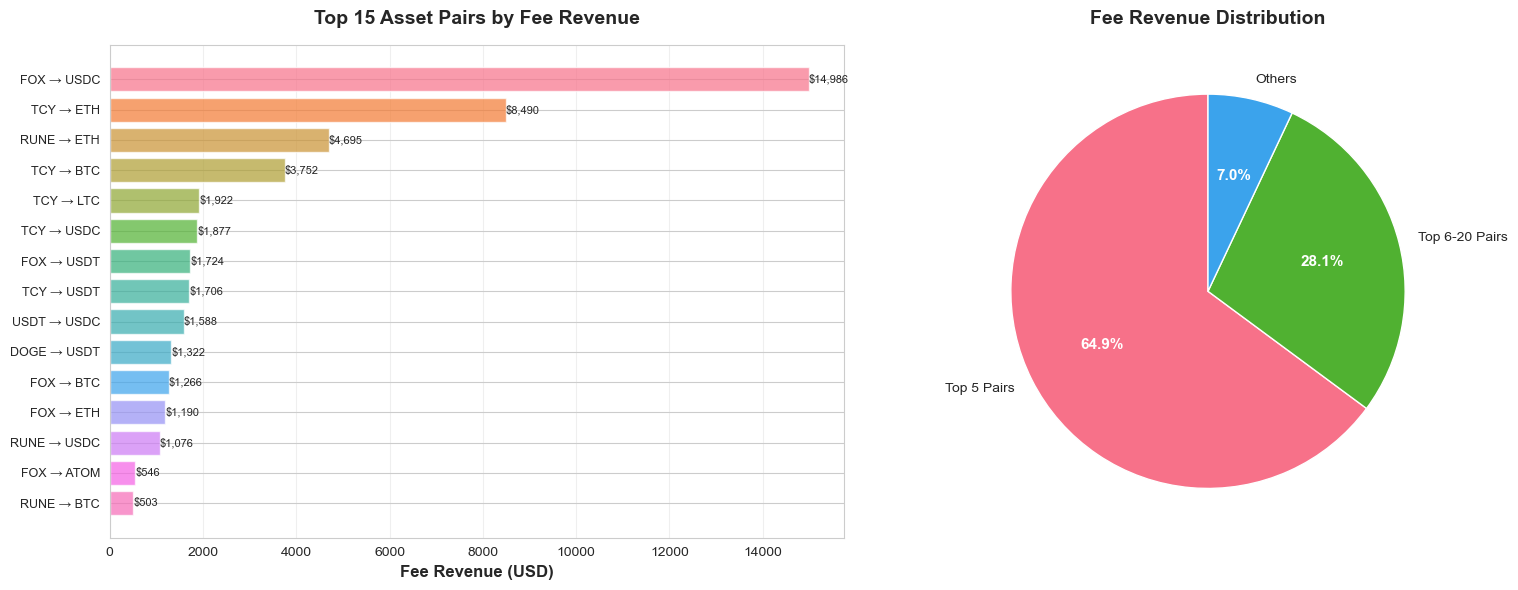

REVENUE CONCENTRATION RISK ANALYSIS
Top 5 pairs = 64.9% of fees
Top 10 pairs = 80.6% of fees
Top 20 pairs = 93.0% of fees

Total unique pairs: 199
Total fee revenue: $52,172.35

⚠️  RISK: Concentration is HIGH (>60%). Revenue heavily dependent on top 5 pairs.


In [ ]:
# CELL 2: Revenue Concentration Risk (Pareto Analysis)

# Group by asset pair and calculate total fees
pair_revenue = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum'
}).reset_index()
pair_revenue.columns = ['from_asset', 'to_asset', 'total_fees']
pair_revenue['asset_pair'] = pair_revenue['from_asset'] + ' → ' + pair_revenue['to_asset']

# Rank pairs by fee revenue
pair_revenue = pair_revenue.sort_values('total_fees', ascending=False).reset_index(drop=True)
pair_revenue['rank'] = pair_revenue.index + 1
pair_revenue['cumulative_fees'] = pair_revenue['total_fees'].cumsum()
pair_revenue['cumulative_pct'] = (pair_revenue['cumulative_fees'] / pair_revenue['total_fees'].sum()) * 100

# Calculate concentration metrics
total_fees = pair_revenue['total_fees'].sum()
top_5_pct = (pair_revenue.head(5)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 5 else 0
top_10_pct = (pair_revenue.head(10)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 10 else 0
top_20_pct = (pair_revenue.head(20)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 20 else 0

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bar chart of top 15 pairs
top_15 = pair_revenue.head(15)
bars = ax1.barh(range(len(top_15)), top_15['total_fees'], 
                color=sns.color_palette("husl", len(top_15)), alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15.iterrows()):
    ax1.text(row['total_fees'], i, f'${row["total_fees"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Pie chart showing concentration
top_5_fees = pair_revenue.head(5)['total_fees'].sum()
top_6_20_fees = pair_revenue.iloc[5:20]['total_fees'].sum() if len(pair_revenue) >= 20 else pair_revenue.iloc[5:]['total_fees'].sum()
others_fees = total_fees - top_5_fees - top_6_20_fees

pie_data = [top_5_fees, top_6_20_fees, others_fees]
pie_labels = ['Top 5 Pairs', 'Top 6-20 Pairs', 'Others']
colors_pie = sns.color_palette("husl", 3)

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                    colors=colors_pie, startangle=90)
ax2.set_title('Fee Revenue Distribution', fontsize=14, fontweight='bold', pad=15)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("REVENUE CONCENTRATION RISK ANALYSIS")
print("=" * 60)
print(f"Top 5 pairs = {top_5_pct:.1f}% of fees")
print(f"Top 10 pairs = {top_10_pct:.1f}% of fees")
print(f"Top 20 pairs = {top_20_pct:.1f}% of fees")
print(f"\nTotal unique pairs: {len(pair_revenue)}")
print(f"Total fee revenue: ${total_fees:,.2f}")

# Risk assessment
if top_5_pct > 60:
    risk_level = "HIGH"
    risk_msg = "⚠️  RISK: Concentration is HIGH (>60%). Revenue heavily dependent on top 5 pairs."
elif top_5_pct > 40:
    risk_level = "MEDIUM"
    risk_msg = "⚠️  RISK: Concentration is MEDIUM (40-60%). Moderate diversification."
else:
    risk_level = "LOW"
    risk_msg = "✓ RISK: Concentration is LOW (<40%). Good diversification across pairs."

print(f"\n{risk_msg}")
print("=" * 60)


### CELL 3: User Retention & Engagement

**Business Question:** Are users engaging repeatedly, or do they churn after their first trade?

**Goal:** Show if users are engaged (repeat traders) or churning (one-time traders) for committee engagement assessment.


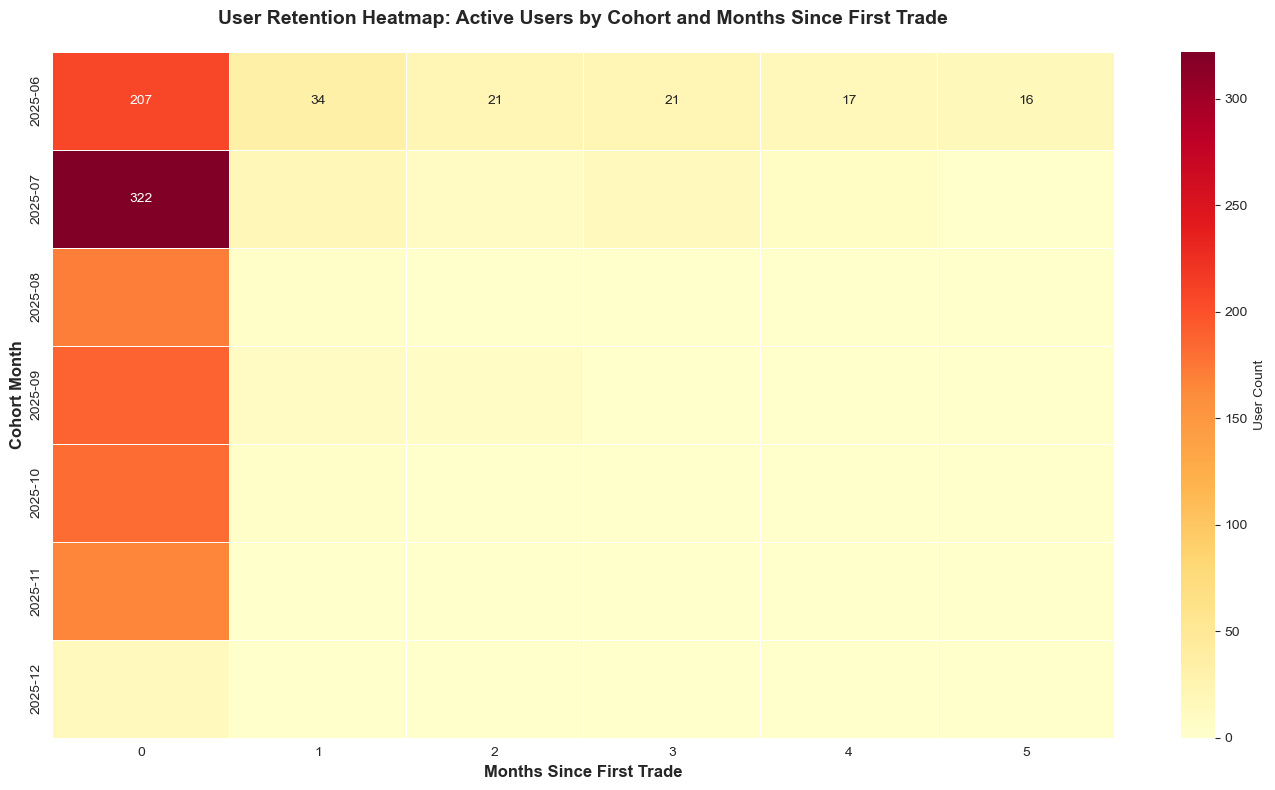

USER RETENTION & ENGAGEMENT ANALYSIS
Total unique users: 1,249
Repeat traders (>1 trade): 217 (17.4%)
Sticky users (10+ trades): 20 (1.6%)

Average trades per user: 2.30
Median trades per user: 1.00


In [ ]:
# CELL 3: User Retention & Engagement

# Get user address column (adapt if column name differs)
user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Calculate first trade date per user
    user_first_trade = analysis_df.groupby(user_col)['timestamp'].min().reset_index()
    user_first_trade.columns = [user_col, 'first_trade_date']
    user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
    
    # Merge back to main dataframe
    analysis_df_with_cohort = analysis_df.merge(user_first_trade, on=user_col, how='left')
    analysis_df_with_cohort['trade_month'] = pd.to_datetime(analysis_df_with_cohort['timestamp']).dt.to_period('M').astype(str)
    
    # Calculate months since first trade
    # Convert to Period objects and calculate difference in months
    def calculate_months_diff(row):
        """Calculate months difference between two period strings"""
        try:
            if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                return 0
            trade_period = pd.Period(row['trade_month'])
            cohort_period = pd.Period(row['cohort_month'])
            return (trade_period - cohort_period).n
        except:
            return 0
    
    analysis_df_with_cohort['months_since_first'] = analysis_df_with_cohort.apply(calculate_months_diff, axis=1)
    
    # Create cohort retention table
    cohort_retention = analysis_df_with_cohort.groupby(['cohort_month', 'months_since_first'])[user_col].nunique().reset_index()
    cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
    
    # Pivot for heatmap
    cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='user_count').fillna(0)
    
    # Calculate engagement metrics
    user_trade_counts = analysis_df.groupby(user_col).size().reset_index(name='trade_count')
    repeat_traders = len(user_trade_counts[user_trade_counts['trade_count'] > 1])
    sticky_users = len(user_trade_counts[user_trade_counts['trade_count'] >= 10])
    total_users = len(user_trade_counts)
    
    repeat_pct = (repeat_traders / total_users * 100) if total_users > 0 else 0
    sticky_pct = (sticky_users / total_users * 100) if total_users > 0 else 0
    
    # Create heatmap visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create heatmap
    sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'User Count'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
    ax.set_title('User Retention Heatmap: Active Users by Cohort and Months Since First Trade', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("USER RETENTION & ENGAGEMENT ANALYSIS")
    print("=" * 60)
    print(f"Total unique users: {total_users:,}")
    print(f"Repeat traders (>1 trade): {repeat_traders:,} ({repeat_pct:.1f}%)")
    print(f"Sticky users (10+ trades): {sticky_users:,} ({sticky_pct:.1f}%)")
    print(f"\nAverage trades per user: {user_trade_counts['trade_count'].mean():.2f}")
    print(f"Median trades per user: {user_trade_counts['trade_count'].median():.2f}")
    print("=" * 60)
else:
    print("Error: User address or timestamp column not found")


### CELL 4: Trading Time Patterns (Heatmap)

**Business Question:** When do users trade most actively? What are the peak trading hours and days?

**Goal:** Identify best times for promotions and protocol maintenance windows.


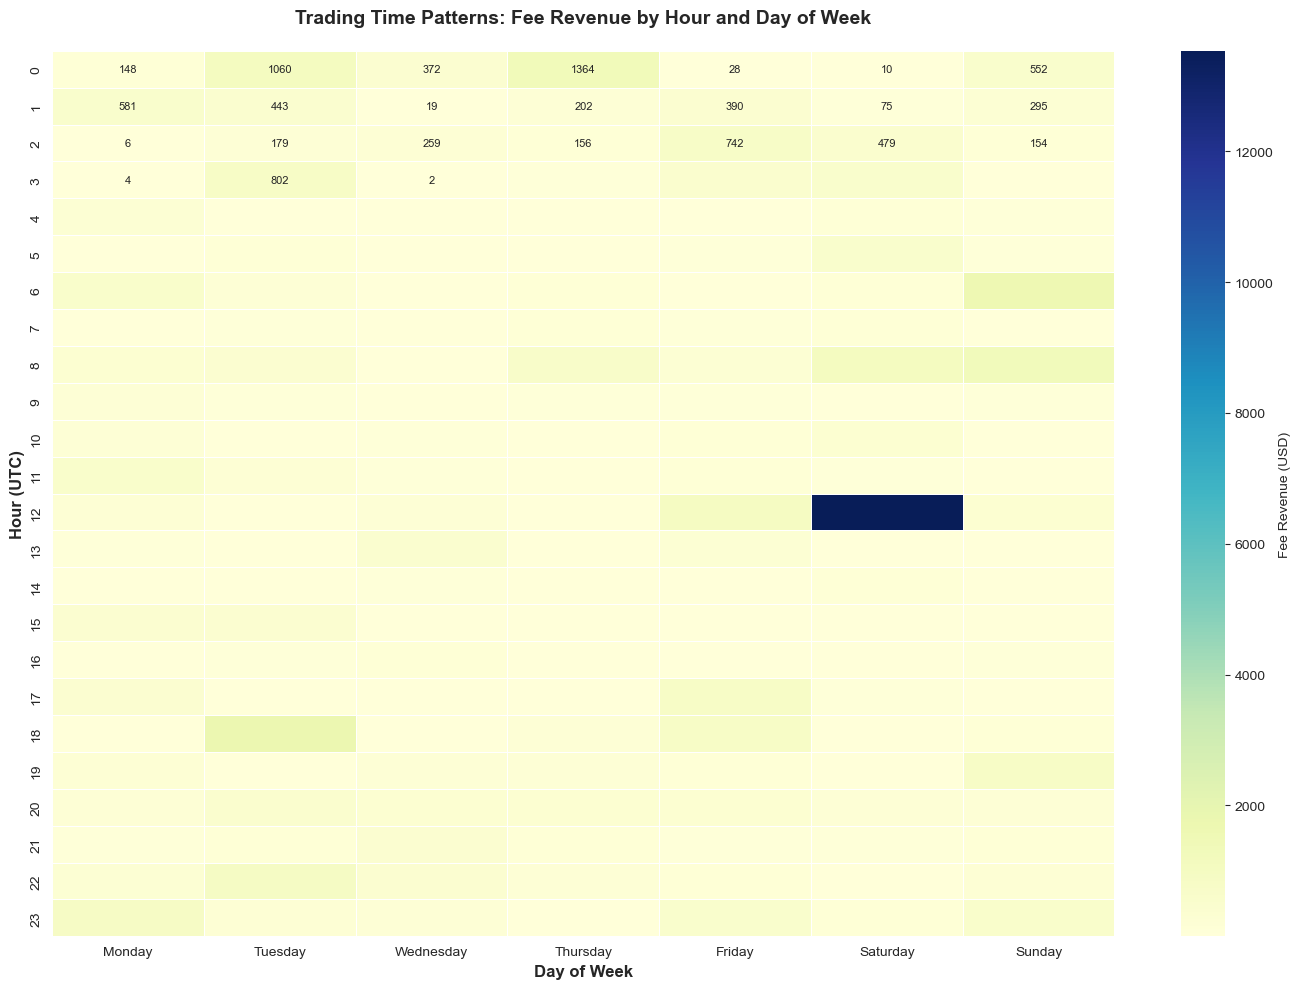

TRADING TIME PATTERNS ANALYSIS
Peak trading time: Saturday at 12:00 UTC
Peak fee revenue: $13,537.25

Top 5 trading periods:
  Saturday 12:00 UTC: $13,537.25
  Tuesday 18:00 UTC: $1,769.48
  Sunday 6:00 UTC: $1,601.62
  Thursday 0:00 UTC: $1,363.70
  Sunday 8:00 UTC: $1,299.29


In [ ]:
# CELL 4: Trading Time Patterns (Heatmap)

if 'timestamp' in analysis_df.columns:
    # Extract hour and day of week
    analysis_df['hour'] = pd.to_datetime(analysis_df['timestamp']).dt.hour
    analysis_df['day_of_week'] = pd.to_datetime(analysis_df['timestamp']).dt.day_name()
    
    # Create pivot table: rows=hour, columns=day, values=SUM(fee_usd)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    time_pivot = analysis_df.pivot_table(
        values='fee_usd',
        index='hour',
        columns='day_of_week',
        aggfunc='sum',
        fill_value=0
    )
    time_pivot = time_pivot.reindex(columns=day_order, fill_value=0)
    
    # Create annotated heatmap
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap with annotations
    sns.heatmap(time_pivot, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Fee Revenue (USD)'}, ax=ax, 
                linewidths=0.5, annot_kws={'size': 8})
    
    ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hour (UTC)', fontsize=12, fontweight='bold')
    ax.set_title('Trading Time Patterns: Fee Revenue by Hour and Day of Week', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Find peak trading time
    max_value = time_pivot.max().max()
    peak_idx = time_pivot.stack().idxmax()
    peak_hour, peak_day = peak_idx
    
    print("=" * 60)
    print("TRADING TIME PATTERNS ANALYSIS")
    print("=" * 60)
    print(f"Peak trading time: {peak_day} at {peak_hour}:00 UTC")
    print(f"Peak fee revenue: ${max_value:,.2f}")
    print(f"\nTop 5 trading periods:")
    top_periods = time_pivot.stack().sort_values(ascending=False).head(5)
    for (hour, day), value in top_periods.items():
        print(f"  {day} {hour}:00 UTC: ${value:,.2f}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


### CELL 5: Top 20 Whale Users Deep Dive

**Business Question:** How dependent is fee revenue on a small number of high-volume users (whales)?

**Goal:** Identify whale dependency risk for committee risk assessment.


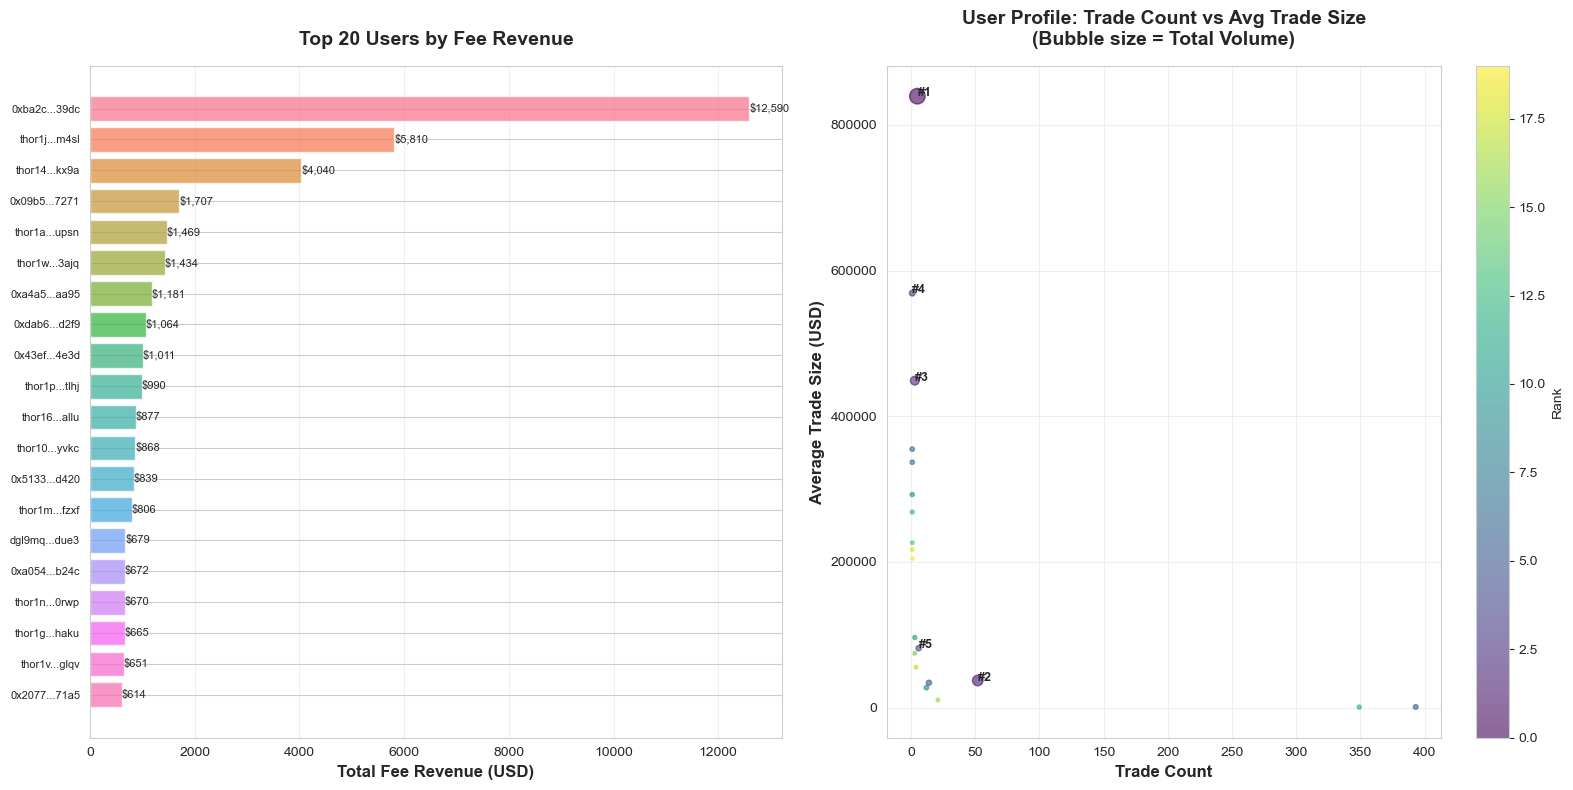

TOP 20 WHALE USERS ANALYSIS
Top 10 users = 60.3% of fees
Top 20 users = 74.5% of fees

Total unique users: 1,249
Total fee revenue: $51,881.20

⚠️  CONCENTRATION RISK: HIGH (>50%). Revenue heavily dependent on top 10 users.

Top 5 users:
  #1: $12,589.62 (5 trades, avg $839,308.18)
  #2: $5,809.62 (52 trades, avg $37,241.17)
  #3: $4,039.99 (3 trades, avg $448,888.00)
  #4: $1,706.80 (1 trades, avg $568,934.90)
  #5: $1,469.41 (6 trades, avg $81,633.67)


In [ ]:
# CELL 5: Top 20 Whale Users Deep Dive

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns:
    # Group by user and calculate metrics
    user_stats = analysis_df.groupby(user_col).agg({
        'fee_usd': 'sum',
        'from_amount': ['count', 'mean'],
        'timestamp': ['min', 'max']
    }).reset_index()
    user_stats.columns = [user_col, 'total_volume', 'trade_count', 'avg_trade_size', 
                         'first_trade_date', 'last_trade_date']
    
    # Sort by total volume (fee revenue)
    user_stats = user_stats.sort_values('total_volume', ascending=False).reset_index(drop=True)
    
    # Calculate concentration metrics
    total_fees_all = user_stats['total_volume'].sum()
    top_10_pct = (user_stats.head(10)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 10 else 0
    top_20_pct = (user_stats.head(20)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 20 else 0
    
    # Get top 20 for visualization
    top_20 = user_stats.head(20).copy()
    
    # Anonymize addresses for display (show first 6 and last 4 chars)
    top_20['user_id'] = top_20[user_col].apply(
        lambda x: f"{str(x)[:6]}...{str(x)[-4:]}" if len(str(x)) > 10 else str(x)
    )
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Bar chart of top 20 users by volume
    bars = ax1.barh(range(len(top_20)), top_20['total_volume'], 
                    color=sns.color_palette("husl", len(top_20)), alpha=0.7)
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['user_id'], fontsize=8)
    ax1.set_xlabel('Total Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Top 20 Users by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(top_20.iterrows()):
        ax1.text(row['total_volume'], i, f'${row["total_volume"]:,.0f}', 
                va='center', ha='left', fontsize=8)
    
    # Right: Scatter plot: X=trade_count, Y=avg_trade_size, size=total_volume
    scatter = ax2.scatter(top_20['trade_count'], top_20['avg_trade_size'], 
                         s=top_20['total_volume']/100, alpha=0.6, 
                         c=range(len(top_20)), cmap='viridis')
    ax2.set_xlabel('Trade Count', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_title('User Profile: Trade Count vs Avg Trade Size\n(Bubble size = Total Volume)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 users
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        ax2.annotate(f"#{i+1}", (row['trade_count'], row['avg_trade_size']), 
                    fontsize=9, fontweight='bold')
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("TOP 20 WHALE USERS ANALYSIS")
    print("=" * 60)
    print(f"Top 10 users = {top_10_pct:.1f}% of fees")
    print(f"Top 20 users = {top_20_pct:.1f}% of fees")
    print(f"\nTotal unique users: {len(user_stats):,}")
    print(f"Total fee revenue: ${total_fees_all:,.2f}")
    
    # Risk assessment
    if top_10_pct > 50:
        risk_level = "HIGH"
        risk_msg = "⚠️  CONCENTRATION RISK: HIGH (>50%). Revenue heavily dependent on top 10 users."
    elif top_10_pct > 30:
        risk_level = "MEDIUM"
        risk_msg = "⚠️  CONCENTRATION RISK: MEDIUM (30-50%). Moderate whale dependency."
    else:
        risk_level = "LOW"
        risk_msg = "✓ CONCENTRATION RISK: LOW (<30%). Good user diversification."
    
    print(f"\n{risk_msg}")
    print(f"\nTop 5 users:")
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        print(f"  #{i+1}: ${row['total_volume']:,.2f} ({row['trade_count']} trades, avg ${row['avg_trade_size']:,.2f})")
    print("=" * 60)
else:
    print("Error: User address column not found")


### CELL 6: Asset Pair Performance Matrix

**Business Question:** Which asset pairs are most reliable for fee generation? Which are most volatile?

**Goal:** Show which pairs are reliable (stable) vs volatile (risky) for fee generation.


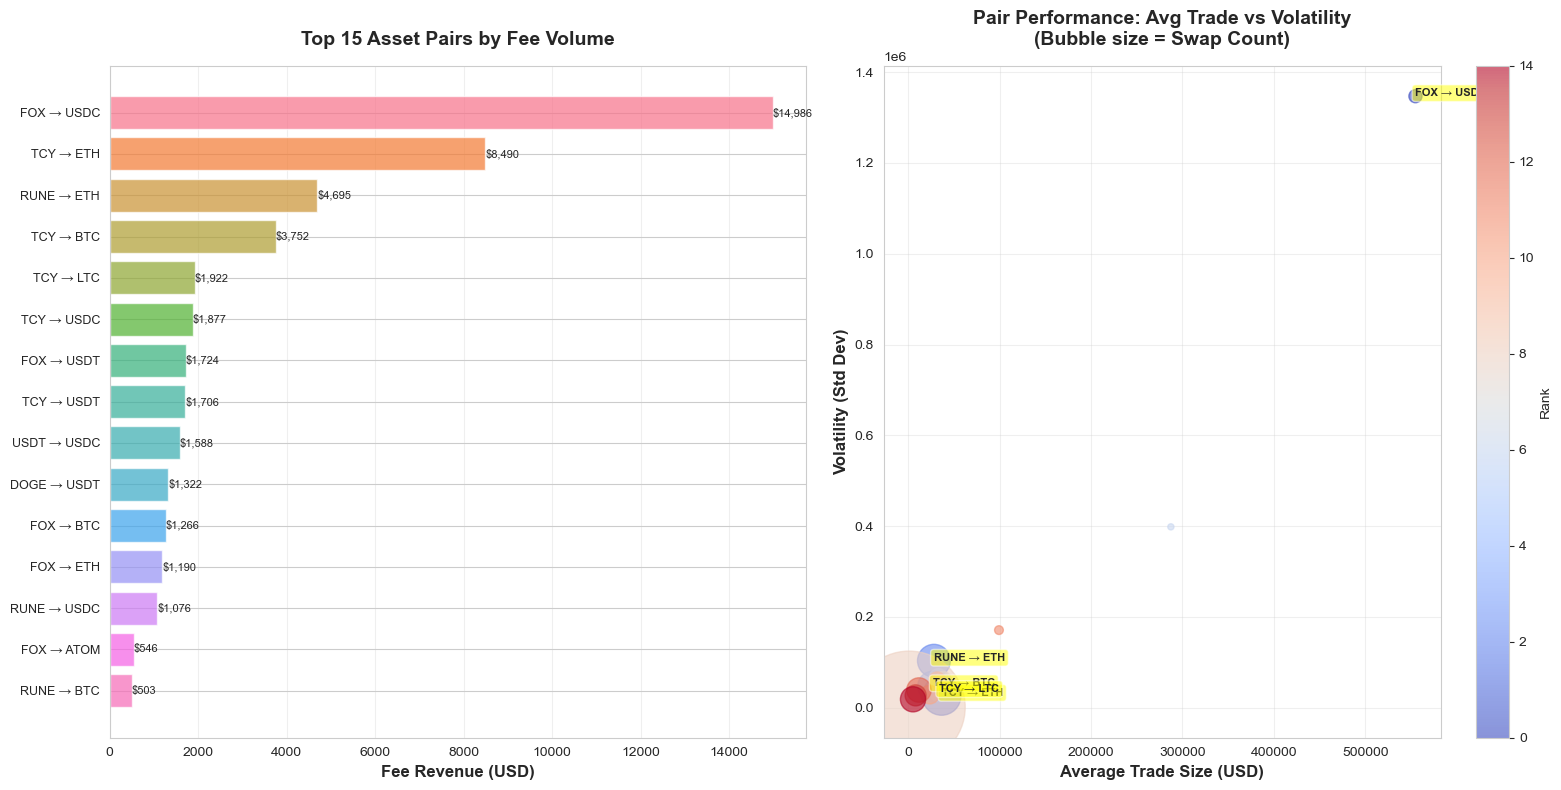

ASSET PAIR PERFORMANCE MATRIX
Most stable pair: ETH → AAVE (CV: 0.086, Volatility: $0.00)
Most volatile pair: USDT → DOGE (CV: 6.353, Volatility: $11,189.49)

Top 15 pairs by volume:
  #1: FOX → USDC - $14,985.52 (9 swaps, avg $555,019.44)
  #2: TCY → ETH - $8,489.77 (78 swaps, avg $36,281.08)
  #3: RUNE → ETH - $4,695.07 (56 swaps, avg $27,946.86)
  #4: TCY → BTC - $3,751.68 (47 swaps, avg $26,607.67)
  #5: TCY → LTC - $1,922.10 (19 swaps, avg $33,721.11)
  #6: TCY → USDC - $1,877.47 (19 swaps, avg $32,938.02)
  #7: FOX → USDT - $1,723.84 (2 swaps, avg $287,305.90)
  #8: TCY → USDT - $1,706.05 (15 swaps, avg $37,912.33)
  #9: USDT → USDC - $1,587.76 (652 swaps, avg $811.74)
  #10: DOGE → USDT - $1,322.07 (14 swaps, avg $31,477.95)
  #11: FOX → BTC - $1,265.57 (18 swaps, avg $23,436.46)
  #12: FOX → ETH - $1,189.67 (4 swaps, avg $99,138.90)
  #13: RUNE → USDC - $1,075.59 (31 swaps, avg $11,565.52)
  #14: FOX → ATOM - $546.19 (23 swaps, avg $7,915.75)
  #15: RUNE → BTC - $503.33 (33 swa

In [ ]:
# CELL 6: Asset Pair Performance Matrix

# Group by asset pair and calculate metrics
pair_performance = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum',
    'from_amount': ['count', 'mean', 'std']
}).reset_index()
pair_performance.columns = ['from_asset', 'to_asset', 'pair_volume', 'swap_count', 
                           'avg_trade', 'volatility']
pair_performance['asset_pair'] = pair_performance['from_asset'] + ' → ' + pair_performance['to_asset']

# Fill NaN volatility with 0 (for pairs with only 1 swap)
pair_performance['volatility'] = pair_performance['volatility'].fillna(0)

# Sort by volume and get top 15
pair_performance = pair_performance.sort_values('pair_volume', ascending=False).reset_index(drop=True)
top_15_pairs = pair_performance.head(15).copy()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Horizontal bar chart of top 15 pairs by volume
bars = ax1.barh(range(len(top_15_pairs)), top_15_pairs['pair_volume'], 
                color=sns.color_palette("husl", len(top_15_pairs)), alpha=0.7)
ax1.set_yticks(range(len(top_15_pairs)))
ax1.set_yticklabels(top_15_pairs['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Volume', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    ax1.text(row['pair_volume'], i, f'${row["pair_volume"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Scatter plot: X=avg_trade, Y=volatility, bubble_size=swap_count
# Filter to pairs with at least 2 swaps for meaningful volatility
scatter_data = top_15_pairs[top_15_pairs['swap_count'] >= 2].copy()

if len(scatter_data) > 0:
    scatter = ax2.scatter(scatter_data['avg_trade'], scatter_data['volatility'], 
                         s=scatter_data['swap_count']*10, alpha=0.6, 
                         c=range(len(scatter_data)), cmap='coolwarm')
    ax2.set_xlabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Volatility (Std Dev)', fontsize=12, fontweight='bold')
    ax2.set_title('Pair Performance: Avg Trade vs Volatility\n(Bubble size = Swap Count)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 pairs
    for i, (idx, row) in enumerate(scatter_data.head(5).iterrows()):
        ax2.annotate(row['asset_pair'], (row['avg_trade'], row['volatility']), 
                    fontsize=8, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
else:
    ax2.text(0.5, 0.5, 'Insufficient data\nfor volatility analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Pair Performance: Avg Trade vs Volatility', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("ASSET PAIR PERFORMANCE MATRIX")
print("=" * 60)

# Find most stable and most volatile pairs (with at least 5 swaps)
stable_pairs = pair_performance[pair_performance['swap_count'] >= 5].copy()
if len(stable_pairs) > 0:
    stable_pairs['cv'] = stable_pairs['volatility'] / stable_pairs['avg_trade']  # coefficient of variation
    stable_pairs = stable_pairs[stable_pairs['cv'] > 0]  # Remove pairs with zero volatility
    
    if len(stable_pairs) > 0:
        most_stable = stable_pairs.loc[stable_pairs['cv'].idxmin()]
        most_volatile = stable_pairs.loc[stable_pairs['cv'].idxmax()]
        
        print(f"Most stable pair: {most_stable['asset_pair']} (CV: {most_stable['cv']:.3f}, Volatility: ${most_stable['volatility']:,.2f})")
        print(f"Most volatile pair: {most_volatile['asset_pair']} (CV: {most_volatile['cv']:.3f}, Volatility: ${most_volatile['volatility']:,.2f})")
    else:
        print("Insufficient data for stability analysis")
else:
    print("Insufficient data for stability analysis (need pairs with 5+ swaps)")

print(f"\nTop 15 pairs by volume:")
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    print(f"  #{i+1}: {row['asset_pair']} - ${row['pair_volume']:,.2f} ({row['swap_count']} swaps, avg ${row['avg_trade']:,.2f})")
print("=" * 60)


### CELL 7: Week-over-Week Growth Dashboard

**Business Question:** What is the current momentum? Is growth accelerating or decelerating?

**Goal:** Show momentum and accelerating/decelerating growth trends for committee decision-making.


## Additional Analysis Cells - Advanced Financial Metrics

This section provides additional advanced analysis for comprehensive financial decision-making.


### CELL 13: Projected Revenue Forecast (3-Month)

**Business Impact:** What's Q1 budget going to be?

**Goal:** Forecast THORChain affiliate revenue for the next 3 months with confidence intervals.


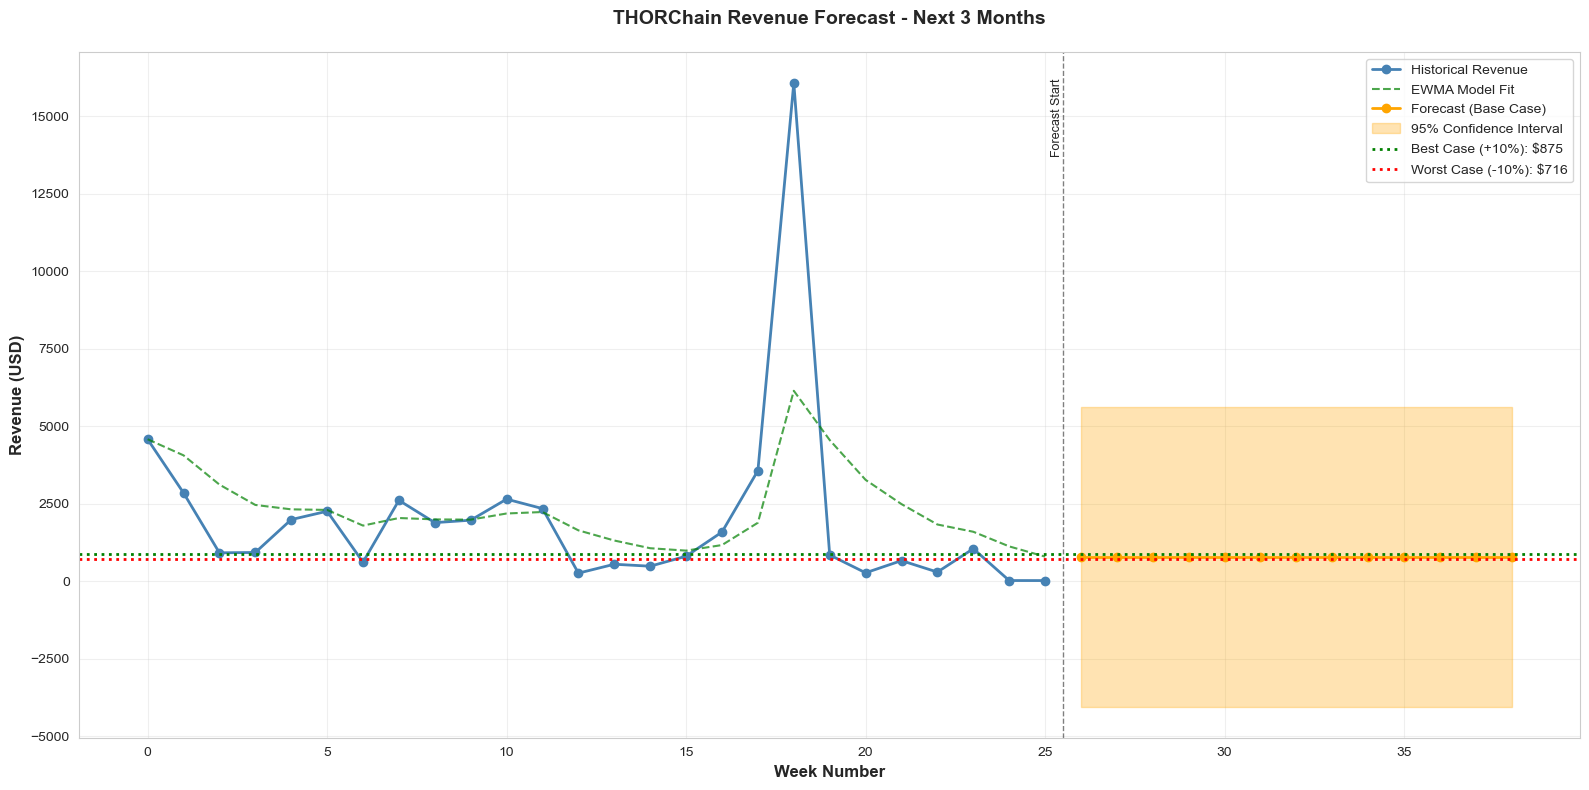

PROJECTED REVENUE FORECAST (3-MONTH)
Model Used: EWMA (std dev: $2,343.66)

Monthly Forecasts:
  December: $796 ± $4,837
  January: $796 ± $4,837
  February: $796 ± $4,837
  March: $796 ± $4,837

Scenarios:
  Best Case: $875/month (+10% growth)
  Base Case: $796/month (current trend)
  Worst Case: $716/month (-10% decline)


In [ ]:
# CELL 13: Projected Revenue Forecast (3-Month)
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Prepare data: aggregate revenue by week
if 'timestamp' in analysis_df.columns and 'fee_usd' in analysis_df.columns:
    # Filter to valid timestamps
    forecast_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(forecast_df) > 0:
        # Aggregate by week
        forecast_df['year'] = forecast_df['timestamp'].dt.year
        forecast_df['week'] = forecast_df['timestamp'].dt.isocalendar().week
        forecast_df['year_week'] = forecast_df['year'].astype(str) + '-W' + forecast_df['week'].astype(str).str.zfill(2)
        
        weekly_revenue = forecast_df.groupby('year_week').agg({
            'fee_usd': 'sum'
        }).reset_index()
        weekly_revenue.columns = ['year_week', 'weekly_revenue']
        weekly_revenue = weekly_revenue.sort_values('year_week').reset_index(drop=True)
        weekly_revenue['week_num'] = range(len(weekly_revenue))
        
        if len(weekly_revenue) >= 4:  # Need at least 4 weeks for forecasting
            # Prepare data for modeling
            X = weekly_revenue['week_num'].values.reshape(-1, 1)
            y = weekly_revenue['weekly_revenue'].values
            
            # Model 1: Linear Regression
            lr_model = LinearRegression()
            lr_model.fit(X, y)
            lr_pred = lr_model.predict(X)
            lr_residuals = y - lr_pred
            lr_std = np.std(lr_residuals)
            
            # Model 2: Exponential (log-linear)
            y_log = np.log(y + 1)  # Add 1 to avoid log(0)
            exp_model = LinearRegression()
            exp_model.fit(X, y_log.reshape(-1, 1))
            exp_pred_log = exp_model.predict(X)
            exp_pred = np.exp(exp_pred_log) - 1
            exp_residuals = y - exp_pred.flatten()
            exp_std = np.std(exp_residuals)
            
            # Model 3: EWMA (Exponentially Weighted Moving Average)
            alpha = 0.3
            ewma_values = [y[0]]
            for i in range(1, len(y)):
                ewma_values.append(alpha * y[i] + (1 - alpha) * ewma_values[-1])
            ewma_pred = np.array(ewma_values)
            ewma_residuals = y - ewma_pred
            ewma_std = np.std(ewma_residuals)
            
            # Choose best model (lowest std dev)
            models = {
                'Linear': (lr_model, lr_std, lr_pred),
                'Exponential': (exp_model, exp_std, exp_pred.flatten()),
                'EWMA': (None, ewma_std, ewma_pred)
            }
            best_model_name = min(models, key=lambda x: models[x][1])
            best_model, best_std, best_pred = models[best_model_name]
            
            # Forecast forward 13 weeks (3 months)
            future_weeks = np.array(range(len(weekly_revenue), len(weekly_revenue) + 13)).reshape(-1, 1)
            
            if best_model_name == 'Linear':
                future_pred = best_model.predict(future_weeks)
            elif best_model_name == 'Exponential':
                future_pred_log = best_model.predict(future_weeks)
                future_pred = np.exp(future_pred_log) - 1
            else:  # EWMA
                last_value = ewma_values[-1]
                # Use numpy array for consistency, so .mean() works everywhere
                future_pred = []
                for _ in range(13):
                    future_pred.append(last_value)
                    last_value = alpha * last_value + (1 - alpha) * last_value
                future_pred = np.array(future_pred)
            
            # Calculate 95% confidence intervals (using t-distribution)
            t_value = stats.t.ppf(0.975, len(y) - 2)  # 95% confidence
            future_lower = future_pred - t_value * best_std
            future_upper = future_pred + t_value * best_std
            
            # Create future week labels
            last_week = weekly_revenue['year_week'].iloc[-1]
            future_week_labels = [f"Week {i+1}" for i in range(13)]
            
            # Calculate scenarios
            base_case = np.mean(future_pred[:4])  # Ensure this works even if future_pred is a list
            best_case = base_case * 1.10  # +10% growth
            worst_case = base_case * 0.90  # -10% decline
            
            # Create visualization
            fig, ax = plt.subplots(figsize=(16, 8))
            
            # Historical data
            ax.plot(weekly_revenue['week_num'], weekly_revenue['weekly_revenue'], 
                   'o-', label='Historical Revenue', linewidth=2, markersize=6, color='steelblue')
            
            # Best model fit
            ax.plot(weekly_revenue['week_num'], best_pred, 
                   '--', label=f'{best_model_name} Model Fit', alpha=0.7, color='green')
            
            # Forecast
            future_week_nums = range(len(weekly_revenue), len(weekly_revenue) + 13)
            ax.plot(future_week_nums, future_pred, 
                   'o-', label='Forecast (Base Case)', linewidth=2, markersize=6, color='orange')
            
            # Confidence band
            ax.fill_between(future_week_nums, future_lower.flatten() if isinstance(future_lower, np.ndarray) else future_lower,
                           future_upper.flatten() if isinstance(future_upper, np.ndarray) else future_upper,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Scenario lines
            ax.axhline(y=best_case, color='green', linestyle=':', linewidth=2, label=f'Best Case (+10%): ${best_case:,.0f}')
            ax.axhline(y=worst_case, color='red', linestyle=':', linewidth=2, label=f'Worst Case (-10%): ${worst_case:,.0f}')
            
            ax.set_xlabel('Week Number', fontsize=12, fontweight='bold')
            ax.set_ylabel('Revenue (USD)', fontsize=12, fontweight='bold')
            ax.set_title('THORChain Revenue Forecast - Next 3 Months', fontsize=14, fontweight='bold', pad=20)
            ax.legend(loc='best')
            ax.grid(True, alpha=0.3)
            
            # Add vertical line separating historical from forecast
            ax.axvline(x=len(weekly_revenue)-0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax.text(len(weekly_revenue)-0.5, ax.get_ylim()[1]*0.95, 'Forecast Start', 
                   rotation=90, va='top', ha='right', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary
            print("=" * 70)
            print("PROJECTED REVENUE FORECAST (3-MONTH)")
            print("=" * 70)
            print(f"Model Used: {best_model_name} (std dev: ${best_std:,.2f})")
            print(f"\nMonthly Forecasts:")
            for i in range(0, 13, 4):  # Show monthly averages
                month_num = (i // 4) + 1
                month_weeks = future_pred[i:min(i+4, 13)]
                month_lower = (future_lower[i:min(i+4, 13)] if isinstance(future_lower, np.ndarray) else future_lower)
                month_upper = (future_upper[i:min(i+4, 13)] if isinstance(future_upper, np.ndarray) else future_upper)
                
                # Use np.mean so that it works regardless of type (list or array)
                month_avg = np.mean(month_weeks)
                month_lower_avg = np.mean(month_lower)
                month_upper_avg = np.mean(month_upper)
                
                month_names = ['December', 'January', 'February', 'March']
                if month_num <= len(month_names):
                    print(f"  {month_names[month_num-1]}: ${month_avg:,.0f} ± ${(month_upper_avg-month_lower_avg)/2:,.0f}")
            
            print(f"\nScenarios:")
            print(f"  Best Case: ${best_case:,.0f}/month (+10% growth)")
            print(f"  Base Case: ${base_case:,.0f}/month (current trend)")
            print(f"  Worst Case: ${worst_case:,.0f}/month (-10% decline)")
            print("=" * 70)
        else:
            print("⚠ Insufficient data for forecasting (need at least 4 weeks)")
    else:
        print("⚠ No valid timestamp data available for forecasting")
else:
    print("⚠ Missing required columns: 'timestamp' and/or 'fee_usd'")


### CELL 14: Incentive ROI Analysis

**Business Impact:** Are rebates actually profitable?

**Goal:** Calculate return-on-investment for affiliate incentive spending.


⚠ Using estimated incentive_paid (0.3% of swap volume)


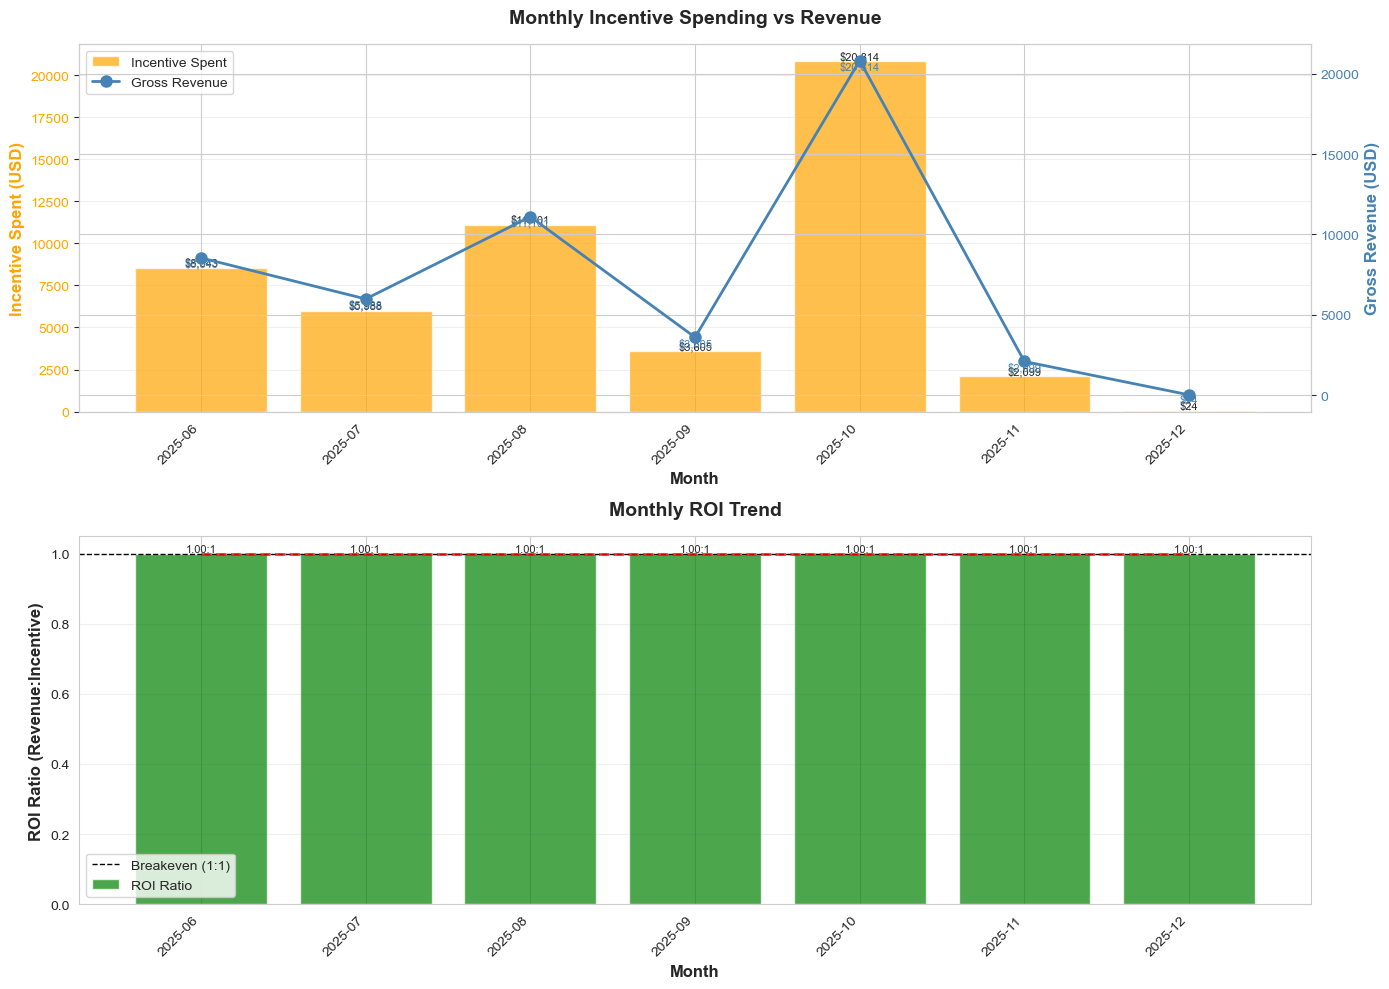

INCENTIVE ROI ANALYSIS
Current Month (2025-12):
  ROI: 1.00:1
  Gross Revenue: $23.55
  Incentive Spent: $23.55
  Net Revenue: $0.00

Historical Trend:
  2025-06: 1.00:1 
  2025-07: 1.00:1 ↓
  2025-08: 1.00:1 ↓
  2025-09: 1.00:1 ↓
  2025-10: 1.00:1 ↓
  2025-11: 1.00:1 ↓
  2025-12: 1.00:1 ↓

Average ROI: 1.00:1
Trend: improving

Recommendation: ⚠️ WARNING: Low ROI. Consider reducing incentive rate from current level.


In [ ]:
# CELL 14: Incentive ROI Analysis

# Check if incentive data exists, otherwise estimate based on typical affiliate structure
if 'timestamp' in analysis_df.columns and 'fee_usd' in analysis_df.columns:
    roi_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    # Estimate incentive spending if not available
    # Typical affiliate rebate: 0.3-0.5% of swap volume
    if 'incentive_paid' not in roi_df.columns:
        # Estimate: assume 0.3% rebate on swap volume
        roi_df['incentive_paid'] = roi_df.get('from_amount_usd', roi_df['from_amount']) * 0.003
        print("⚠ Using estimated incentive_paid (0.3% of swap volume)")
    
    # Aggregate by month
    roi_df['year_month'] = roi_df['timestamp'].dt.to_period('M').astype(str)
    
    monthly_roi = roi_df.groupby('year_month').agg({
        'fee_usd': 'sum',
        'incentive_paid': 'sum',
        'from_amount': 'sum'
    }).reset_index()
    monthly_roi.columns = ['year_month', 'gross_revenue', 'incentive_spent', 'total_volume']
    
    # Calculate metrics
    monthly_roi['net_revenue'] = monthly_roi['gross_revenue'] - monthly_roi['incentive_spent']
    monthly_roi['roi_ratio'] = monthly_roi['gross_revenue'] / monthly_roi['incentive_spent'].replace(0, np.nan)
    monthly_roi['roi_pct'] = ((monthly_roi['gross_revenue'] - monthly_roi['incentive_spent']) / monthly_roi['incentive_spent'] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Calculate month-over-month ROI trend
    monthly_roi['roi_trend'] = monthly_roi['roi_ratio'].pct_change() * 100
    
    if len(monthly_roi) > 0:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Top: Bar chart of incentive spending + revenue line
        x_pos = range(len(monthly_roi))
        bars = ax1.bar(x_pos, monthly_roi['incentive_spent'], alpha=0.7, label='Incentive Spent', color='orange')
        ax1_twin = ax1.twinx()
        line = ax1_twin.plot(x_pos, monthly_roi['gross_revenue'], 'o-', linewidth=2, 
                             markersize=8, label='Gross Revenue', color='steelblue')
        
        ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Incentive Spent (USD)', fontsize=12, fontweight='bold', color='orange')
        ax1_twin.set_ylabel('Gross Revenue (USD)', fontsize=12, fontweight='bold', color='steelblue')
        ax1.set_title('Monthly Incentive Spending vs Revenue', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(monthly_roi['year_month'], rotation=45, ha='right')
        ax1.tick_params(axis='y', labelcolor='orange')
        ax1_twin.tick_params(axis='y', labelcolor='steelblue')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Add value labels on bars
        for i, (idx, row) in enumerate(monthly_roi.iterrows()):
            ax1.text(i, row['incentive_spent'], f'${row["incentive_spent"]:,.0f}', 
                    ha='center', va='bottom', fontsize=8)
            ax1_twin.text(i, row['gross_revenue'], f'${row["gross_revenue"]:,.0f}', 
                         ha='center', va='top', fontsize=8, color='steelblue')
        
        # Bottom: Line chart of ROI with trend line
        colors_roi = ['green' if x >= 1.0 else 'red' for x in monthly_roi['roi_ratio']]
        ax2.bar(x_pos, monthly_roi['roi_ratio'], color=colors_roi, alpha=0.7, label='ROI Ratio')
        ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Breakeven (1:1)')
        ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax2.set_ylabel('ROI Ratio (Revenue:Incentive)', fontsize=12, fontweight='bold')
        ax2.set_title('Monthly ROI Trend', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(monthly_roi['year_month'], rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend()
        
        # Add trend line
        if len(monthly_roi) >= 2:
            z = np.polyfit(x_pos, monthly_roi['roi_ratio'].fillna(1), 1)
            p = np.poly1d(z)
            ax2.plot(x_pos, p(x_pos), "r--", alpha=0.8, linewidth=2, label='Trend Line')
        
        # Add value labels
        for i, (idx, row) in enumerate(monthly_roi.iterrows()):
            if pd.notna(row['roi_ratio']):
                ax2.text(i, row['roi_ratio'], f'{row["roi_ratio"]:.2f}:1', 
                        ha='center', va='bottom' if row['roi_ratio'] >= 1 else 'top', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("INCENTIVE ROI ANALYSIS")
        print("=" * 70)
        
        latest_month = monthly_roi.iloc[-1]
        print(f"Current Month ({latest_month['year_month']}):")
        print(f"  ROI: {latest_month['roi_ratio']:.2f}:1")
        print(f"  Gross Revenue: ${latest_month['gross_revenue']:,.2f}")
        print(f"  Incentive Spent: ${latest_month['incentive_spent']:,.2f}")
        print(f"  Net Revenue: ${latest_month['net_revenue']:,.2f}")
        
        if len(monthly_roi) >= 2:
            print(f"\nHistorical Trend:")
            for i, (idx, row) in enumerate(monthly_roi.iterrows()):
                trend_arrow = "↑" if i > 0 and monthly_roi.iloc[i]['roi_ratio'] > monthly_roi.iloc[i-1]['roi_ratio'] else "↓" if i > 0 else ""
                print(f"  {row['year_month']}: {row['roi_ratio']:.2f}:1 {trend_arrow}")
        
        # Calculate average ROI
        avg_roi = monthly_roi['roi_ratio'].mean()
        trend_direction = "declining" if len(monthly_roi) >= 2 and monthly_roi['roi_ratio'].iloc[-1] < monthly_roi['roi_ratio'].iloc[0] else "improving" if len(monthly_roi) >= 2 else "stable"
        
        print(f"\nAverage ROI: {avg_roi:.2f}:1")
        print(f"Trend: {trend_direction}")
        
        # Recommendation
        if latest_month['roi_ratio'] < 1.0:
            recommendation = "⚠️ CRITICAL: ROI below breakeven. Consider reducing incentive rate or pausing incentives."
        elif latest_month['roi_ratio'] < 1.5:
            recommendation = "⚠️ WARNING: Low ROI. Consider reducing incentive rate from current level."
        elif trend_direction == "declining" and latest_month['roi_ratio'] < 2.0:
            recommendation = "⚠️ CAUTION: ROI declining. Monitor closely and consider reducing incentive rate."
        else:
            recommendation = "✓ ROI is healthy. Current incentive rate appears sustainable."
        
        print(f"\nRecommendation: {recommendation}")
        print("=" * 70)
    else:
        print("⚠ No monthly data available for ROI analysis")
else:
    print("⚠ Missing required columns: 'timestamp' and/or 'fee_usd'")


### CELL 10: Revenue per User Segment (LTV Analysis)

**Business Impact:** Which users are valuable? Where to spend incentives?

**Goal:** Segment users by lifetime value and calculate ROI by user tier.


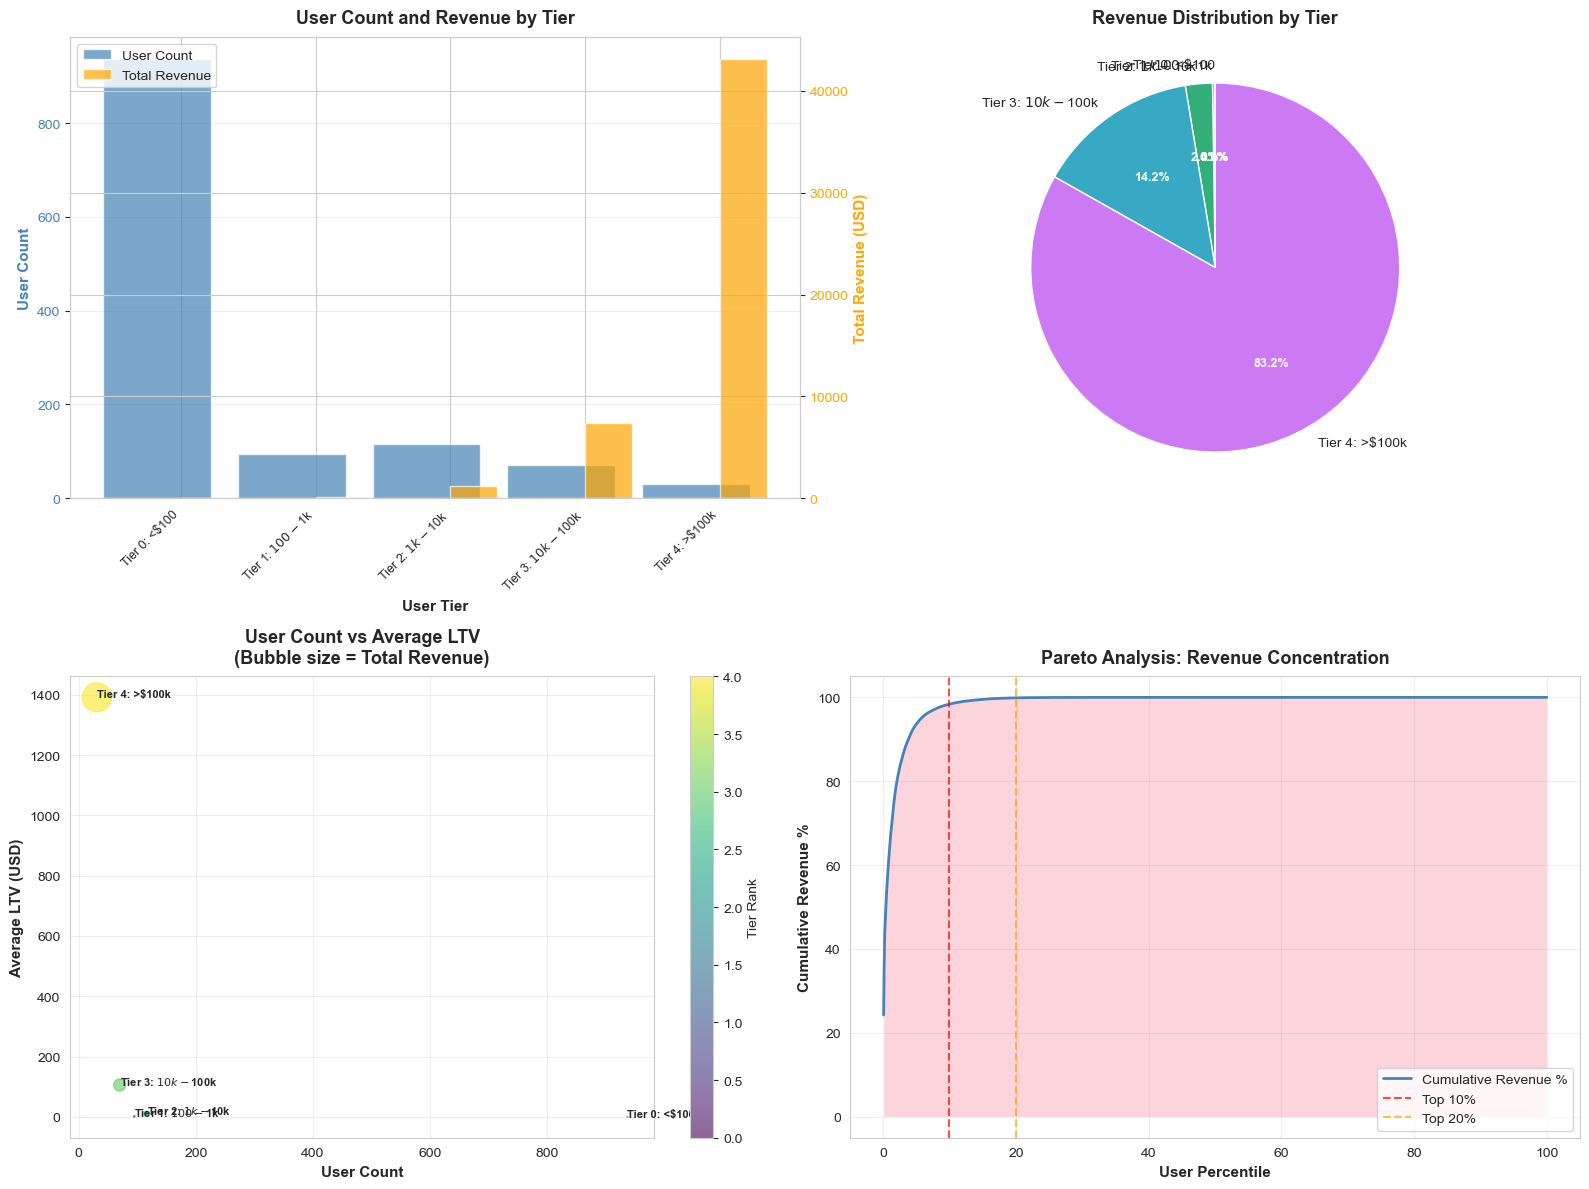

REVENUE PER USER SEGMENT (LTV ANALYSIS)

Tier Breakdown:
              tier  user_count   total_fees     avg_ltv  pct_of_total_revenue  avg_transactions_per_user
     Tier 0: <$100         937    16.120724    0.017205                  0.03                   1.260406
  Tier 1: $100-$1k          95   111.166863    1.170178                  0.21                   1.589474
  Tier 2: $1k-$10k         116  1226.708894   10.575077                  2.36                   2.844828
Tier 3: $10k-$100k          70  7375.325481  105.361793                 14.22                   3.942857
    Tier 4: >$100k          31 43151.881070 1391.996164                 83.17                  30.258065

Pareto Analysis:
  Top 10% of users generate 98.4% of revenue
  Top 20% of users generate 99.9% of revenue

⚠️ HIGH WHALE RISK: Tier 4 (31 users) = 83.2% of revenue

Growth Opportunity:
  Tier 2 ($1k-$10k): 116 users = 2.4% of revenue
  Recommendation: Shift incentives from Tier 0 to Tier 2 for better ROI


In [ ]:
# CELL 10: Revenue per User Segment (LTV Analysis)

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns:
    # Calculate lifetime metrics per user
    user_ltv = analysis_df.groupby(user_col).agg({
        'from_amount': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).reset_index()
    user_ltv.columns = [user_col, 'lifetime_total_volume', 'transaction_count', 'avg_transaction_size', 'lifetime_total_fees']
    
    # Create user tiers based on lifetime volume
    def assign_tier(volume):
        if volume < 100:
            return 'Tier 0: <$100'
        elif volume < 1000:
            return 'Tier 1: $100-$1k'
        elif volume < 10000:
            return 'Tier 2: $1k-$10k'
        elif volume < 100000:
            return 'Tier 3: $10k-$100k'
        else:
            return 'Tier 4: >$100k'
    
    user_ltv['user_tier'] = user_ltv['lifetime_total_volume'].apply(assign_tier)
    
    # Aggregate by tier
    tier_analysis = user_ltv.groupby('user_tier').agg({
        user_col: 'count',
        'lifetime_total_volume': 'sum',
        'lifetime_total_fees': 'sum',
        'transaction_count': 'sum',
        'avg_transaction_size': 'mean'
    }).reset_index()
    tier_analysis.columns = ['tier', 'user_count', 'total_volume', 'total_fees', 'total_transactions', 'avg_transaction_size']
    
    # Calculate metrics
    total_fees_all = tier_analysis['total_fees'].sum()
    tier_analysis['avg_ltv'] = tier_analysis['total_fees'] / tier_analysis['user_count']
    tier_analysis['pct_of_total_revenue'] = (tier_analysis['total_fees'] / total_fees_all * 100).round(2)
    tier_analysis['avg_transactions_per_user'] = tier_analysis['total_transactions'] / tier_analysis['user_count']
    
    # Sort by tier order
    tier_order = ['Tier 0: <$100', 'Tier 1: $100-$1k', 'Tier 2: $1k-$10k', 'Tier 3: $10k-$100k', 'Tier 4: >$100k']
    tier_analysis['tier_num'] = tier_analysis['tier'].apply(lambda x: tier_order.index(x) if x in tier_order else 999)
    tier_analysis = tier_analysis.sort_values('tier_num').reset_index(drop=True)
    
    # Calculate Pareto analysis
    user_ltv_sorted = user_ltv.sort_values('lifetime_total_fees', ascending=False).reset_index(drop=True)
    user_ltv_sorted['cumulative_fees'] = user_ltv_sorted['lifetime_total_fees'].cumsum()
    user_ltv_sorted['cumulative_pct'] = (user_ltv_sorted['cumulative_fees'] / total_fees_all * 100)
    user_ltv_sorted['user_pct'] = ((user_ltv_sorted.index + 1) / len(user_ltv_sorted) * 100)
    
    top_10_pct_users = user_ltv_sorted[user_ltv_sorted['user_pct'] <= 10]
    top_20_pct_users = user_ltv_sorted[user_ltv_sorted['user_pct'] <= 20]
    
    top_10_revenue_pct = top_10_pct_users['lifetime_total_fees'].sum() / total_fees_all * 100 if len(top_10_pct_users) > 0 else 0
    top_20_revenue_pct = top_20_pct_users['lifetime_total_fees'].sum() / total_fees_all * 100 if len(top_20_pct_users) > 0 else 0
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Bar chart (tier vs user_count + revenue overlay)
    x_pos = range(len(tier_analysis))
    bars1 = ax1.bar(x_pos, tier_analysis['user_count'], alpha=0.7, label='User Count', color='steelblue')
    ax1_twin = ax1.twinx()
    bars2 = ax1_twin.bar([x + 0.35 for x in x_pos], tier_analysis['total_fees'], alpha=0.7, 
                         label='Total Revenue', color='orange', width=0.35)
    
    ax1.set_xlabel('User Tier', fontsize=11, fontweight='bold')
    ax1.set_ylabel('User Count', fontsize=11, fontweight='bold', color='steelblue')
    ax1_twin.set_ylabel('Total Revenue (USD)', fontsize=11, fontweight='bold', color='orange')
    ax1.set_title('User Count and Revenue by Tier', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks([x + 0.175 for x in x_pos])
    ax1.set_xticklabels(tier_analysis['tier'], rotation=45, ha='right', fontsize=9)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1_twin.tick_params(axis='y', labelcolor='orange')
    ax1.grid(True, alpha=0.3, axis='y')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Top-right: Pie chart (% by tier)
    colors_pie = sns.color_palette("husl", len(tier_analysis))
    wedges, texts, autotexts = ax2.pie(tier_analysis['pct_of_total_revenue'], labels=tier_analysis['tier'], 
                                       autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax2.set_title('Revenue Distribution by Tier', fontsize=13, fontweight='bold', pad=10)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    # Bottom-left: Scatter (user_count vs avg_ltv)
    scatter = ax3.scatter(tier_analysis['user_count'], tier_analysis['avg_ltv'], 
                         s=tier_analysis['total_fees']/100, alpha=0.6, c=range(len(tier_analysis)), cmap='viridis')
    for i, (idx, row) in enumerate(tier_analysis.iterrows()):
        ax3.annotate(row['tier'], (row['user_count'], row['avg_ltv']), 
                    fontsize=8, fontweight='bold')
    ax3.set_xlabel('User Count', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Average LTV (USD)', fontsize=11, fontweight='bold')
    ax3.set_title('User Count vs Average LTV\n(Bubble size = Total Revenue)', fontsize=13, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Tier Rank')
    
    # Bottom-right: Pareto chart
    ax4.plot(user_ltv_sorted['user_pct'], user_ltv_sorted['cumulative_pct'], 
            linewidth=2, color='steelblue', label='Cumulative Revenue %')
    ax4.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Top 10%')
    ax4.axvline(x=20, color='orange', linestyle='--', alpha=0.7, label='Top 20%')
    ax4.fill_between(user_ltv_sorted['user_pct'], 0, user_ltv_sorted['cumulative_pct'], alpha=0.3)
    ax4.set_xlabel('User Percentile', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Cumulative Revenue %', fontsize=11, fontweight='bold')
    ax4.set_title('Pareto Analysis: Revenue Concentration', fontsize=13, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=" * 70)
    print("REVENUE PER USER SEGMENT (LTV ANALYSIS)")
    print("=" * 70)
    print("\nTier Breakdown:")
    print(tier_analysis[['tier', 'user_count', 'total_fees', 'avg_ltv', 'pct_of_total_revenue', 'avg_transactions_per_user']].to_string(index=False))
    
    print(f"\nPareto Analysis:")
    print(f"  Top 10% of users generate {top_10_revenue_pct:.1f}% of revenue")
    print(f"  Top 20% of users generate {top_20_revenue_pct:.1f}% of revenue")
    
    # Risk assessment
    tier_4_pct = tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']['pct_of_total_revenue'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']) > 0 else 0
    tier_4_count = tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']['user_count'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']) > 0 else 0
    
    if tier_4_pct > 50:
        risk_msg = f"⚠️ HIGH WHALE RISK: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    elif tier_4_pct > 30:
        risk_msg = f"⚠️ MODERATE WHALE RISK: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    else:
        risk_msg = f"✓ Low whale risk: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    
    print(f"\n{risk_msg}")
    
    # Growth opportunity
    tier_2_pct = tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']['pct_of_total_revenue'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']) > 0 else 0
    tier_2_count = tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']['user_count'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']) > 0 else 0
    
    print(f"\nGrowth Opportunity:")
    print(f"  Tier 2 ($1k-$10k): {tier_2_count} users = {tier_2_pct:.1f}% of revenue")
    print(f"  Recommendation: Shift incentives from Tier 0 to Tier 2 for better ROI")
    print("=" * 70)
else:
    print("⚠ Missing required column: 'user_address' or 'from_address'")


### CELL 12: Fraud/Abuse Detection

**Business Impact:** How much volume is real? Are bots farming fees?

**Goal:** Identify suspicious trading patterns and potential fraudulent activity.


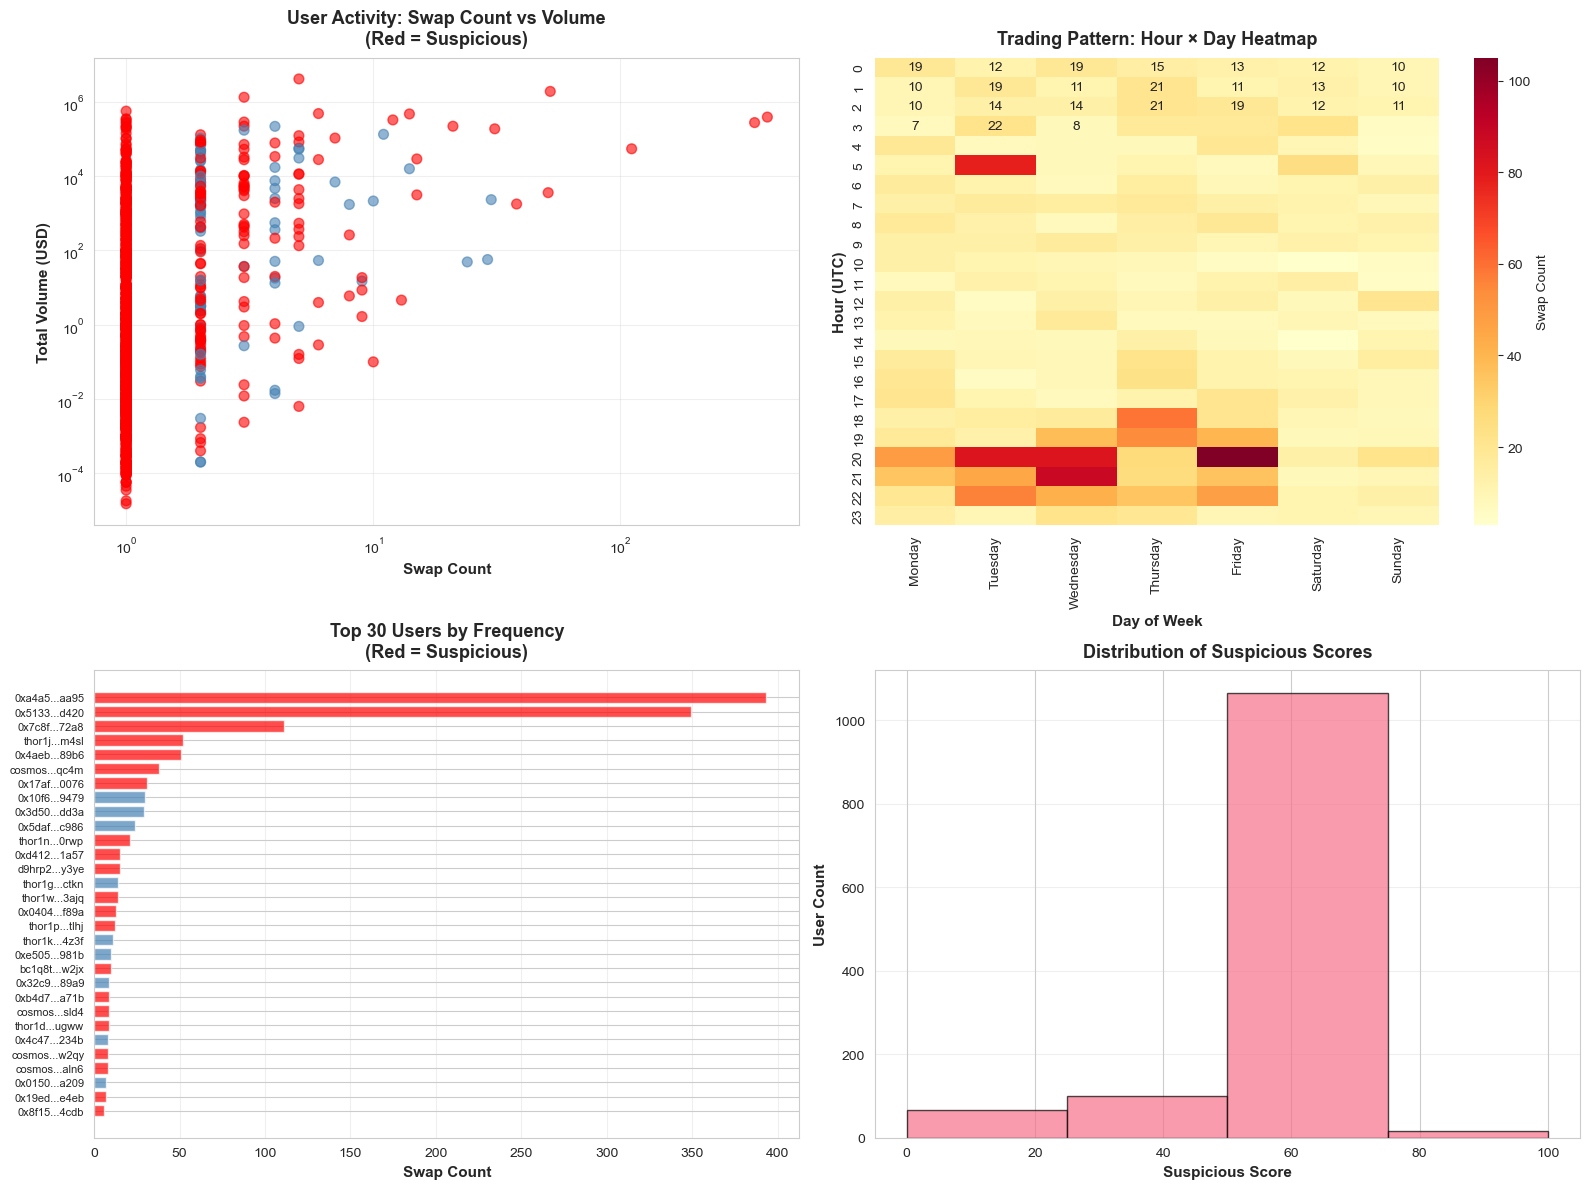

FRAUD/ABUSE DETECTION ANALYSIS
Users flagged as suspicious: 1,182 (94.6%)
Suspicious volume: $16,118,186.29 (93.2% of total)
Real volume: $1,175,548.05

Estimated fraudulent volume: $16,118,186.29
Estimated savings (if excluded): $48,354.56 in affiliate payments

Top 10 Suspicious Users:
  #1: thor1z...43hq - Score: 75, Volume: $95,727.90, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #2: 0x1f41...5d39 - Score: 75, Volume: $0.00, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #3: 37ftq9...99dm - Score: 75, Volume: $1.00, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #4: thor1e...r8k8 - Score: 75, Volume: $84,584.00, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #5: 0xe068.

In [ ]:
# CELL 12: Fraud/Abuse Detection

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Calculate user behavior metrics
    user_behavior = analysis_df.groupby(user_col).agg({
        'timestamp': ['min', 'max', 'count'],
        'from_amount': ['sum', 'mean'],
        'asset_pair': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,
        'to_amount': 'mean'
    }).reset_index()
    user_behavior.columns = [user_col, 'first_trade', 'last_trade', 'swap_count', 
                            'total_volume', 'avg_swap_size', 'most_common_pair', 'avg_to_amount']
    
    # Calculate time-based metrics
    user_behavior['time_span_hours'] = (user_behavior['last_trade'] - user_behavior['first_trade']).dt.total_seconds() / 3600
    user_behavior['swaps_per_hour'] = user_behavior['swap_count'] / user_behavior['time_span_hours'].replace(0, 1)
    
    # Flag suspicious patterns
    suspicious_flags = []
    
    # Flag 1: >100 swaps in 24h
    flag1 = user_behavior['swaps_per_hour'] > 100/24
    suspicious_flags.append(('High Frequency (>100 swaps/24h)', flag1))
    
    # Flag 2: Same pair 50+ times consecutively (check if most common pair is >50% of swaps)
    if 'asset_pair' in analysis_df.columns:
        pair_counts = analysis_df.groupby([user_col, 'asset_pair']).size().reset_index(name='pair_count')
        user_total_swaps = analysis_df.groupby(user_col).size().reset_index(name='total_swaps')
        pair_counts = pair_counts.merge(user_total_swaps, on=user_col)
        pair_counts['pair_pct'] = (pair_counts['pair_count'] / pair_counts['total_swaps'] * 100)
        flag2_users = pair_counts[pair_counts['pair_pct'] > 50]['from_address'].unique() if user_col == 'from_address' else pair_counts[pair_counts['pair_pct'] > 50][user_col].unique()
        flag2 = user_behavior[user_col].isin(flag2_users)
        suspicious_flags.append(('Same Pair Repetition (>50%)', flag2))
    else:
        flag2 = pd.Series([False] * len(user_behavior))
        suspicious_flags.append(('Same Pair Repetition (>50%)', flag2))
    
    # Flag 3: Unusually low slippage (<0.01%) - might indicate wash trading
    user_behavior['slippage_pct'] = abs((user_behavior['avg_swap_size'] - user_behavior['avg_to_amount']) / user_behavior['avg_swap_size'] * 100)
    flag3 = (user_behavior['slippage_pct'] < 0.01) & (user_behavior['swap_count'] > 10)
    suspicious_flags.append(('Suspiciously Low Slippage (<0.01%)', flag3))
    
    # Flag 4: >50% of swaps in same UTC hour (bot pattern)
    if 'timestamp' in analysis_df.columns:
        analysis_df['hour'] = pd.to_datetime(analysis_df['timestamp']).dt.hour
        hour_dist = analysis_df.groupby([user_col, 'hour']).size().reset_index(name='hour_count')
        user_hour_totals = analysis_df.groupby(user_col).size().reset_index(name='total')
        hour_dist = hour_dist.merge(user_hour_totals, on=user_col)
        hour_dist['hour_pct'] = (hour_dist['hour_count'] / hour_dist['total'] * 100)
        flag4_users = hour_dist[hour_dist['hour_pct'] > 50][user_col].unique()
        flag4 = user_behavior[user_col].isin(flag4_users)
        suspicious_flags.append(('Hour Clustering (>50% same hour)', flag4))
    else:
        flag4 = pd.Series([False] * len(user_behavior))
        suspicious_flags.append(('Hour Clustering (>50% same hour)', flag4))
    
    # Calculate confidence scores
    user_behavior['suspicious_score'] = 0
    user_behavior['behavior_types'] = ''
    
    for flag_name, flag_mask in suspicious_flags:
        user_behavior.loc[flag_mask, 'suspicious_score'] += 25
        user_behavior.loc[flag_mask, 'behavior_types'] = user_behavior.loc[flag_mask, 'behavior_types'].apply(
            lambda x: x + f", {flag_name}" if x else flag_name
        )
    
    # Mark suspicious users
    suspicious_users = user_behavior[user_behavior['suspicious_score'] >= 25].copy()
    suspicious_users = suspicious_users.sort_values('suspicious_score', ascending=False)
    
    # Calculate estimated fraudulent volume
    if len(suspicious_users) > 0:
        suspicious_volume = suspicious_users['total_volume'].sum()
        total_volume = user_behavior['total_volume'].sum()
        suspicious_pct = (suspicious_volume / total_volume * 100) if total_volume > 0 else 0
        
        # Estimate savings (assuming 0.3% affiliate fee)
        estimated_savings = suspicious_volume * 0.003
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Scatter (user vs swap_count, highlight suspicious)
        colors_scatter = ['red' if score >= 25 else 'steelblue' for score in user_behavior['suspicious_score']]
        ax1.scatter(user_behavior['swap_count'], user_behavior['total_volume'], 
                   c=colors_scatter, alpha=0.6, s=50)
        ax1.set_xlabel('Swap Count', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax1.set_title('User Activity: Swap Count vs Volume\n(Red = Suspicious)', fontsize=13, fontweight='bold', pad=10)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        # Top-right: Heatmap (hour × day_of_week showing clustering)
        if 'hour' in analysis_df.columns and 'day_of_week' in analysis_df.columns:
            time_cluster = analysis_df.groupby(['hour', 'day_of_week']).size().reset_index(name='count')
            time_pivot = time_cluster.pivot(index='hour', columns='day_of_week', values='count').fillna(0)
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            time_pivot = time_pivot.reindex(columns=[d for d in day_order if d in time_pivot.columns], fill_value=0)
            sns.heatmap(time_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Swap Count'})
            ax2.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Hour (UTC)', fontsize=11, fontweight='bold')
            ax2.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold', pad=10)
        else:
            ax2.text(0.5, 0.5, 'Time data not available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold')
        
        # Bottom-left: Bar (top 30 users by frequency, highlight suspicious)
        top_30 = user_behavior.nlargest(30, 'swap_count')
        colors_bars = ['red' if score >= 25 else 'steelblue' for score in top_30['suspicious_score']]
        bars = ax3.barh(range(len(top_30)), top_30['swap_count'], color=colors_bars, alpha=0.7)
        ax3.set_yticks(range(len(top_30)))
        # Anonymize addresses
        top_30['user_id'] = top_30[user_col].apply(lambda x: f"{str(x)[:6]}...{str(x)[-4:]}" if len(str(x)) > 10 else str(x))
        ax3.set_yticklabels(top_30['user_id'], fontsize=8)
        ax3.set_xlabel('Swap Count', fontsize=11, fontweight='bold')
        ax3.set_title('Top 30 Users by Frequency\n(Red = Suspicious)', fontsize=13, fontweight='bold', pad=10)
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3, axis='x')
        
        # Bottom-right: Suspicious score distribution
        ax4.hist(user_behavior['suspicious_score'], bins=range(0, 125, 25), edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Suspicious Score', fontsize=11, fontweight='bold')
        ax4.set_ylabel('User Count', fontsize=11, fontweight='bold')
        ax4.set_title('Distribution of Suspicious Scores', fontsize=13, fontweight='bold', pad=10)
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("FRAUD/ABUSE DETECTION ANALYSIS")
        print("=" * 70)
        print(f"Users flagged as suspicious: {len(suspicious_users):,} ({len(suspicious_users)/len(user_behavior)*100:.1f}%)")
        print(f"Suspicious volume: ${suspicious_volume:,.2f} ({suspicious_pct:.1f}% of total)")
        print(f"Real volume: ${total_volume - suspicious_volume:,.2f}")
        print(f"\nEstimated fraudulent volume: ${suspicious_volume:,.2f}")
        print(f"Estimated savings (if excluded): ${estimated_savings:,.2f} in affiliate payments")
        
        print(f"\nTop 10 Suspicious Users:")
        for i, (idx, row) in enumerate(suspicious_users.head(10).iterrows()):
            user_id = f"{str(row[user_col])[:6]}...{str(row[user_col])[-4:]}" if len(str(row[user_col])) > 10 else str(row[user_col])
            print(f"  #{i+1}: {user_id} - Score: {row['suspicious_score']}, Volume: ${row['total_volume']:,.2f}, Swaps: {row['swap_count']}")
            print(f"         Behaviors: {row['behavior_types']}")
        
        print("=" * 70)
    else:
        print("✓ No suspicious users detected")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 8: User Acquisition & Cohort Retention

**Business Impact:** Is the channel sustainable?

**Goal:** Perform cohort retention analysis to show user engagement over time.


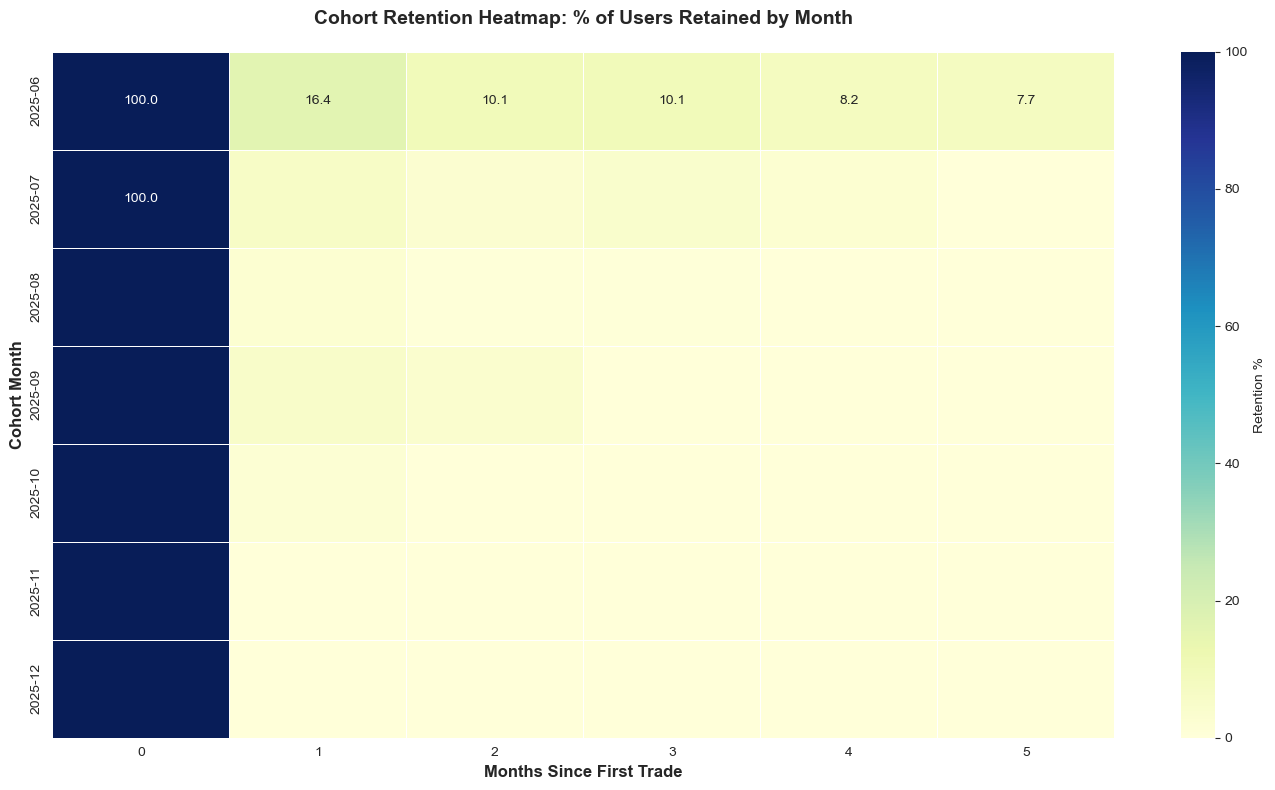

USER ACQUISITION & COHORT RETENTION ANALYSIS

2025-06 cohort:
  First month cohort size: 207 users
  Month 2 retention: 34 users (16.4% retained)

2025-07 cohort:
  First month cohort size: 322 users
  Month 2 retention: 20 users (6.2% retained)

2025-08 cohort:
  First month cohort size: 170 users
  Month 2 retention: 4 users (2.4% retained)

2025-09 cohort:
  First month cohort size: 188 users
  Month 2 retention: 10 users (5.3% retained)

2025-10 cohort:
  First month cohort size: 182 users
  Month 2 retention: 4 users (2.2% retained)

2025-11 cohort:
  First month cohort size: 166 users
  Month 2 retention: No data

2025-12 cohort:
  First month cohort size: 14 users
  Month 2 retention: No data

Overall Statistics:
  Average Month 2 retention: 6.5%
  Average Month 3+ retention: 4.6%


In [ ]:
# CELL 8: User Acquisition & Cohort Retention

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Filter to valid timestamps
    retention_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(retention_df) > 0:
        # Calculate first trade date per user (cohort month)
        user_first_trade = retention_df.groupby(user_col)['timestamp'].min().reset_index()
        user_first_trade.columns = [user_col, 'first_trade_date']
        user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
        
        # Merge back to main dataframe
        retention_df = retention_df.merge(user_first_trade, on=user_col, how='left')
        retention_df['trade_month'] = pd.to_datetime(retention_df['timestamp']).dt.to_period('M').astype(str)
        
        # Calculate months since first trade
        def calculate_months_diff(row):
            """Calculate months difference between two period strings"""
            try:
                if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                    return 0
                trade_period = pd.Period(row['trade_month'])
                cohort_period = pd.Period(row['cohort_month'])
                return (trade_period - cohort_period).n
            except:
                return 0
        
        retention_df['months_since_first'] = retention_df.apply(calculate_months_diff, axis=1)
        
        # Create cohort retention table
        cohort_retention = retention_df.groupby(['cohort_month', 'months_since_first'])[user_col].nunique().reset_index()
        cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
        
        # Get first month cohort size for each cohort
        first_month_size = cohort_retention[cohort_retention['months_since_first'] == 0].set_index('cohort_month')['user_count']
        
        # Calculate retention percentage
        cohort_retention = cohort_retention.merge(first_month_size.reset_index(), on='cohort_month', how='left', suffixes=('', '_first'))
        cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count', 'first_month_size']
        cohort_retention['retention_pct'] = (cohort_retention['user_count'] / cohort_retention['first_month_size'] * 100).round(1)
        
        # Pivot for heatmap
        cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='retention_pct').fillna(0)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create heatmap with retention percentages
        sns.heatmap(cohort_pivot, annot=True, fmt='.1f', cmap='YlGnBu', 
                    cbar_kws={'label': 'Retention %'}, ax=ax, linewidths=0.5, vmin=0, vmax=100)
        ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
        ax.set_title('Cohort Retention Heatmap: % of Users Retained by Month', 
                    fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate summary statistics
        month_2_retention = cohort_retention[cohort_retention['months_since_first'] == 1]['retention_pct'].mean()
        month_3_plus_retention = cohort_retention[cohort_retention['months_since_first'] >= 2]['retention_pct'].mean()
        
        # Print summary
        print("=" * 70)
        print("USER ACQUISITION & COHORT RETENTION ANALYSIS")
        print("=" * 70)
        
        # Show cohort breakdown
        for cohort in sorted(cohort_retention['cohort_month'].unique()):
            cohort_data = cohort_retention[cohort_retention['cohort_month'] == cohort].sort_values('months_since_first')
            first_month_size = cohort_data[cohort_data['months_since_first'] == 0]['user_count'].iloc[0] if len(cohort_data[cohort_data['months_since_first'] == 0]) > 0 else 0
            
            if first_month_size > 0:
                month_2_data = cohort_data[cohort_data['months_since_first'] == 1]
                month_2_count = month_2_data['user_count'].iloc[0] if len(month_2_data) > 0 else 0
                month_2_pct = month_2_data['retention_pct'].iloc[0] if len(month_2_data) > 0 else 0
                
                print(f"\n{cohort} cohort:")
                print(f"  First month cohort size: {first_month_size:,} users")
                if month_2_count > 0:
                    print(f"  Month 2 retention: {month_2_count:,} users ({month_2_pct:.1f}% retained)")
                else:
                    print(f"  Month 2 retention: No data")
        
        print(f"\nOverall Statistics:")
        print(f"  Average Month 2 retention: {month_2_retention:.1f}%")
        print(f"  Average Month 3+ retention: {month_3_plus_retention:.1f}%")
        
        # Trend analysis
        if len(cohort_pivot) >= 2:
            recent_cohorts = cohort_pivot.tail(2)
            if len(recent_cohorts.columns) >= 2:
                recent_month2 = recent_cohorts.iloc[-1].get(1, 0)
                prev_month2 = recent_cohorts.iloc[-2].get(1, 0) if len(recent_cohorts) >= 2 else 0
                if prev_month2 > 0:
                    trend = "improving" if recent_month2 > prev_month2 else "declining"
                    print(f"\nTrend: Month 2 retention is {trend} ({prev_month2:.1f}% → {recent_month2:.1f}%)")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for retention analysis")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 9: Slippage & Execution Quality Analysis

**Business Impact:** Is execution competitive? Are users getting good prices?

**Goal:** Analyze swap execution quality and slippage to assess competitiveness.


⚠ WARNING: USD values not available. Attempting fallback calculation...
⚠ NOTE: This calculation may be inaccurate if amounts are in different asset units
⚠ Using raw amounts (median: $100) - assuming USD values
✓ Analyzing 2,899 transactions with valid slippage data


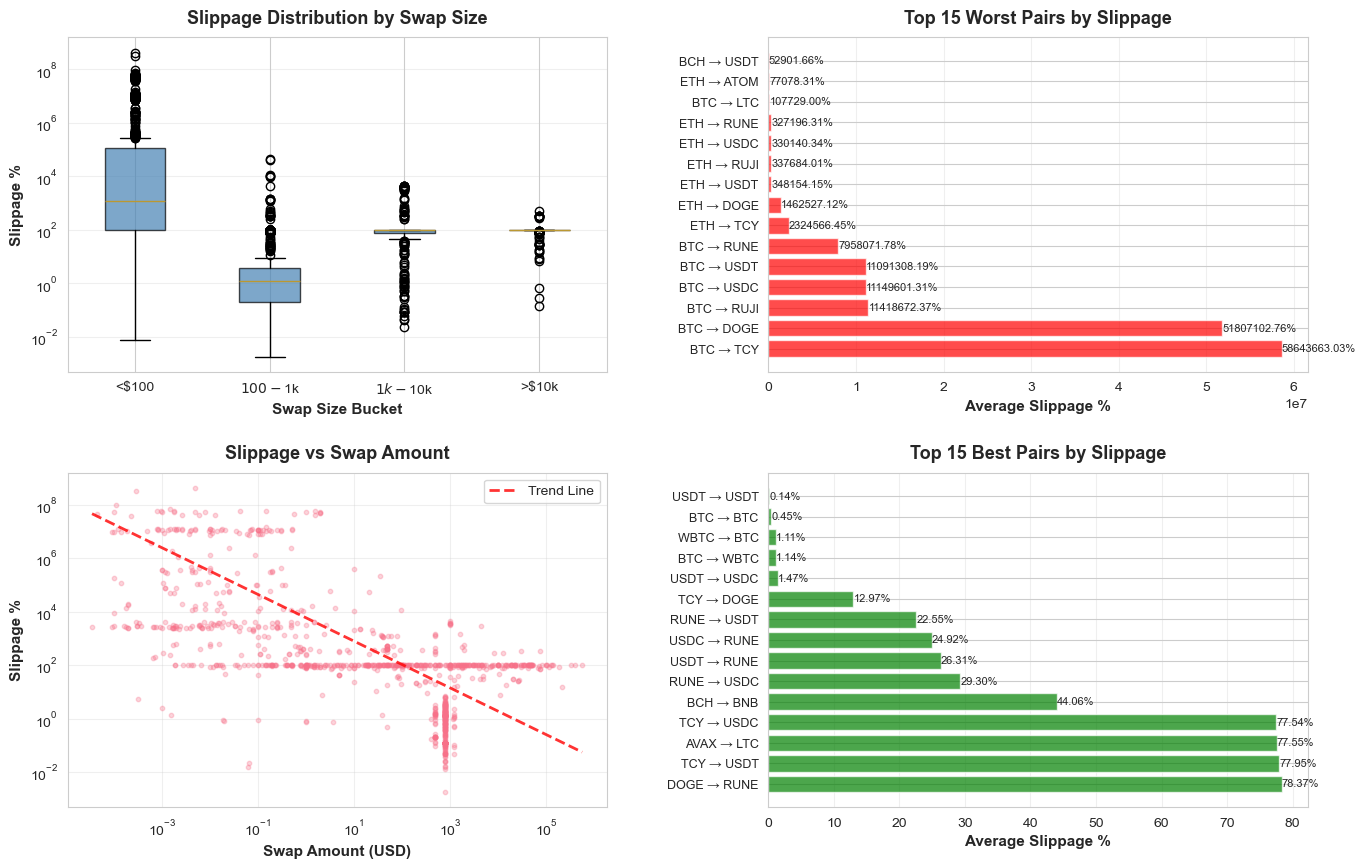

SLIPPAGE & EXECUTION QUALITY ANALYSIS

Total transactions analyzed: 2,899
Transactions excluded (invalid slippage): 0

Slippage by Swap Size (with transaction counts):
  Bucket  Transactions  Median Slippage %  Mean Slippage %    Std Dev %
$100-$1k           965           1.274447     1.652582e+02 2.051367e+03
$1k-$10k           276          99.948444     3.767143e+02 9.669388e+02
   >$10k           223          99.994668     9.993467e+01 5.572527e+01
   <$100          1435        1192.689529     4.056250e+06 1.751354e+07

Overall Statistics:
  Median slippage: 99.80%
  Mean slippage: 2007935.37%
  Large orders (>$10k) slippage: 99.99% (223 transactions)

Most volatile pair: BTC → TCY (avg slippage: 58643663.03%, 5 transactions)
Most stable pair: USDT → USDT (avg slippage: 0.14%, 148 transactions)


In [ ]:
# CELL 9: Slippage & Execution Quality Analysis

# IMPORTANT: Slippage must be calculated using USD values, not raw asset amounts
# Raw amounts are different assets (e.g., 1 ETH vs 0.05 BTC) and cannot be directly compared

if 'from_amount' in analysis_df.columns and 'to_amount' in analysis_df.columns:
    slippage_df = analysis_df[(analysis_df['from_amount'] > 0) & (analysis_df['to_amount'] > 0)].copy()
    
    # Check if USD values are available
    has_usd_values = 'from_amount_usd' in slippage_df.columns and 'to_amount_usd' in slippage_df.columns
    
    if has_usd_values:
        # Use USD values for accurate slippage calculation
        # Slippage = (input_value_usd - output_value_usd) / input_value_usd * 100
        # This represents the total "cost" including fees and price impact
        slippage_df['slippage_pct'] = abs(
            (slippage_df['from_amount_usd'] - slippage_df['to_amount_usd']) / 
            slippage_df['from_amount_usd'] * 100
        )
        print("✓ Using USD values for slippage calculation")
    else:
        # Fallback: Try to estimate using from_amount if it's already in USD
        # This is less accurate but better than comparing different assets
        print("⚠ WARNING: USD values not available. Attempting fallback calculation...")
        print("⚠ NOTE: This calculation may be inaccurate if amounts are in different asset units")
        
        # Check if from_amount appears to be in USD (reasonable range)
        # If most values are > 1 and < 10M, likely USD
        median_amount = slippage_df['from_amount'].median()
        if 1 < median_amount < 10_000_000:
            slippage_df['slippage_pct'] = abs(
                (slippage_df['from_amount'] - slippage_df['to_amount']) / 
                slippage_df['from_amount'] * 100
            )
            print(f"⚠ Using raw amounts (median: ${median_amount:,.0f}) - assuming USD values")
        else:
            print("✗ ERROR: Cannot calculate slippage - amounts appear to be in different asset units")
            print("✗ Please ensure 'from_amount_usd' and 'to_amount_usd' columns are available")
            slippage_df['slippage_pct'] = np.nan
    
    # Create swap size buckets
    def assign_size_bucket(amount):
        if amount < 100:
            return '<$100'
        elif amount < 1000:
            return '$100-$1k'
        elif amount < 10000:
            return '$1k-$10k'
        else:
            return '>$10k'
    
    # Use USD amount for bucket assignment if available
    amount_col = 'from_amount_usd' if has_usd_values and 'from_amount_usd' in slippage_df.columns else 'from_amount'
    slippage_df['swap_size_bucket'] = slippage_df[amount_col].apply(assign_size_bucket)
    
    # Filter out invalid slippage values (NaN)
    valid_slippage_df = slippage_df[slippage_df['slippage_pct'].notna()].copy()
    
    if len(valid_slippage_df) == 0:
        print("✗ ERROR: No valid slippage values calculated. Cannot proceed with analysis.")
        print("✗ Please check that USD values are available or amounts are in consistent units.")
    else:
        print(f"✓ Analyzing {len(valid_slippage_df):,} transactions with valid slippage data")
        
        # Analyze by bucket
        bucket_analysis = valid_slippage_df.groupby('swap_size_bucket').agg({
            'slippage_pct': ['median', 'mean', 'std', 'count']
        }).reset_index()
        bucket_analysis.columns = ['bucket', 'median_slippage', 'mean_slippage', 'std_slippage', 'transaction_count']
        bucket_analysis = bucket_analysis.sort_values('median_slippage')
    
        # Analyze by asset pair if available
        if 'asset_pair' in valid_slippage_df.columns:
            pair_slippage = valid_slippage_df.groupby('asset_pair').agg({
                'slippage_pct': 'mean',
                'from_amount': 'count'
            }).reset_index()
            pair_slippage.columns = ['asset_pair', 'avg_slippage', 'transaction_count']
            pair_slippage = pair_slippage[pair_slippage['transaction_count'] >= 5]  # Min 5 swaps for reliability
            pair_slippage = pair_slippage.sort_values('avg_slippage')
            
            worst_pairs = pair_slippage.tail(15)
            best_pairs = pair_slippage.head(15)
        else:
            worst_pairs = pd.DataFrame()
            best_pairs = pd.DataFrame()
        
        # Create visualizations
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # Top-left: Box plot (size vs slippage)
        ax1 = fig.add_subplot(gs[0, 0])
        bucket_order = ['<$100', '$100-$1k', '$1k-$10k', '>$10k']
        bucket_data = [valid_slippage_df[valid_slippage_df['swap_size_bucket'] == b]['slippage_pct'].values for b in bucket_order if b in valid_slippage_df['swap_size_bucket'].values]
        bucket_labels = [b for b in bucket_order if b in valid_slippage_df['swap_size_bucket'].values]
        bp = ax1.boxplot(bucket_data, labels=bucket_labels, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('steelblue')
            patch.set_alpha(0.7)
        ax1.set_xlabel('Swap Size Bucket', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Slippage %', fontsize=11, fontweight='bold')
        ax1.set_title('Slippage Distribution by Swap Size', fontsize=13, fontweight='bold', pad=10)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_yscale('log')
        
        # Top-right: Bar chart (worst pairs)
        ax2 = fig.add_subplot(gs[0, 1])
        if len(worst_pairs) > 0:
            bars = ax2.barh(range(len(worst_pairs)), worst_pairs['avg_slippage'], color='red', alpha=0.7)
            ax2.set_yticks(range(len(worst_pairs)))
            ax2.set_yticklabels(worst_pairs['asset_pair'], fontsize=9)
            ax2.set_xlabel('Average Slippage %', fontsize=11, fontweight='bold')
            ax2.set_title('Top 15 Worst Pairs by Slippage', fontsize=13, fontweight='bold', pad=10)
            ax2.invert_yaxis()
            ax2.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (idx, row) in enumerate(worst_pairs.iterrows()):
                ax2.text(row['avg_slippage'], i, f'{row["avg_slippage"]:.2f}%', 
                        va='center', ha='left', fontsize=8)
        else:
            ax2.text(0.5, 0.5, 'Insufficient pair data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Top 15 Worst Pairs by Slippage', fontsize=13, fontweight='bold')
    
        # Bottom-left: Scatter (amount vs slippage with trend)
        ax3 = fig.add_subplot(gs[1, 0])
        sample_size = min(1000, len(valid_slippage_df))
        sample_df = valid_slippage_df.sample(n=sample_size, random_state=42) if len(valid_slippage_df) > sample_size else valid_slippage_df
        scatter_amount_col = amount_col
        ax3.scatter(sample_df[scatter_amount_col], sample_df['slippage_pct'], alpha=0.3, s=10)
        
        # Add trend line
        if len(sample_df) > 10:
            z = np.polyfit(np.log(sample_df[scatter_amount_col] + 1), np.log(sample_df['slippage_pct'] + 0.01), 1)
            p = np.poly1d(z)
            x_trend = np.logspace(np.log10(sample_df[scatter_amount_col].min()), np.log10(sample_df[scatter_amount_col].max()), 100)
            y_trend = np.exp(p(np.log(x_trend)))
            ax3.plot(x_trend, y_trend, "r--", alpha=0.8, linewidth=2, label='Trend Line')
        
        ax3.set_xlabel('Swap Amount (USD)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Slippage %', fontsize=11, fontweight='bold')
        ax3.set_title('Slippage vs Swap Amount', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    
        # Bottom-right: Best pairs
        ax4 = fig.add_subplot(gs[1, 1])
        if len(best_pairs) > 0:
            bars = ax4.barh(range(len(best_pairs)), best_pairs['avg_slippage'], color='green', alpha=0.7)
            ax4.set_yticks(range(len(best_pairs)))
            ax4.set_yticklabels(best_pairs['asset_pair'], fontsize=9)
            ax4.set_xlabel('Average Slippage %', fontsize=11, fontweight='bold')
            ax4.set_title('Top 15 Best Pairs by Slippage', fontsize=13, fontweight='bold', pad=10)
            ax4.invert_yaxis()
            ax4.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (idx, row) in enumerate(best_pairs.iterrows()):
                ax4.text(row['avg_slippage'], i, f'{row["avg_slippage"]:.2f}%', 
                        va='center', ha='left', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'Insufficient pair data', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Top 15 Best Pairs by Slippage', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
        # Print summary
        print("=" * 70)
        print("SLIPPAGE & EXECUTION QUALITY ANALYSIS")
        print("=" * 70)
        
        print(f"\nTotal transactions analyzed: {len(valid_slippage_df):,}")
        print(f"Transactions excluded (invalid slippage): {len(slippage_df) - len(valid_slippage_df):,}")
        
        print("\nSlippage by Swap Size (with transaction counts):")
        display_bucket = bucket_analysis[['bucket', 'transaction_count', 'median_slippage', 'mean_slippage', 'std_slippage']].copy()
        display_bucket.columns = ['Bucket', 'Transactions', 'Median Slippage %', 'Mean Slippage %', 'Std Dev %']
        print(display_bucket.to_string(index=False))
        
        overall_median = valid_slippage_df['slippage_pct'].median()
        overall_mean = valid_slippage_df['slippage_pct'].mean()
        large_order_data = valid_slippage_df[valid_slippage_df['swap_size_bucket'] == '>$10k']
        large_order_slippage = large_order_data['slippage_pct'].median() if len(large_order_data) > 0 else None
        large_order_count = len(large_order_data)
        
        print(f"\nOverall Statistics:")
        print(f"  Median slippage: {overall_median:.2f}%")
        print(f"  Mean slippage: {overall_mean:.2f}%")
        if large_order_slippage is not None:
            print(f"  Large orders (>$10k) slippage: {large_order_slippage:.2f}% ({large_order_count:,} transactions)")
        
        if len(worst_pairs) > 0:
            worst_pair = worst_pairs.iloc[-1]
            print(f"\nMost volatile pair: {worst_pair['asset_pair']} (avg slippage: {worst_pair['avg_slippage']:.2f}%, {worst_pair['transaction_count']:.0f} transactions)")
        
        if len(best_pairs) > 0:
            best_pair = best_pairs.iloc[0]
            print(f"Most stable pair: {best_pair['asset_pair']} (avg slippage: {best_pair['avg_slippage']:.2f}%, {best_pair['transaction_count']:.0f} transactions)")
        
        print("=" * 70)
else:
    print("⚠ Missing required columns: 'from_amount' and/or 'to_amount'")


### CELL 11: Competitor Partner Benchmarking

**Business Impact:** How do we compare to CoW Swap, Relay, 1inch?

**Goal:** Compare THORChain performance against other affiliate partners.


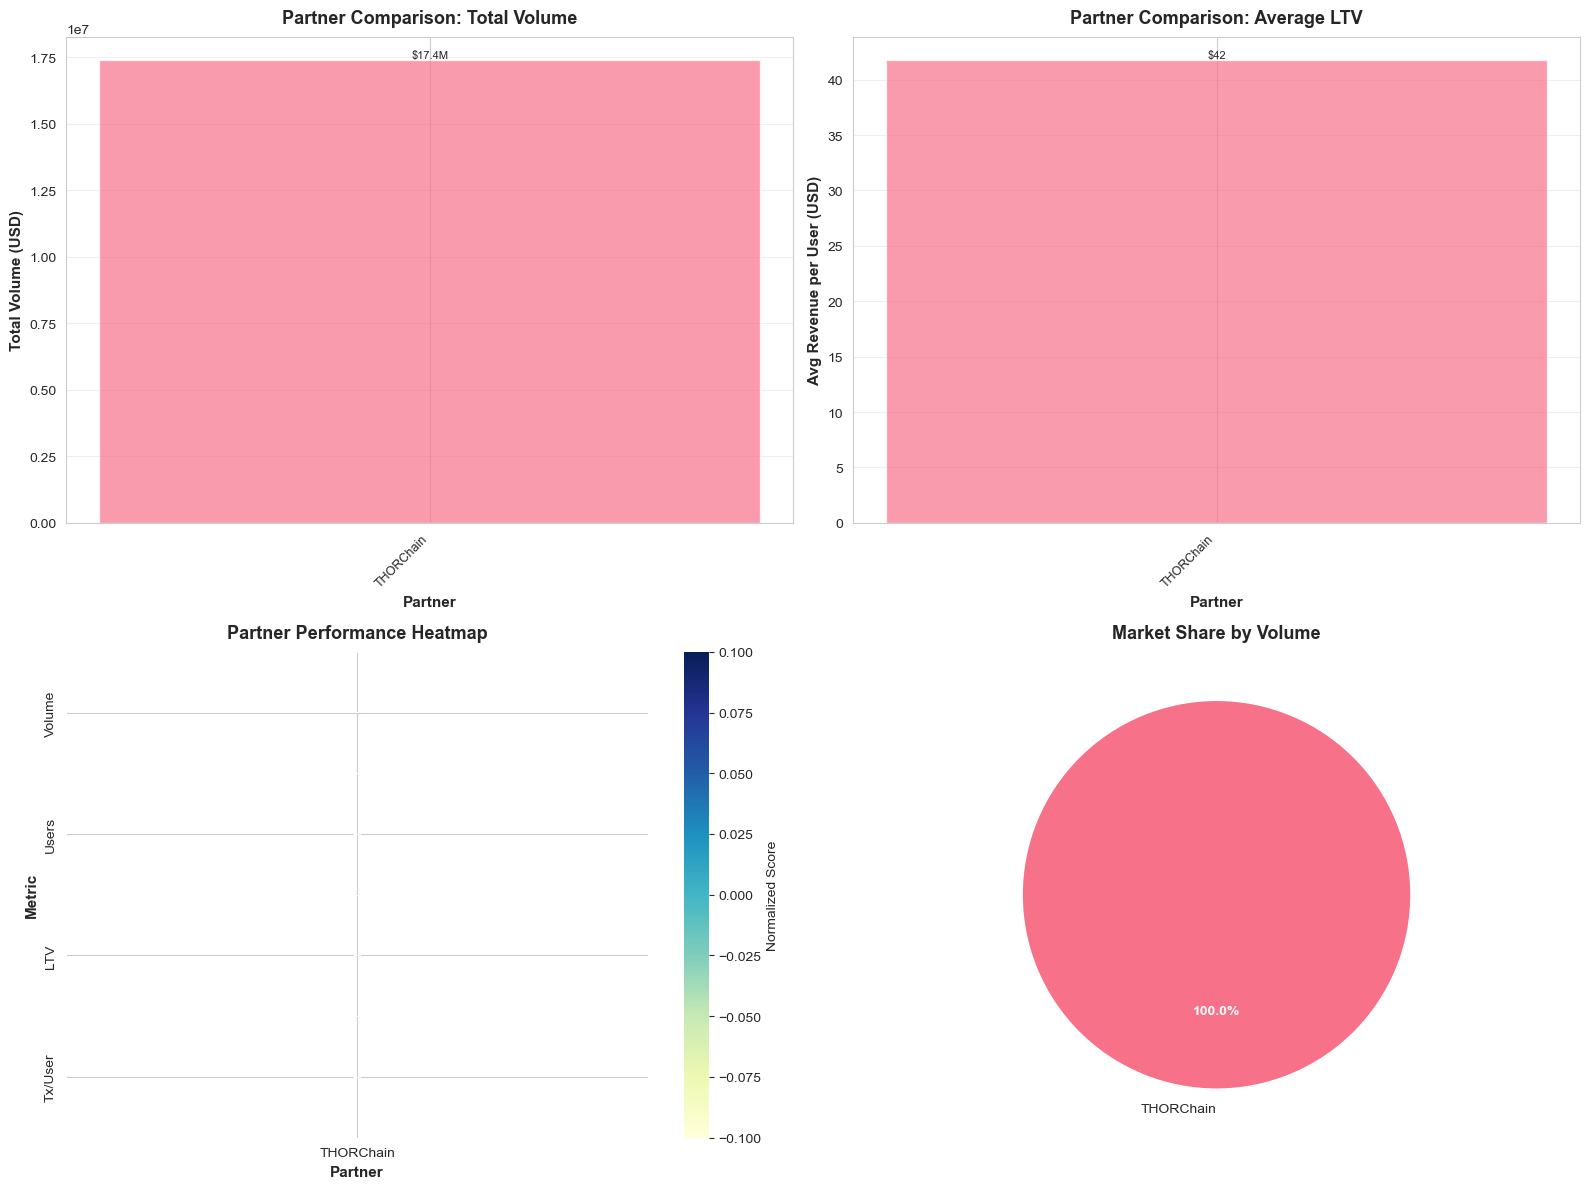

COMPETITOR PARTNER BENCHMARKING

Partner Performance Table:
partner_name  total_volume  user_count   total_fees  avg_revenue_per_user  transactions_per_user  rank_by_volume  rank_by_ltv
   THORChain  1.739078e+07        1249 52172.351992             41.771299               2.321057               1            1

THORChain Performance:
  Rank by volume: #1
  Rank by LTV: #1
  Rank by users: #1
  Market share: 100.0%
  Avg revenue per user: $41.77
  ✓ Strong volume performance (top 2)
  ✓ Strong user quality (top 2)


In [ ]:
# CELL 11: Competitor Partner Benchmarking

# Check if partner_name exists, otherwise use source_file as proxy
if 'partner_name' in analysis_df.columns:
    partner_col = 'partner_name'
elif 'source_file' in analysis_df.columns:
    # Extract partner from source_file if it contains partner info
    analysis_df['partner_name'] = 'THORChain'  # Default to THORChain
    partner_col = 'partner_name'
    print("⚠ Using default partner_name='THORChain'. Add 'partner_name' column for multi-partner comparison.")
else:
    partner_col = None
    print("⚠ No partner_name or source_file column found. Creating single-partner analysis.")

if partner_col and partner_col in analysis_df.columns:
    user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'
    
    # Group by partner and calculate metrics
    partner_stats = analysis_df.groupby(partner_col).agg({
        'from_amount': ['sum', 'count', 'mean'],
        'fee_usd': 'sum',
        user_col: 'nunique' if user_col in analysis_df.columns else 'count'
    }).reset_index()
    
    partner_stats.columns = [partner_col, 'total_volume', 'transaction_count', 'avg_transaction_size', 
                            'total_fees', 'user_count']
    
    # Calculate additional metrics
    partner_stats['avg_revenue_per_user'] = partner_stats['total_fees'] / partner_stats['user_count'].replace(0, 1)
    partner_stats['transactions_per_user'] = partner_stats['transaction_count'] / partner_stats['user_count'].replace(0, 1)
    
    # Calculate market share
    total_volume_all = partner_stats['total_volume'].sum()
    total_fees_all = partner_stats['total_fees'].sum()
    partner_stats['volume_market_share'] = (partner_stats['total_volume'] / total_volume_all * 100).round(2)
    partner_stats['fees_market_share'] = (partner_stats['total_fees'] / total_fees_all * 100).round(2)
    
    # Rank partners by each metric
    partner_stats['rank_by_volume'] = partner_stats['total_volume'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_fees'] = partner_stats['total_fees'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_ltv'] = partner_stats['avg_revenue_per_user'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_users'] = partner_stats['user_count'].rank(ascending=False, method='min').astype(int)
    
    partner_stats = partner_stats.sort_values('total_volume', ascending=False)
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Bar chart (partner vs total_volume)
    bars1 = ax1.bar(range(len(partner_stats)), partner_stats['total_volume'], 
                    color=sns.color_palette("husl", len(partner_stats)), alpha=0.7)
    ax1.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
    ax1.set_title('Partner Comparison: Total Volume', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(len(partner_stats)))
    ax1.set_xticklabels(partner_stats[partner_col], rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(partner_stats.iterrows()):
        ax1.text(i, row['total_volume'], f'${row["total_volume"]/1e6:.1f}M', 
                ha='center', va='bottom', fontsize=8)
    
    # Top-right: Bar chart (partner vs avg_revenue_per_user)
    bars2 = ax2.bar(range(len(partner_stats)), partner_stats['avg_revenue_per_user'], 
                    color=sns.color_palette("husl", len(partner_stats)), alpha=0.7)
    ax2.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Avg Revenue per User (USD)', fontsize=11, fontweight='bold')
    ax2.set_title('Partner Comparison: Average LTV', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(partner_stats)))
    ax2.set_xticklabels(partner_stats[partner_col], rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(partner_stats.iterrows()):
        ax2.text(i, row['avg_revenue_per_user'], f'${row["avg_revenue_per_user"]:.0f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Bottom-left: Heatmap (partner × metrics)
    metrics_for_heatmap = partner_stats[['total_volume', 'user_count', 'avg_revenue_per_user', 'transactions_per_user']].copy()
    # Normalize for heatmap
    metrics_normalized = (metrics_for_heatmap - metrics_for_heatmap.min()) / (metrics_for_heatmap.max() - metrics_for_heatmap.min())
    metrics_normalized.index = partner_stats[partner_col]
    metrics_normalized.columns = ['Volume', 'Users', 'LTV', 'Tx/User']
    
    sns.heatmap(metrics_normalized.T, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax3, 
                cbar_kws={'label': 'Normalized Score'}, linewidths=0.5)
    ax3.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Metric', fontsize=11, fontweight='bold')
    ax3.set_title('Partner Performance Heatmap', fontsize=13, fontweight='bold', pad=10)
    
    # Bottom-right: Pie chart (market share)
    colors_pie = sns.color_palette("husl", len(partner_stats))
    wedges, texts, autotexts = ax4.pie(partner_stats['volume_market_share'], labels=partner_stats[partner_col], 
                                       autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax4.set_title('Market Share by Volume', fontsize=13, fontweight='bold', pad=10)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=" * 70)
    print("COMPETITOR PARTNER BENCHMARKING")
    print("=" * 70)
    
    print("\nPartner Performance Table:")
    display_cols = [partner_col, 'total_volume', 'user_count', 'total_fees', 'avg_revenue_per_user', 
                   'transactions_per_user', 'rank_by_volume', 'rank_by_ltv']
    print(partner_stats[display_cols].to_string(index=False))
    
    # Find THORChain ranking
    thorchain_data = partner_stats[partner_stats[partner_col].str.contains('THORChain', case=False, na=False)]
    if len(thorchain_data) > 0:
        thorchain = thorchain_data.iloc[0]
        print(f"\nTHORChain Performance:")
        print(f"  Rank by volume: #{thorchain['rank_by_volume']}")
        print(f"  Rank by LTV: #{thorchain['rank_by_ltv']}")
        print(f"  Rank by users: #{thorchain['rank_by_users']}")
        print(f"  Market share: {thorchain['volume_market_share']:.1f}%")
        print(f"  Avg revenue per user: ${thorchain['avg_revenue_per_user']:.2f}")
        
        # Comparison insights
        if thorchain['rank_by_volume'] <= 2:
            print(f"  ✓ Strong volume performance (top 2)")
        else:
            print(f"  ⚠ Volume ranking could be improved")
        
        if thorchain['rank_by_ltv'] <= 2:
            print(f"  ✓ Strong user quality (top 2)")
        else:
            print(f"  ⚠ User quality ranking could be improved")
    else:
        print("\n⚠ THORChain data not found in partner comparison")
    
    print("=" * 70)
else:
    print("⚠ Partner comparison requires 'partner_name' column or partner identification in source_file")


### CELL 15: User Engagement Lifecycle

**Business Impact:** When do users churn? Can we re-engage them?

**Goal:** Map user lifecycle stages and calculate engagement decay.


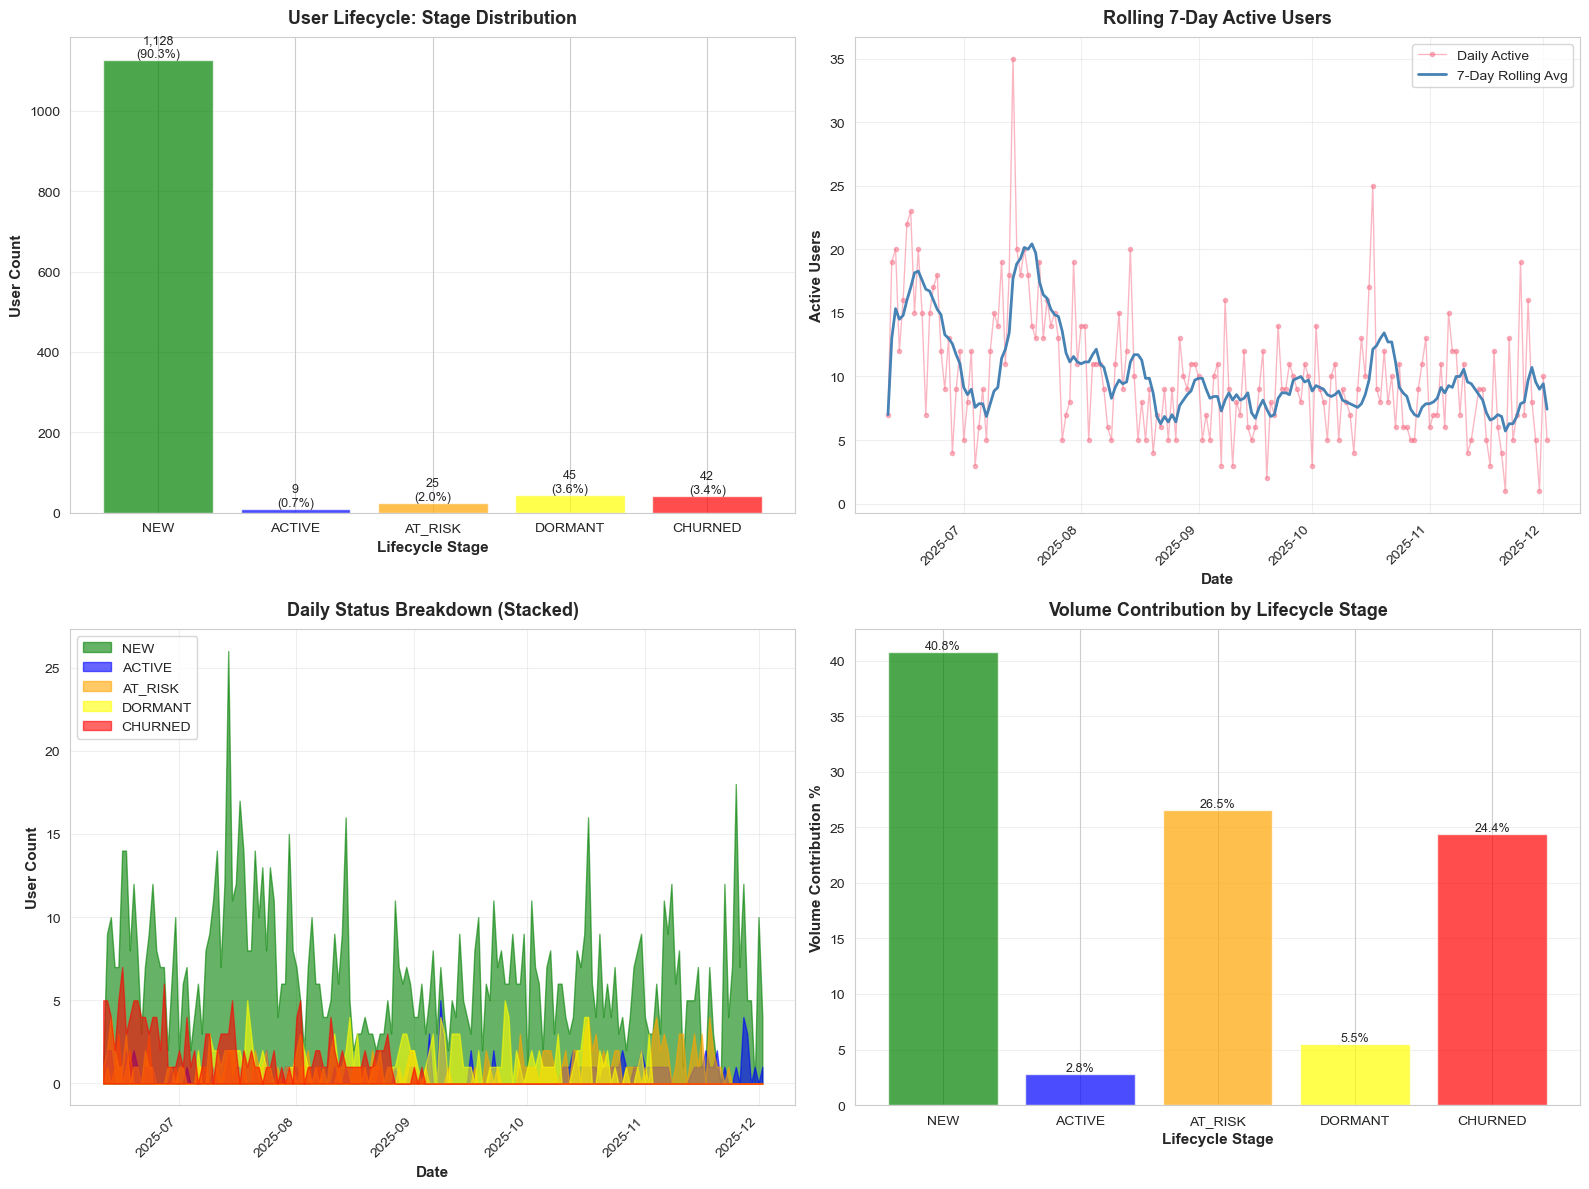

USER ENGAGEMENT LIFECYCLE ANALYSIS

Lifecycle Stage Breakdown:
  stage  user_count  pct_of_total  total_volume  volume_contribution_pct  avg_transactions  avg_days_active
    NEW        1128         90.31  7.052732e+06                    40.78          1.221631         0.078014
 ACTIVE           9          0.72  4.818773e+05                     2.79         15.555556       129.111111
AT_RISK          25          2.00  4.585716e+06                    26.52          7.080000        98.720000
DORMANT          45          3.60  9.576615e+05                     5.54          5.000000        75.244444
CHURNED          42          3.36  4.215747e+06                    24.38         22.761905        26.404762

Key Metrics:
  Median user lifetime: 0 days
  Median days to churn: 128 days
  Re-activation rate: 0.0%

⚠️ INTERVENTION ZONE:
  At-Risk users: 25 (2.0% of total)
  Volume contribution: 26.5%
  Recommendation: Target re-engagement campaigns for At-Risk segment


In [ ]:
# CELL 15: User Engagement Lifecycle

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Filter to valid timestamps
    lifecycle_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(lifecycle_df) > 0:
        # Calculate user lifecycle metrics
        user_lifecycle = lifecycle_df.groupby(user_col).agg({
            'timestamp': ['min', 'max', 'count'],
            'from_amount': 'sum'
        }).reset_index()
        user_lifecycle.columns = [user_col, 'first_trade_date', 'last_trade_date', 'transaction_count', 'total_volume']
        
        # Calculate time metrics
        now = pd.Timestamp.now()
        user_lifecycle['days_active'] = (user_lifecycle['last_trade_date'] - user_lifecycle['first_trade_date']).dt.days
        user_lifecycle['days_since_last_trade'] = (now - user_lifecycle['last_trade_date']).dt.days
        
        # Classify users by lifecycle stage
        def classify_lifecycle_stage(row):
            days_since_last = row['days_since_last_trade']
            days_active = row['days_active']
            
            if days_active < 7:
                return 'NEW'
            elif days_since_last < 7:
                return 'ACTIVE'
            elif days_since_last < 30:
                return 'AT_RISK'
            elif days_since_last < 90:
                return 'DORMANT'
            else:
                return 'CHURNED'
        
        user_lifecycle['lifecycle_stage'] = user_lifecycle.apply(classify_lifecycle_stage, axis=1)
        
        # Aggregate by stage
        stage_analysis = user_lifecycle.groupby('lifecycle_stage').agg({
            user_col: 'count',
            'total_volume': 'sum',
            'transaction_count': 'sum',
            'days_since_last_trade': 'mean',
            'days_active': 'mean'
        }).reset_index()
        stage_analysis.columns = ['stage', 'user_count', 'total_volume', 'total_transactions', 
                                 'avg_days_since_last', 'avg_days_active']
        
        total_users = user_lifecycle[user_col].nunique()
        stage_analysis['pct_of_total'] = (stage_analysis['user_count'] / total_users * 100).round(2)
        stage_analysis['volume_contribution_pct'] = (stage_analysis['total_volume'] / user_lifecycle['total_volume'].sum() * 100).round(2)
        stage_analysis['avg_transactions'] = stage_analysis['total_transactions'] / stage_analysis['user_count']
        
        # Calculate re-activation rate (users who moved from CHURNED back to ACTIVE)
        # This is simplified - would need historical tracking for accurate measurement
        churned_users = set(user_lifecycle[user_lifecycle['lifecycle_stage'] == 'CHURNED'][user_col])
        active_users = set(user_lifecycle[user_lifecycle['lifecycle_stage'] == 'ACTIVE'][user_col])
        reactivated = len(churned_users & active_users)  # Users in both sets
        reactivation_rate = (reactivated / len(churned_users) * 100) if len(churned_users) > 0 else 0
        
        # Sort by stage order
        stage_order = ['NEW', 'ACTIVE', 'AT_RISK', 'DORMANT', 'CHURNED']
        stage_analysis['stage_num'] = stage_analysis['stage'].apply(lambda x: stage_order.index(x) if x in stage_order else 999)
        stage_analysis = stage_analysis.sort_values('stage_num').reset_index(drop=True)
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Waterfall chart (NEW → ACTIVE → AT_RISK → DORMANT → CHURNED)
        x_pos = range(len(stage_analysis))
        colors_waterfall = {'NEW': 'green', 'ACTIVE': 'blue', 'AT_RISK': 'orange', 'DORMANT': 'yellow', 'CHURNED': 'red'}
        stage_colors = [colors_waterfall.get(stage, 'gray') for stage in stage_analysis['stage']]
        
        bars = ax1.bar(x_pos, stage_analysis['user_count'], color=stage_colors, alpha=0.7)
        ax1.set_xlabel('Lifecycle Stage', fontsize=11, fontweight='bold')
        ax1.set_ylabel('User Count', fontsize=11, fontweight='bold')
        ax1.set_title('User Lifecycle: Stage Distribution', fontsize=13, fontweight='bold', pad=10)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(stage_analysis['stage'], fontsize=10)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (idx, row) in enumerate(stage_analysis.iterrows()):
            ax1.text(i, row['user_count'], f"{row['user_count']:,}\n({row['pct_of_total']:.1f}%)", 
                    ha='center', va='bottom', fontsize=9)
        
        # Top-right: Line chart (rolling 7-day active users)
        if 'timestamp' in lifecycle_df.columns:
            lifecycle_df['date'] = pd.to_datetime(lifecycle_df['timestamp']).dt.date
            daily_active = lifecycle_df.groupby('date')[user_col].nunique().reset_index()
            daily_active.columns = ['date', 'active_users']
            daily_active['date'] = pd.to_datetime(daily_active['date'])
            daily_active = daily_active.sort_values('date')
            daily_active['rolling_7d'] = daily_active['active_users'].rolling(window=7, min_periods=1).mean()
            
            ax2.plot(daily_active['date'], daily_active['active_users'], 'o-', alpha=0.5, label='Daily Active', linewidth=1, markersize=3)
            ax2.plot(daily_active['date'], daily_active['rolling_7d'], '-', linewidth=2, label='7-Day Rolling Avg', color='steelblue')
            ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Active Users', fontsize=11, fontweight='bold')
            ax2.set_title('Rolling 7-Day Active Users', fontsize=13, fontweight='bold', pad=10)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            ax2.text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Rolling 7-Day Active Users', fontsize=13, fontweight='bold')
        
        # Bottom-left: Stacked area (daily status breakdown)
        if 'timestamp' in lifecycle_df.columns:
            # Calculate daily status counts
            lifecycle_df['date'] = pd.to_datetime(lifecycle_df['timestamp']).dt.date
            daily_status = []
            for date in sorted(lifecycle_df['date'].unique()):
                date_users = lifecycle_df[lifecycle_df['date'] == date][user_col].unique()
                date_lifecycle = user_lifecycle[user_lifecycle[user_col].isin(date_users)]
                status_counts = date_lifecycle['lifecycle_stage'].value_counts().to_dict()
                status_counts['date'] = date
                daily_status.append(status_counts)
            
            daily_status_df = pd.DataFrame(daily_status).fillna(0)
            daily_status_df['date'] = pd.to_datetime(daily_status_df['date'])
            daily_status_df = daily_status_df.sort_values('date')
            
            for stage in stage_order:
                if stage in daily_status_df.columns:
                    ax3.fill_between(daily_status_df['date'], 0, daily_status_df[stage], 
                                   label=stage, alpha=0.6, color=colors_waterfall.get(stage, 'gray'))
            
            ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax3.set_ylabel('User Count', fontsize=11, fontweight='bold')
            ax3.set_title('Daily Status Breakdown (Stacked)', fontsize=13, fontweight='bold', pad=10)
            ax3.legend(loc='upper left')
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            ax3.text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Daily Status Breakdown', fontsize=13, fontweight='bold')
        
        # Bottom-right: Volume contribution by stage
        ax4.bar(x_pos, stage_analysis['volume_contribution_pct'], color=stage_colors, alpha=0.7)
        ax4.set_xlabel('Lifecycle Stage', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Volume Contribution %', fontsize=11, fontweight='bold')
        ax4.set_title('Volume Contribution by Lifecycle Stage', fontsize=13, fontweight='bold', pad=10)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(stage_analysis['stage'], fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (idx, row) in enumerate(stage_analysis.iterrows()):
            ax4.text(i, row['volume_contribution_pct'], f"{row['volume_contribution_pct']:.1f}%", 
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("USER ENGAGEMENT LIFECYCLE ANALYSIS")
        print("=" * 70)
        
        print("\nLifecycle Stage Breakdown:")
        display_cols = ['stage', 'user_count', 'pct_of_total', 'total_volume', 'volume_contribution_pct', 
                       'avg_transactions', 'avg_days_active']
        print(stage_analysis[display_cols].to_string(index=False))
        
        # Calculate median metrics
        median_lifetime = user_lifecycle['days_active'].median()
        churned_users_data = user_lifecycle[user_lifecycle['lifecycle_stage'] == 'CHURNED']
        median_days_to_churn = churned_users_data['days_since_last_trade'].median() if len(churned_users_data) > 0 else None
        
        print(f"\nKey Metrics:")
        print(f"  Median user lifetime: {median_lifetime:.0f} days")
        if median_days_to_churn is not None:
            print(f"  Median days to churn: {median_days_to_churn:.0f} days")
        print(f"  Re-activation rate: {reactivation_rate:.1f}%")
        
        # Identify intervention zone
        at_risk_data = stage_analysis[stage_analysis['stage'] == 'AT_RISK']
        if len(at_risk_data) > 0:
            at_risk = at_risk_data.iloc[0]
            print(f"\n⚠️ INTERVENTION ZONE:")
            print(f"  At-Risk users: {at_risk['user_count']:,} ({at_risk['pct_of_total']:.1f}% of total)")
            print(f"  Volume contribution: {at_risk['volume_contribution_pct']:.1f}%")
            print(f"  Recommendation: Target re-engagement campaigns for At-Risk segment")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for lifecycle analysis")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 16: Comparative Pair Performance (Stability × Volume)

**Business Impact:** Which pairs to promote vs avoid?

**Goal:** Classify asset pairs into performance quadrants based on volume and stability.


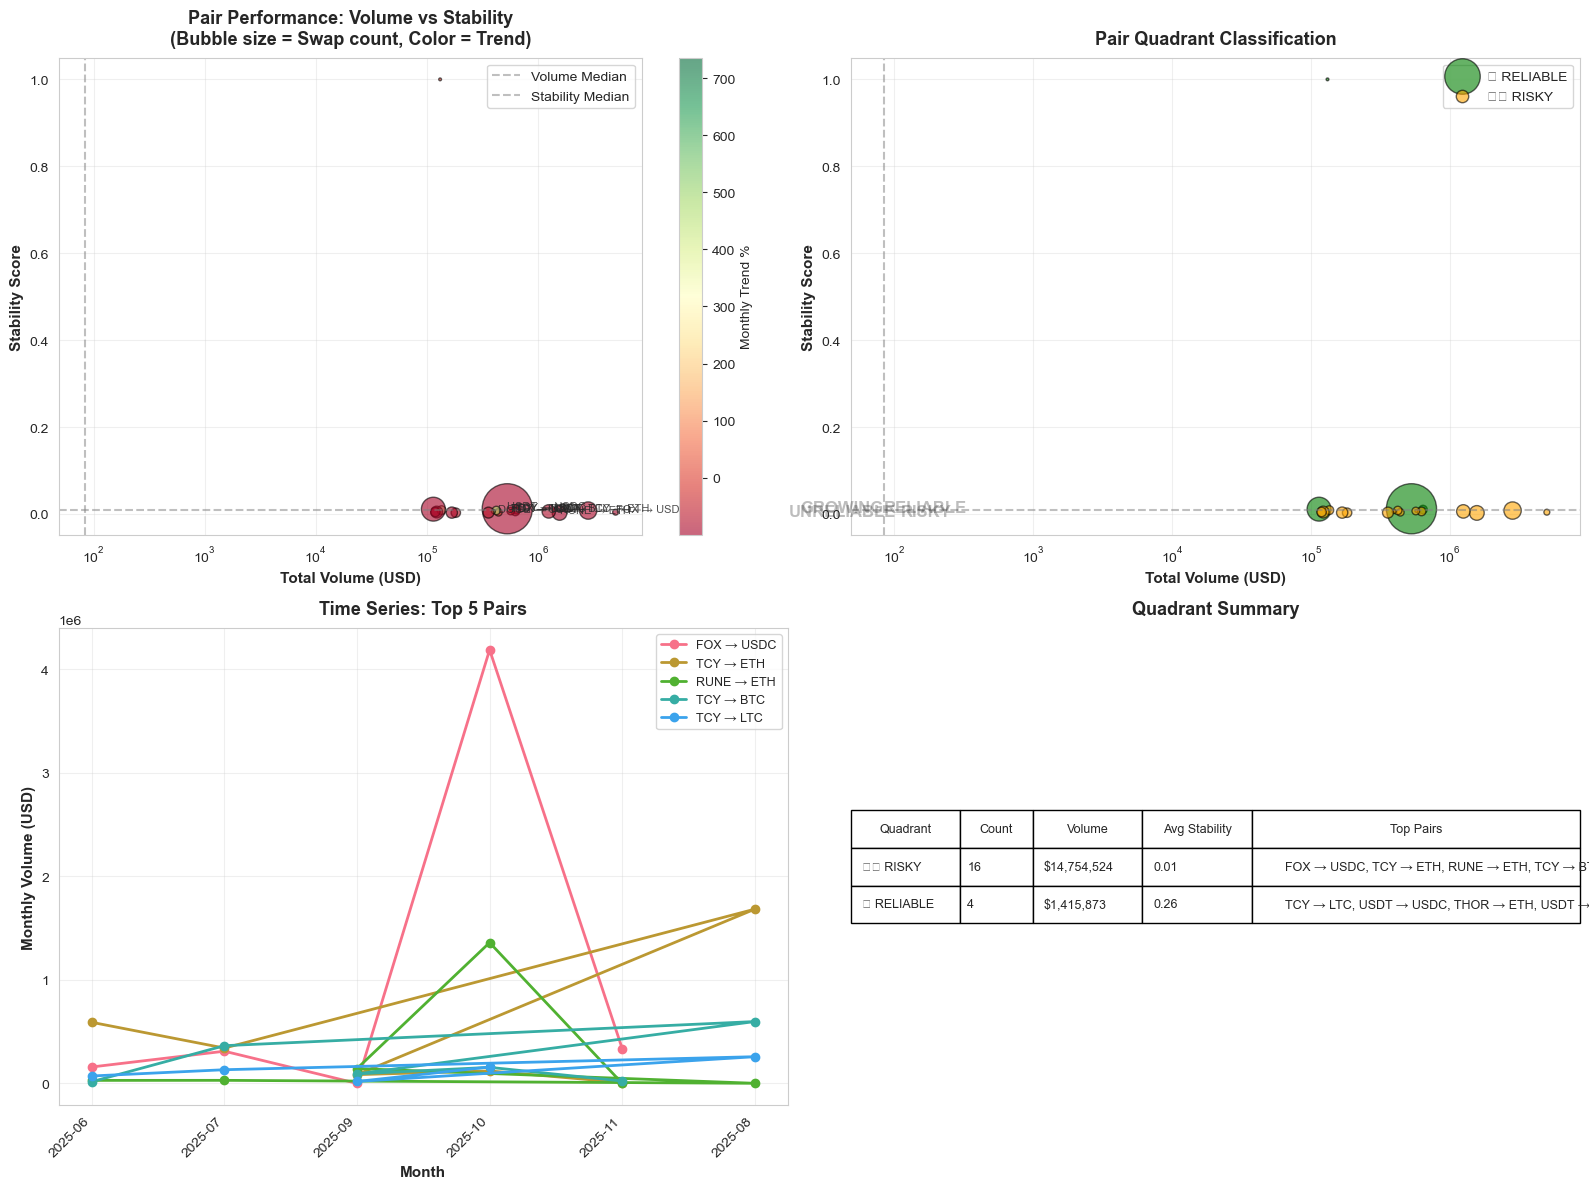

COMPARATIVE PAIR PERFORMANCE (STABILITY × VOLUME)

✓ RELIABLE:
  1. TCY → LTC: $640,701 volume, 0.01 stability, +736.2% MoM
  2. USDT → USDC: $529,252 volume, 0.01 stability, -94.5% MoM
  3. THOR → ETH: $131,570 volume, 1.00 stability, +0.0% MoM
  4. USDT → USDT: $114,350 volume, 0.01 stability, -95.0% MoM
  5. THOR → USDT: $78,892 volume, 0.02 stability, -60.9% MoM

⚠️ RISKY:
  1. FOX → USDC: $4,995,175 volume, 0.00 stability, -92.0% MoM
  2. TCY → ETH: $2,829,924 volume, 0.01 stability, -92.6% MoM
  3. RUNE → ETH: $1,565,024 volume, 0.00 stability, -100.0% MoM
  4. TCY → BTC: $1,250,561 volume, 0.01 stability, -85.0% MoM
  5. TCY → USDC: $625,822 volume, 0.01 stability, -73.8% MoM

~ GROWING:
  1. LINK → USDC: $77 volume, 0.02 stability, +109.8% MoM
  2. THOR → BCH: $44 volume, 1.00 stability, +0.0% MoM
  3. FOX → BNB: $42 volume, 1.00 stability, +0.0% MoM
  4. DOGE → RUJI: $40 volume, 1.00 stability, +0.0% MoM
  5. LINK → LINK: $38 volume, 1.00 stability, +0.0% MoM

✗ UNRELIABLE:
  

In [ ]:
# CELL 16: Comparative Pair Performance (Stability × Volume)

if 'asset_pair' in analysis_df.columns and 'timestamp' in analysis_df.columns:
    pair_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(pair_df) > 0:
        # Calculate pair metrics
        pair_metrics = pair_df.groupby('asset_pair').agg({
            'from_amount': ['sum', 'count', 'mean'],
            'timestamp': lambda x: (x.max() - x.min()).days
        }).reset_index()
        pair_metrics.columns = ['asset_pair', 'total_volume', 'swap_count', 'avg_swap_size', 'days_active']
        
        # Calculate daily volume volatility
        pair_df['date'] = pd.to_datetime(pair_df['timestamp']).dt.date
        daily_volume = pair_df.groupby(['asset_pair', 'date'])['from_amount'].sum().reset_index()
        daily_volume.columns = ['asset_pair', 'date', 'daily_volume']
        
        daily_volatility = daily_volume.groupby('asset_pair')['daily_volume'].agg(['std', 'mean']).reset_index()
        daily_volatility.columns = ['asset_pair', 'volatility', 'mean_daily_volume']
        daily_volatility['volatility_pct'] = (daily_volatility['volatility'] / daily_volatility['mean_daily_volume'] * 100).fillna(0)
        
        # Merge metrics
        pair_analysis = pair_metrics.merge(daily_volatility[['asset_pair', 'volatility_pct']], on='asset_pair', how='left')
        pair_analysis['volatility_pct'] = pair_analysis['volatility_pct'].fillna(0)
        
        # Calculate stability score (inverse of volatility)
        pair_analysis['stability_score'] = 1 / (1 + pair_analysis['volatility_pct'])
        
        # Calculate monthly trend (current month vs previous month)
        pair_df['year_month'] = pd.to_datetime(pair_df['timestamp']).dt.to_period('M').astype(str)
        monthly_volume = pair_df.groupby(['asset_pair', 'year_month'])['from_amount'].sum().reset_index()
        monthly_volume.columns = ['asset_pair', 'year_month', 'monthly_volume']
        monthly_volume = monthly_volume.sort_values(['asset_pair', 'year_month'])
        
        monthly_volume['prev_month_volume'] = monthly_volume.groupby('asset_pair')['monthly_volume'].shift(1)
        monthly_volume['monthly_trend'] = ((monthly_volume['monthly_volume'] - monthly_volume['prev_month_volume']) / monthly_volume['prev_month_volume'] * 100).fillna(0)
        
        # Get latest month trend
        latest_month = monthly_volume.groupby('asset_pair').tail(1)[['asset_pair', 'monthly_trend']]
        pair_analysis = pair_analysis.merge(latest_month, on='asset_pair', how='left')
        pair_analysis['monthly_trend'] = pair_analysis['monthly_trend'].fillna(0)
        
        # Classify into quadrants
        volume_median = pair_analysis['total_volume'].median()
        stability_median = pair_analysis['stability_score'].median()
        
        def classify_quadrant(row):
            high_vol = row['total_volume'] >= volume_median
            high_stability = row['stability_score'] >= stability_median
            
            if high_vol and high_stability:
                return '✓ RELIABLE'
            elif high_vol and not high_stability:
                return '⚠️ RISKY'
            elif not high_vol and high_stability:
                return '~ GROWING'
            else:
                return '✗ UNRELIABLE'
        
        pair_analysis['quadrant'] = pair_analysis.apply(classify_quadrant, axis=1)
        
        # Filter to top pairs for analysis
        top_pairs = pair_analysis.nlargest(20, 'total_volume')
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Bubble chart (x=volume, y=stability, size=count, color=trend)
        scatter = ax1.scatter(top_pairs['total_volume'], top_pairs['stability_score'], 
                            s=top_pairs['swap_count']*2, c=top_pairs['monthly_trend'], 
                            cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1)
        
        # Add quadrant lines
        ax1.axvline(x=volume_median, color='gray', linestyle='--', alpha=0.5, label='Volume Median')
        ax1.axhline(y=stability_median, color='gray', linestyle='--', alpha=0.5, label='Stability Median')
        
        # Add labels for top pairs
        for i, (idx, row) in enumerate(top_pairs.iterrows()):
            if i < 10:  # Label top 10
                ax1.annotate(row['asset_pair'], (row['total_volume'], row['stability_score']), 
                           fontsize=8, alpha=0.8)
        
        ax1.set_xlabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
        ax1.set_title('Pair Performance: Volume vs Stability\n(Bubble size = Swap count, Color = Trend)', 
                      fontsize=13, fontweight='bold', pad=10)
        ax1.set_xscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        plt.colorbar(scatter, ax=ax1, label='Monthly Trend %')
        
        # Top-right: Quadrant plot (label top 10 pairs)
        quadrant_colors = {'✓ RELIABLE': 'green', '⚠️ RISKY': 'orange', '~ GROWING': 'blue', '✗ UNRELIABLE': 'red'}
        for quadrant in quadrant_colors.keys():
            quadrant_data = top_pairs[top_pairs['quadrant'] == quadrant]
            if len(quadrant_data) > 0:
                ax2.scatter(quadrant_data['total_volume'], quadrant_data['stability_score'], 
                          s=quadrant_data['swap_count']*2, c=quadrant_colors[quadrant], 
                          alpha=0.6, label=quadrant, edgecolors='black', linewidth=1)
        
        ax2.axvline(x=volume_median, color='gray', linestyle='--', alpha=0.5)
        ax2.axhline(y=stability_median, color='gray', linestyle='--', alpha=0.5)
        
        # Add quadrant labels
        ax2.text(volume_median * 0.5, stability_median * 1.5, 'GROWING', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 2, stability_median * 1.5, 'RELIABLE', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 0.5, stability_median * 0.5, 'UNRELIABLE', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 2, stability_median * 0.5, 'RISKY', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        
        ax2.set_xlabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
        ax2.set_title('Pair Quadrant Classification', fontsize=13, fontweight='bold', pad=10)
        ax2.set_xscale('log')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Bottom-left: Line charts (time series for top 5 pairs)
        top_5_pairs = top_pairs.head(5)['asset_pair'].tolist()
        for pair in top_5_pairs:
            pair_timeseries = monthly_volume[monthly_volume['asset_pair'] == pair].sort_values('year_month')
            if len(pair_timeseries) > 0:
                ax3.plot(pair_timeseries['year_month'], pair_timeseries['monthly_volume'], 
                        'o-', label=pair, linewidth=2, markersize=6)
        
        ax3.set_xlabel('Month', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Monthly Volume (USD)', fontsize=11, fontweight='bold')
        ax3.set_title('Time Series: Top 5 Pairs', fontsize=13, fontweight='bold', pad=10)
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Bottom-right: Summary table visualization
        ax4.axis('off')
        quadrant_summary = top_pairs.groupby('quadrant').agg({
            'asset_pair': 'count',
            'total_volume': 'sum',
            'stability_score': 'mean'
        }).reset_index()
        quadrant_summary.columns = ['Quadrant', 'Pair Count', 'Total Volume', 'Avg Stability']
        
        table_data = []
        for _, row in quadrant_summary.iterrows():
            pairs_in_quadrant = top_pairs[top_pairs['quadrant'] == row['Quadrant']]['asset_pair'].tolist()[:5]
            table_data.append([
                row['Quadrant'],
                f"{row['Pair Count']}",
                f"${row['Total Volume']:,.0f}",
                f"{row['Avg Stability']:.2f}",
                ', '.join(pairs_in_quadrant)
            ])
        
        table = ax4.table(cellText=table_data,
                         colLabels=['Quadrant', 'Count', 'Volume', 'Avg Stability', 'Top Pairs'],
                         cellLoc='left',
                         loc='center',
                         colWidths=[0.15, 0.1, 0.15, 0.15, 0.45])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        ax4.set_title('Quadrant Summary', fontsize=13, fontweight='bold', pad=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("COMPARATIVE PAIR PERFORMANCE (STABILITY × VOLUME)")
        print("=" * 70)
        
        for quadrant in ['✓ RELIABLE', '⚠️ RISKY', '~ GROWING', '✗ UNRELIABLE']:
            quadrant_pairs = pair_analysis[pair_analysis['quadrant'] == quadrant].sort_values('total_volume', ascending=False)
            if len(quadrant_pairs) > 0:
                print(f"\n{quadrant}:")
                top_5 = quadrant_pairs.head(5)
                for i, (idx, row) in enumerate(top_5.iterrows()):
                    print(f"  {i+1}. {row['asset_pair']}: ${row['total_volume']:,.0f} volume, "
                         f"{row['stability_score']:.2f} stability, {row['monthly_trend']:+.1f}% MoM")
        
        print(f"\nRecommendations:")
        reliable_pairs = pair_analysis[pair_analysis['quadrant'] == '✓ RELIABLE'].head(5)['asset_pair'].tolist()
        growing_pairs = pair_analysis[pair_analysis['quadrant'] == '~ GROWING'].head(5)['asset_pair'].tolist()
        
        if reliable_pairs:
            print(f"  Top reliable pairs to promote: {', '.join(reliable_pairs)}")
        if growing_pairs:
            print(f"  Growing pairs to watch: {', '.join(growing_pairs)}")
        
        risky_pairs = pair_analysis[pair_analysis['quadrant'] == '⚠️ RISKY'].head(5)['asset_pair'].tolist()
        if risky_pairs:
            print(f"  Risky pairs to monitor: {', '.join(risky_pairs)}")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for pair analysis")
else:
    print("⚠ Missing required columns: 'asset_pair' and/or 'timestamp'")


### CELL 17: Time Zone / Geographic Trading Patterns

**Business Impact:** When should we run campaigns?

**Goal:** Analyze trading patterns by time and geographic region to optimize campaign timing.


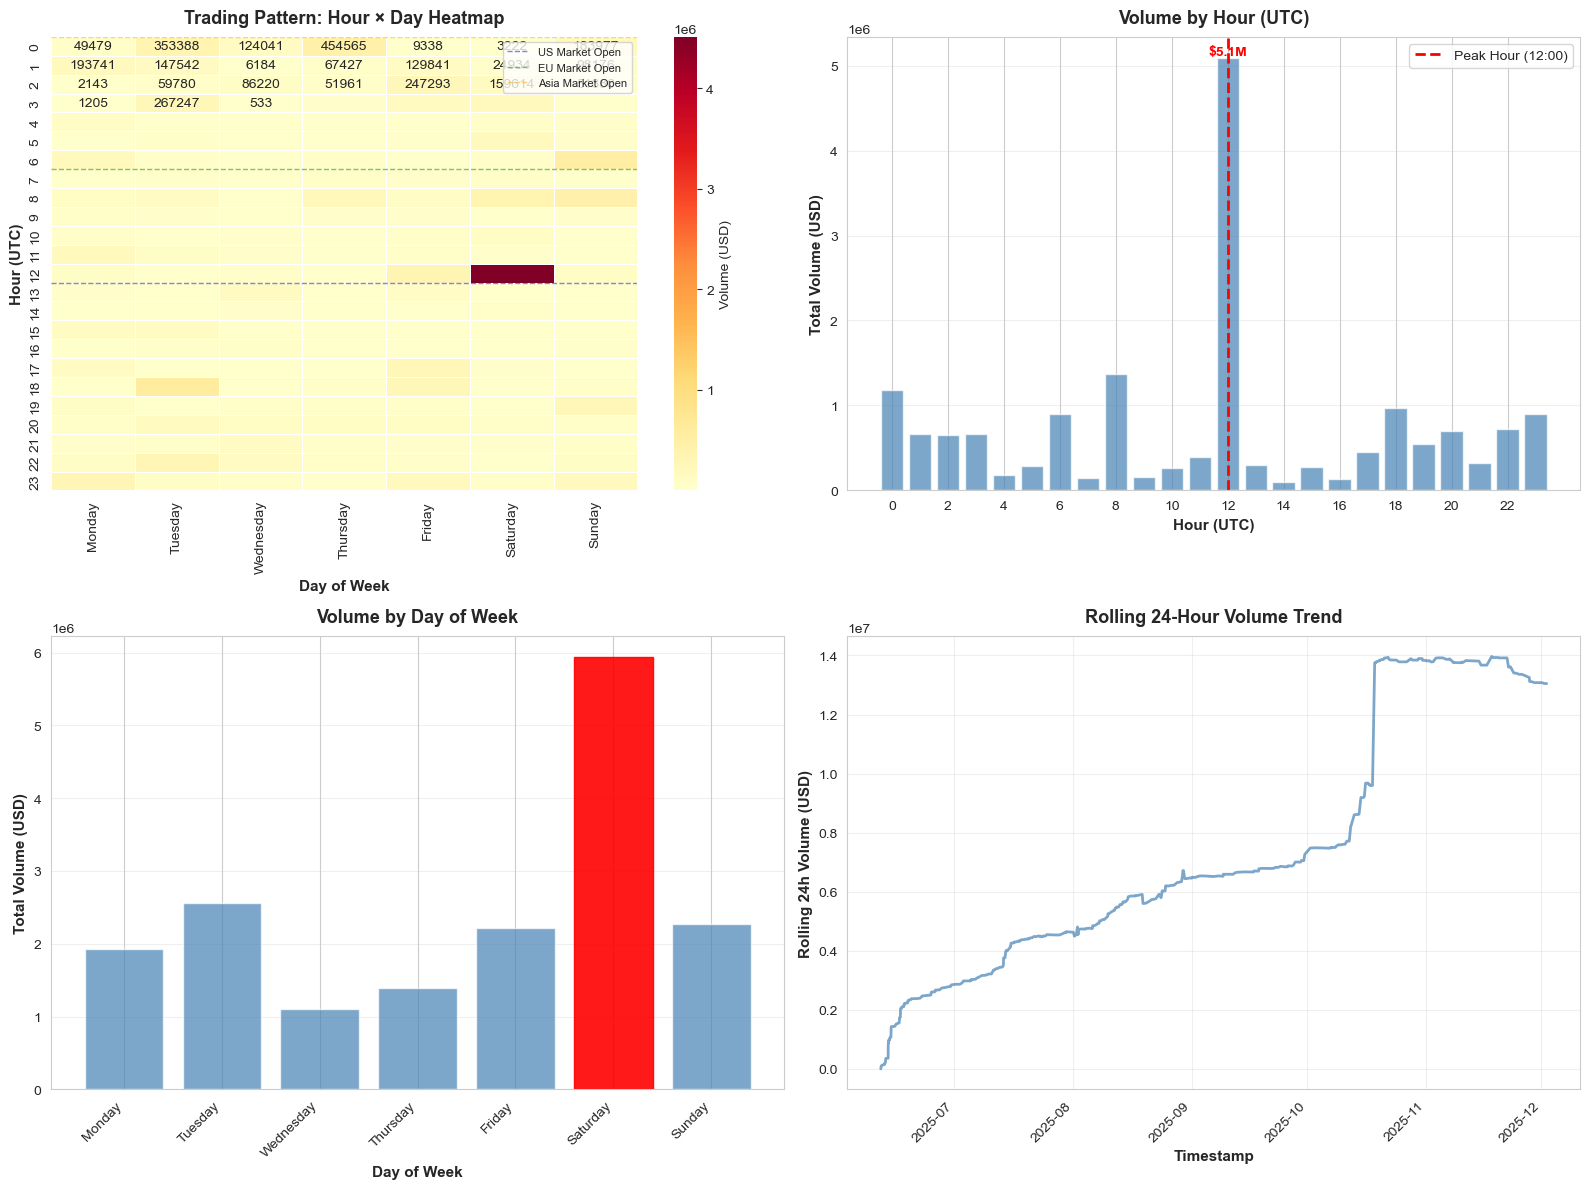

TIME ZONE / GEOGRAPHIC TRADING PATTERNS

Peak Trading Times:
  Peak hour: 12:00 UTC with $5,082,986 volume
  Peak day: Saturday

Off-Peak Hours:
  Off-peak: 4:00, 7:00, 9:00, 10:00, 14:00, 16:00 UTC

Market Opening Correlations:
  US Market Open (13:00 UTC / 9am ET): $297,997
  EU Market Open (7:00 UTC / 8am CET): $144,018
  Asia Market Open (0:00 UTC / 9am JST): $1,178,011

Weekend Effect:
  Weekday volume: $9,186,189
  Weekend volume: $8,204,595 (47.2% of total)

Recommendation:
  Launch campaigns at 10:00 UTC (2:00 ET)
  This is 2 hours before peak trading hour (12:00 UTC)
  Target peak engagement window: 12:00-14:00 UTC


In [ ]:
# CELL 17: Time Zone / Geographic Trading Patterns

if 'timestamp' in analysis_df.columns:
    timezone_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(timezone_df) > 0:
        # Extract hour and day of week
        timezone_df['hour_utc'] = pd.to_datetime(timezone_df['timestamp']).dt.hour
        timezone_df['day_of_week'] = pd.to_datetime(timezone_df['timestamp']).dt.day_name()
        
        # Calculate swap volume/count by hour and day
        hourly_volume = timezone_df.groupby('hour_utc')['from_amount'].agg(['sum', 'count']).reset_index()
        hourly_volume.columns = ['hour_utc', 'total_volume', 'swap_count']
        
        daily_volume = timezone_df.groupby('day_of_week')['from_amount'].agg(['sum', 'count']).reset_index()
        daily_volume.columns = ['day_of_week', 'total_volume', 'swap_count']
        
        # Create heatmap (hour × day_of_week)
        heatmap_data = timezone_df.groupby(['hour_utc', 'day_of_week'])['from_amount'].sum().reset_index()
        heatmap_pivot = heatmap_data.pivot(index='hour_utc', columns='day_of_week', values='from_amount').fillna(0)
        
        # Order days of week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        heatmap_pivot = heatmap_pivot.reindex(columns=[d for d in day_order if d in heatmap_pivot.columns], fill_value=0)
        
        # Identify peak hours
        peak_hour = hourly_volume.loc[hourly_volume['total_volume'].idxmax(), 'hour_utc']
        peak_volume = hourly_volume['total_volume'].max()
        
        # Identify peak day
        peak_day = daily_volume.loc[daily_volume['total_volume'].idxmax(), 'day_of_week']
        
        # Identify off-peak hours (bottom 25%)
        volume_threshold = hourly_volume['total_volume'].quantile(0.25)
        off_peak_hours = hourly_volume[hourly_volume['total_volume'] <= volume_threshold]['hour_utc'].tolist()
        
        # Calculate rolling 24h volume
        timezone_df_sorted = timezone_df.sort_values('timestamp')
        timezone_df_sorted['rolling_24h_volume'] = timezone_df_sorted['from_amount'].rolling(window=24*60, min_periods=1).sum()
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Heatmap (hour 0-23 rows × day_of_week columns)
        sns.heatmap(
            heatmap_pivot, annot=True, cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Volume (USD)'}, linewidths=0.5, fmt='.0f'
        )
        ax1.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Hour (UTC)', fontsize=11, fontweight='bold')
        ax1.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold', pad=10)
        
        # Annotate market opening times
        # US market open: ~13:00 UTC (9am ET)
        # EU market open: ~7:00 UTC (8am CET)
        # Asia market open: ~0:00 UTC (9am JST)
        ax1.axhline(y=13, color='blue', linestyle='--', alpha=0.5, linewidth=1, label='US Market Open')
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.5, linewidth=1, label='EU Market Open')
        ax1.axhline(y=0, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='Asia Market Open')
        ax1.legend(loc='upper right', fontsize=8)
        
        # Top-right: Bar chart (hour vs volume)
        bars = ax2.bar(hourly_volume['hour_utc'], hourly_volume['total_volume'], 
                      color='steelblue', alpha=0.7)
        ax2.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, label=f'Peak Hour ({peak_hour}:00)')
        ax2.set_xlabel('Hour (UTC)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax2.set_title('Volume by Hour (UTC)', fontsize=13, fontweight='bold', pad=10)
        ax2.set_xticks(range(0, 24, 2))
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend()
        
        # Add value labels on peak hour
        peak_idx = hourly_volume[hourly_volume['hour_utc'] == peak_hour].index[0]
        peak_val = hourly_volume.loc[peak_idx, 'total_volume']
        ax2.text(peak_hour, peak_val, f'${peak_val/1e6:.1f}M', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='red')
        
        # Bottom-left: Bar chart (day vs volume)
        day_order_list = [d for d in day_order if d in daily_volume['day_of_week'].values]
        daily_volume_ordered = daily_volume.set_index('day_of_week').reindex(day_order_list).reset_index()
        
        bars2 = ax3.bar(range(len(daily_volume_ordered)), daily_volume_ordered['total_volume'], 
                       color='steelblue', alpha=0.7)
        ax3.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax3.set_title('Volume by Day of Week', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xticks(range(len(daily_volume_ordered)))
        ax3.set_xticklabels(daily_volume_ordered['day_of_week'], rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Highlight peak day
        peak_day_idx = daily_volume_ordered[daily_volume_ordered['day_of_week'] == peak_day].index[0]
        bars2[peak_day_idx].set_color('red')
        bars2[peak_day_idx].set_alpha(0.9)
        
        # Bottom-right: Line chart (rolling 24h volume)
        sample_size = min(1000, len(timezone_df_sorted))
        timezone_sample = timezone_df_sorted.sample(n=sample_size, random_state=42) if len(timezone_df_sorted) > sample_size else timezone_df_sorted
        timezone_sample = timezone_sample.sort_values('timestamp')
        
        ax4.plot(timezone_sample['timestamp'], timezone_sample['rolling_24h_volume'], 
                linewidth=2, color='steelblue', alpha=0.7)
        ax4.set_xlabel('Timestamp', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Rolling 24h Volume (USD)', fontsize=11, fontweight='bold')
        ax4.set_title('Rolling 24-Hour Volume Trend', fontsize=13, fontweight='bold', pad=10)
        ax4.grid(True, alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("TIME ZONE / GEOGRAPHIC TRADING PATTERNS")
        print("=" * 70)
        
        print(f"\nPeak Trading Times:")
        print(f"  Peak hour: {peak_hour}:00 UTC with ${peak_volume:,.0f} volume")
        print(f"  Peak day: {peak_day}")
        
        print(f"\nOff-Peak Hours:")
        off_peak_str = ', '.join([f"{h}:00" for h in sorted(off_peak_hours)])
        print(f"  Off-peak: {off_peak_str} UTC")
        
        # Market opening correlations
        us_market_hour = 13  # 9am ET
        eu_market_hour = 7   # 8am CET
        asia_market_hour = 0  # 9am JST
        
        us_volume = hourly_volume[hourly_volume['hour_utc'] == us_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == us_market_hour]) > 0 else 0
        eu_volume = hourly_volume[hourly_volume['hour_utc'] == eu_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == eu_market_hour]) > 0 else 0
        asia_volume = hourly_volume[hourly_volume['hour_utc'] == asia_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == asia_market_hour]) > 0 else 0
        
        print(f"\nMarket Opening Correlations:")
        print(f"  US Market Open (13:00 UTC / 9am ET): ${us_volume:,.0f}")
        print(f"  EU Market Open (7:00 UTC / 8am CET): ${eu_volume:,.0f}")
        print(f"  Asia Market Open (0:00 UTC / 9am JST): ${asia_volume:,.0f}")
        
        # Weekend effect
        weekday_volume = daily_volume[daily_volume['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['total_volume'].sum()
        weekend_volume = daily_volume[daily_volume['day_of_week'].isin(['Saturday', 'Sunday'])]['total_volume'].sum()
        weekend_pct = (weekend_volume / (weekday_volume + weekend_volume) * 100) if (weekday_volume + weekend_volume) > 0 else 0
        
        print(f"\nWeekend Effect:")
        print(f"  Weekday volume: ${weekday_volume:,.0f}")
        print(f"  Weekend volume: ${weekend_volume:,.0f} ({weekend_pct:.1f}% of total)")
        
        # Recommendation
        campaign_hour = max(0, peak_hour - 2)  # 2 hours before peak
        print(f"\nRecommendation:")
        print(f"  Launch campaigns at {campaign_hour}:00 UTC ({campaign_hour - 8 if campaign_hour >= 8 else campaign_hour + 16}:00 ET)")
        print(f"  This is 2 hours before peak trading hour ({peak_hour}:00 UTC)")
        print(f"  Target peak engagement window: {peak_hour}:00-{peak_hour+2}:00 UTC")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for timezone analysis")
else:
    print("⚠ Missing required column: 'timestamp'")


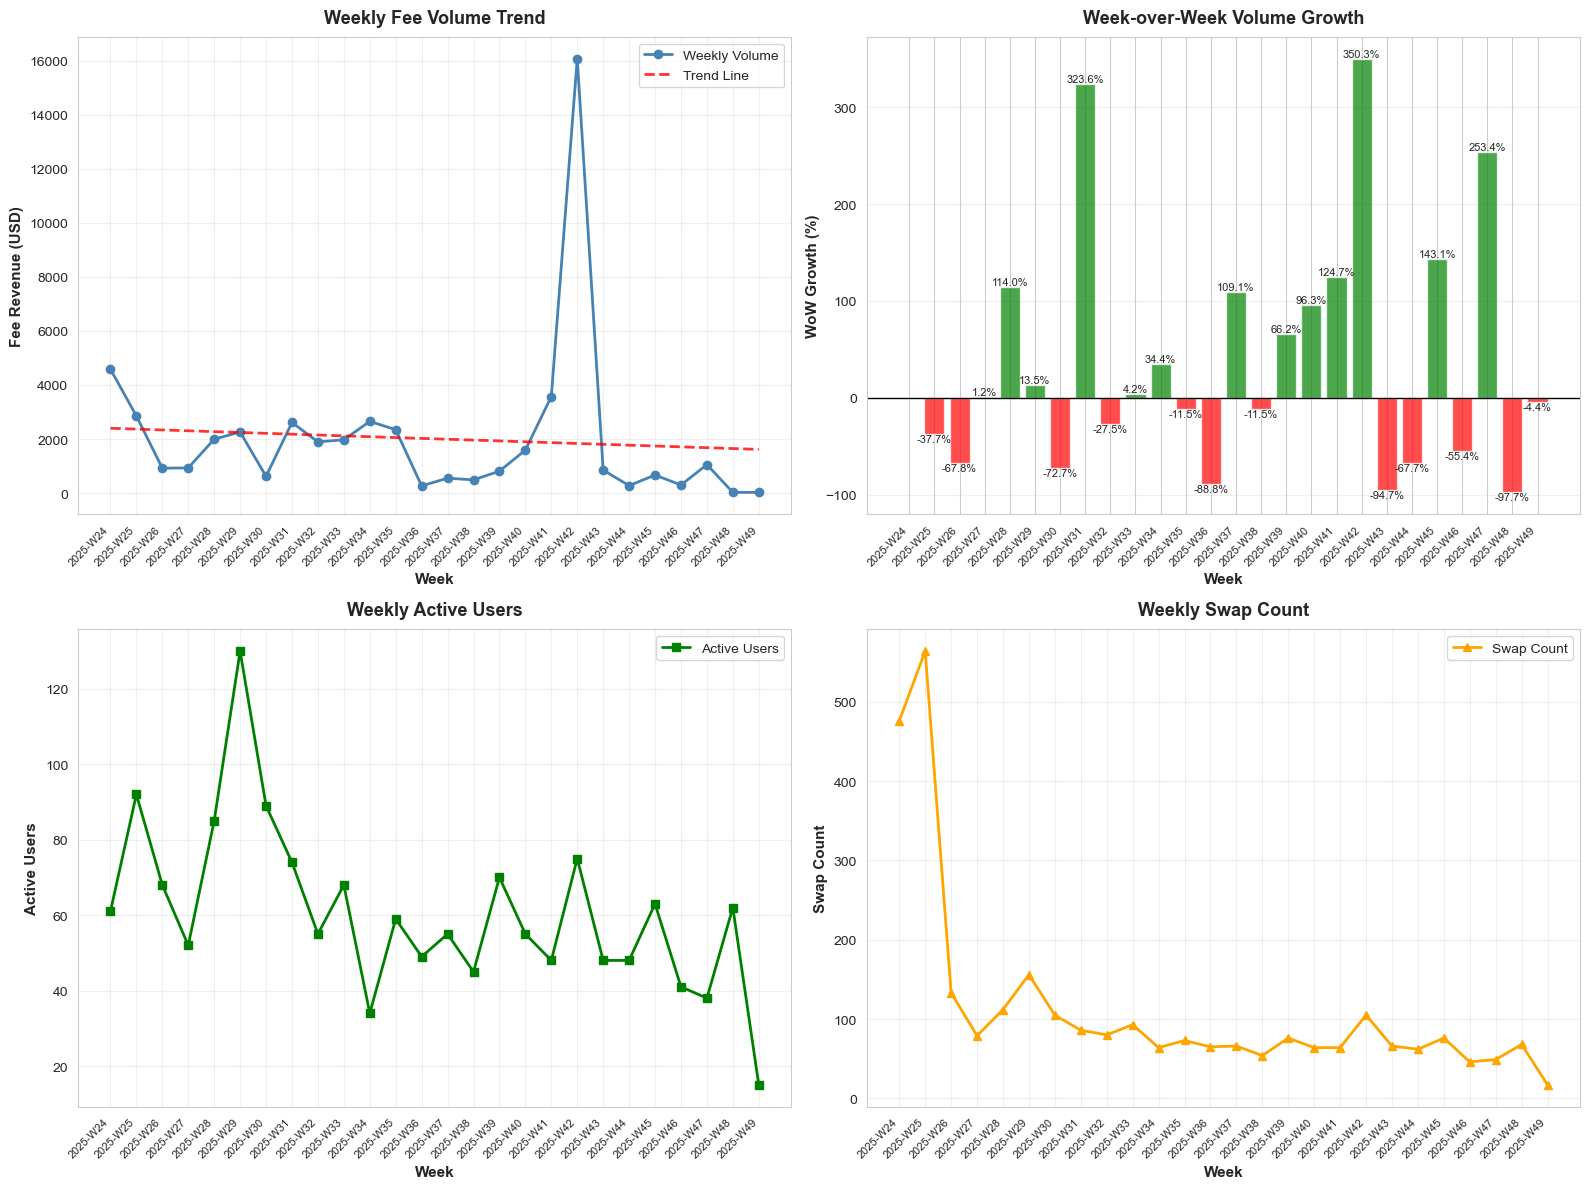

WEEK-OVER-WEEK GROWTH DASHBOARD
Current trend: STRONG GROWTH
YoY growth (first 4 vs last 4 weeks): -85.0%
Average recent WoW growth (last 4 weeks): 24.0%
Latest week WoW growth: -4.4%

Total weeks analyzed: 26
Total volume: $52,172.35
Total swaps: 2,899
Total unique users: 1,579


In [ ]:
# CELL 7: Week-over-Week Growth Dashboard

if 'timestamp' in analysis_df.columns:
    # Extract week information
    analysis_df['year'] = pd.to_datetime(analysis_df['timestamp']).dt.year
    analysis_df['week'] = pd.to_datetime(analysis_df['timestamp']).dt.isocalendar().week
    analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
    
    user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'
    
    # Aggregate by week
    weekly_stats = analysis_df.groupby('year_week').agg({
        'fee_usd': 'sum',
        'from_amount': 'count'
    }).reset_index()
    weekly_stats.columns = ['year_week', 'weekly_volume', 'weekly_swaps']
    
    # Count distinct users per week
    if user_col in analysis_df.columns:
        weekly_users = analysis_df.groupby('year_week')[user_col].nunique().reset_index()
        weekly_users.columns = ['year_week', 'weekly_users']
        weekly_stats = weekly_stats.merge(weekly_users, on='year_week', how='left')
    else:
        weekly_stats['weekly_users'] = 0
    
    # Calculate week-over-week growth
    weekly_stats['wow_volume_growth'] = weekly_stats['weekly_volume'].pct_change() * 100
    weekly_stats['wow_swaps_growth'] = weekly_stats['weekly_swaps'].pct_change() * 100
    weekly_stats['wow_users_growth'] = weekly_stats['weekly_users'].pct_change() * 100
    
    # Fill NaN with 0 for first week
    weekly_stats = weekly_stats.fillna(0)
    
    # Sort by year_week for proper ordering
    weekly_stats = weekly_stats.sort_values('year_week').reset_index(drop=True)
    
    # Create 2x2 subplot dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Line chart of weekly volume with trend line
    ax1.plot(range(len(weekly_stats)), weekly_stats['weekly_volume'], 
            marker='o', linewidth=2, markersize=6, color='steelblue', label='Weekly Volume')
    ax1.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=11, fontweight='bold')
    ax1.set_title('Weekly Fee Volume Trend', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(len(weekly_stats)))
    ax1.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(weekly_stats)), weekly_stats['weekly_volume'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(weekly_stats)), p(range(len(weekly_stats))), 
            "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Top-right: Column chart of WoW growth % (green if +, red if -)
    colors_wow = ['green' if x >= 0 else 'red' for x in weekly_stats['wow_volume_growth']]
    ax2.bar(range(len(weekly_stats)), weekly_stats['wow_volume_growth'], 
           color=colors_wow, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax2.set_ylabel('WoW Growth (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Week-over-Week Volume Growth', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(weekly_stats)))
    ax2.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(weekly_stats.iterrows()):
        if not pd.isna(row['wow_volume_growth']) and row['wow_volume_growth'] != 0:
            ax2.text(i, row['wow_volume_growth'], f'{row["wow_volume_growth"]:.1f}%', 
                    ha='center', va='bottom' if row['wow_volume_growth'] >= 0 else 'top', fontsize=8)
    
    # Bottom-left: Line chart of active users per week
    if weekly_stats['weekly_users'].sum() > 0:
        ax3.plot(range(len(weekly_stats)), weekly_stats['weekly_users'], 
                marker='s', linewidth=2, markersize=6, color='green', label='Active Users')
        ax3.set_xlabel('Week', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Active Users', fontsize=11, fontweight='bold')
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xticks(range(len(weekly_stats)))
        ax3.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'User data not available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold')
    
    # Bottom-right: Line chart of weekly swap count
    ax4.plot(range(len(weekly_stats)), weekly_stats['weekly_swaps'], 
            marker='^', linewidth=2, markersize=6, color='orange', label='Swap Count')
    ax4.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Swap Count', fontsize=11, fontweight='bold')
    ax4.set_title('Weekly Swap Count', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xticks(range(len(weekly_stats)))
    ax4.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate trend and YoY growth
    latest_week_growth = weekly_stats['wow_volume_growth'].iloc[-1] if len(weekly_stats) > 1 else 0
    avg_recent_growth = weekly_stats['wow_volume_growth'].tail(4).mean() if len(weekly_stats) >= 4 else latest_week_growth
    
    # Determine trend
    if avg_recent_growth > 5:
        trend = "STRONG GROWTH"
    elif avg_recent_growth > 0:
        trend = "GROWTH"
    elif avg_recent_growth > -5:
        trend = "DECLINE"
    else:
        trend = "STRONG DECLINE"
    
    # Calculate YoY growth (compare first 4 weeks vs last 4 weeks if available)
    if len(weekly_stats) >= 8:
        first_4_avg = weekly_stats.head(4)['weekly_volume'].mean()
        last_4_avg = weekly_stats.tail(4)['weekly_volume'].mean()
        yoy_growth = ((last_4_avg - first_4_avg) / first_4_avg * 100) if first_4_avg > 0 else 0
    else:
        yoy_growth = None
    
    # Print summary statistics
    print("=" * 60)
    print("WEEK-OVER-WEEK GROWTH DASHBOARD")
    print("=" * 60)
    print(f"Current trend: {trend}")
    if yoy_growth is not None:
        print(f"YoY growth (first 4 vs last 4 weeks): {yoy_growth:.1f}%")
    print(f"Average recent WoW growth (last 4 weeks): {avg_recent_growth:.1f}%")
    print(f"Latest week WoW growth: {latest_week_growth:.1f}%")
    print(f"\nTotal weeks analyzed: {len(weekly_stats)}")
    print(f"Total volume: ${weekly_stats['weekly_volume'].sum():,.2f}")
    print(f"Total swaps: {weekly_stats['weekly_swaps'].sum():,}")
    if weekly_stats['weekly_users'].sum() > 0:
        print(f"Total unique users: {weekly_stats['weekly_users'].sum():,}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


In [ ]:
# IMPROVEMENT 1: Separate Add vs Swap transactions
print("=== IMPROVEMENT 1: Transaction Type Breakdown ===\n")

# Filter swaps only (exclude Add transactions for swap-specific analysis)
swaps_only = analysis_df[analysis_df['type'] == 'Swap'].copy()
adds_only = analysis_df[analysis_df['type'] == 'Add'].copy()

print(f"Total transactions: {len(analysis_df):,}")
print(f"  Swaps: {len(swaps_only):,} ({len(swaps_only)/len(analysis_df)*100:.1f}%)")
print(f"  Adds: {len(adds_only):,} ({len(adds_only)/len(analysis_df)*100:.1f}%)")

if len(swaps_only) > 0:
    print(f"\nSwap-specific statistics:")
    print(f"  Average swap size: {swaps_only['from_amount'].mean():.2f}")
    print(f"  Median swap size: {swaps_only['from_amount'].median():.2f}")
    print(f"  Total swap volume: {swaps_only['from_amount'].sum():,.2f}")

if len(adds_only) > 0:
    print(f"\nAdd-specific statistics:")
    print(f"  Average add amount: {adds_only['from_amount'].mean():.2f}")
    print(f"  Median add amount: {adds_only['from_amount'].median():.2f}")
    print(f"  Total liquidity added: {adds_only['from_amount'].sum():,.2f}")

# Use swaps_only for subsequent swap analysis
analysis_df_swaps = swaps_only.copy()



=== IMPROVEMENT 1: Transaction Type Breakdown ===

Total transactions: 2,899
  Swaps: 2,895 (99.9%)
  Adds: 0 (0.0%)

Swap-specific statistics:
  Average swap size: 6003.17
  Median swap size: 100.00
  Total swap volume: 17,379,183.40


In [ ]:
# IMPROVEMENT 2: Calculate actual fee percentage/basis points
print("=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===\n")

if len(analysis_df_swaps) > 0:
    # Calculate fee as percentage difference
    # Note: This assumes fee is reflected in the ratio difference
    # For swaps: fee_bps = ((from_amount / to_amount) - 1) * 10000
    # But we need to account for different assets, so we'll use a simplified approach
    
    # Calculate effective fee rate (simplified - assumes 1:1 asset ratio for same-asset swaps)
    same_asset_swaps = analysis_df_swaps[analysis_df_swaps['from_asset'] == analysis_df_swaps['to_asset']].copy()
    
    if len(same_asset_swaps) > 0:
        same_asset_swaps['fee_percentage'] = ((same_asset_swaps['from_amount'] - same_asset_swaps['to_amount']) / same_asset_swaps['from_amount']) * 100
        same_asset_swaps['fee_bps'] = same_asset_swaps['fee_percentage'] * 100
        
        print(f"Same-asset swaps (for fee calculation): {len(same_asset_swaps):,}")
        print(f"  Average fee: {same_asset_swaps['fee_percentage'].mean():.4f}%")
        print(f"  Average fee: {same_asset_swaps['fee_bps'].mean():.2f} basis points")
        print(f"  Median fee: {same_asset_swaps['fee_bps'].median():.2f} basis points")
        
        # Add fee columns to main dataframe
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_percentage'] = same_asset_swaps['fee_percentage']
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_bps'] = same_asset_swaps['fee_bps']
    else:
        print("No same-asset swaps found for fee calculation")
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
    
    # Fee by affiliate presence
    if 'has_fee' in analysis_df_swaps.columns:
        fee_by_affiliate = analysis_df_swaps.groupby('has_fee').agg({
            'from_amount': ['count', 'mean', 'sum'],
            'fee_bps': 'mean'
        })
        print(f"\nFee analysis by affiliate presence:")
        print(fee_by_affiliate)



=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===

Same-asset swaps (for fee calculation): 163
  Average fee: 0.5408%
  Average fee: 54.08 basis points
  Median fee: 12.50 basis points

Fee analysis by affiliate presence:
        from_amount                               fee_bps
              count         mean           sum       mean
has_fee                                                  
True           2895  6003.172158  1.737918e+07  54.083096


In [ ]:
# IMPROVEMENT 3: Volume-weighted metrics
print("=== IMPROVEMENT 3: Volume-Weighted Metrics ===\n")

if len(analysis_df_swaps) > 0:
    # Volume-weighted average swap size by asset
    volume_weighted = analysis_df_swaps.groupby('from_asset').agg({
        'from_amount': ['sum', 'count', 'mean'],
        'to_amount': 'sum'
    }).round(2)
    volume_weighted.columns = ['total_volume', 'swap_count', 'avg_size', 'total_received']
    volume_weighted['volume_weighted_avg'] = volume_weighted['total_volume'] / volume_weighted['swap_count']
    volume_weighted = volume_weighted.sort_values('total_volume', ascending=False)
    
    print("Top 10 assets by volume (volume-weighted):")
    print(volume_weighted.head(10))
    
    # Overall volume-weighted average
    total_volume = analysis_df_swaps['from_amount'].sum()
    total_count = len(analysis_df_swaps)
    volume_weighted_overall = total_volume / total_count
    
    print(f"\nOverall volume-weighted average: {volume_weighted_overall:,.2f}")
    print(f"Simple average: {analysis_df_swaps['from_amount'].mean():,.2f}")
    print(f"Difference: {volume_weighted_overall - analysis_df_swaps['from_amount'].mean():,.2f}")



=== IMPROVEMENT 3: Volume-Weighted Metrics ===

Top 10 assets by volume (volume-weighted):
            total_volume  swap_count  avg_size  total_received  \
from_asset                                                       
FOX           6732189.66          79  85217.59       122457.11   
TCY           5946269.05         192  30970.15       263981.06   
RUNE          2198768.90         187  11758.12       831449.04   
USDT           950594.46         954    996.43      2473174.09   
DOGE           681459.00         110   6195.08       106979.85   
USDC           483122.05         112   4313.59       917206.35   
THOR           242430.27          14  17316.45         7676.79   
ATOM            74054.37         120    617.12       232160.74   
DAI             36886.43          11   3353.31         1156.41   
RUJI            14871.71           7   2124.53        13376.46   

            volume_weighted_avg  
from_asset                       
FOX                85217.590633  
TCY           

In [ ]:
# IMPROVEMENT 4: Hour-of-day analysis
print("=== IMPROVEMENT 4: Hour-of-Day Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    analysis_df_swaps['hour'] = analysis_df_swaps['timestamp'].dt.hour
    
    # Swaps by hour
    swaps_by_hour = analysis_df_swaps.groupby('hour').agg({
        'from_amount': ['count', 'sum', 'mean']
    })
    swaps_by_hour.columns = ['swap_count', 'total_volume', 'avg_size']
    swaps_by_hour = swaps_by_hour.sort_values('swap_count', ascending=False)
    
    print("Top 5 hours by swap count:")
    print(swaps_by_hour.head(5))
    
    print("\nTop 5 hours by volume:")
    swaps_by_hour_vol = swaps_by_hour.sort_values('total_volume', ascending=False)
    print(swaps_by_hour_vol.head(5))
    
    # Peak hours
    peak_hour_count = swaps_by_hour.index[0]
    peak_hour_volume = swaps_by_hour_vol.index[0]
    print(f"\nPeak hour (by count): {peak_hour_count}:00 ({swaps_by_hour.loc[peak_hour_count, 'swap_count']} swaps)")
    print(f"Peak hour (by volume): {peak_hour_volume}:00 ({swaps_by_hour_vol.loc[peak_hour_volume, 'total_volume']:,.2f} volume)")



=== IMPROVEMENT 4: Hour-of-Day Analysis ===

Top 5 hours by swap count:
      swap_count   total_volume     avg_size
hour                                        
20           381  700203.652212  1837.804861
21           247  322767.853026  1306.752441
22           224  723045.838402  3227.883207
19           180  547090.983920  3039.394355
5            149  290977.118204  1952.866565

Top 5 hours by volume:
      swap_count  total_volume      avg_size
hour                                        
12            87  5.082986e+06  58425.127806
8             96  1.375108e+06  14324.039894
0            100  1.178011e+06  11780.108866
18           145  9.751219e+05   6724.978359
23            98  9.015776e+05   9199.771103

Peak hour (by count): 20:00 (381 swaps)
Peak hour (by volume): 12:00 (5,082,986.12 volume)


In [ ]:
# IMPROVEMENT 5: Detailed asset pair analysis
print("=== IMPROVEMENT 5: Asset Pair Analysis ===\n")

if len(analysis_df_swaps) > 0:
    pair_analysis = analysis_df_swaps.groupby('asset_pair').agg({
        'from_amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'to_amount': ['sum', 'mean']
    }).round(2)
    pair_analysis.columns = ['count', 'total_volume', 'avg_size', 'std_size', 'min_size', 'max_size', 'total_received', 'avg_received']
    pair_analysis['volume_share_pct'] = (pair_analysis['total_volume'] / pair_analysis['total_volume'].sum() * 100).round(2)
    pair_analysis = pair_analysis.sort_values('total_volume', ascending=False)
    
    print("Top 15 asset pairs by volume:")
    print(pair_analysis.head(15))
    
    # Most volatile pairs (highest std dev)
    pair_analysis_volatile = pair_analysis[pair_analysis['count'] >= 5].sort_values('std_size', ascending=False)
    print("\nTop 10 most volatile pairs (by std dev, min 5 swaps):")
    print(pair_analysis_volatile[['count', 'avg_size', 'std_size', 'min_size', 'max_size']].head(10))
    
    # Most consistent pairs (lowest std dev relative to mean)
    pair_analysis['cv'] = (pair_analysis['std_size'] / pair_analysis['avg_size']).round(3)  # coefficient of variation
    pair_analysis_consistent = pair_analysis[pair_analysis['count'] >= 5].sort_values('cv')
    print("\nTop 10 most consistent pairs (lowest coefficient of variation, min 5 swaps):")
    print(pair_analysis_consistent[['count', 'avg_size', 'std_size', 'cv']].head(10))



=== IMPROVEMENT 5: Asset Pair Analysis ===

Top 15 asset pairs by volume:
             count  total_volume   avg_size    std_size  min_size    max_size  \
asset_pair                                                                      
FOX → USDC       9    4995175.00  555019.44  1347082.99    510.00  4136046.00   
TCY → ETH       78    2829924.28   36281.08    25931.93     10.00   130666.00   
RUNE → ETH      56    1565024.31   27946.86   103320.67      1.00   500000.00   
TCY → BTC       46    1240560.56   26968.71    47543.94     85.70   292457.00   
TCY → LTC       19     640701.00   33721.11    34273.51   1810.00   153855.00   
TCY → USDC      19     625822.40   32938.02    64848.90    100.00   268528.00   
FOX → USDT       2     574611.80  287305.90   398283.55   5676.90   568934.90   
TCY → USDT      15     568684.88   37912.33    60908.54    227.00   185394.00   
USDT → USDC    651     528451.84     811.75     1029.76     11.00    26771.70   
DOGE → USDT     14     440691.34   

In [ ]:
# IMPROVEMENT 6: Growth rate calculations
print("=== IMPROVEMENT 6: Growth Rate Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Calculate week-over-week growth rates
    weekly_growth = analysis_df_swaps.groupby(['year_week', 'from_asset']).agg({
        'from_amount': ['count', 'sum']
    })
    weekly_growth.columns = ['count', 'volume']
    weekly_growth = weekly_growth.reset_index()
    
    # Calculate growth rates for each asset
    growth_rates = []
    for asset in weekly_growth['from_asset'].unique():
        asset_data = weekly_growth[weekly_growth['from_asset'] == asset].sort_values('year_week')
        asset_data['count_growth'] = asset_data['count'].pct_change() * 100
        asset_data['volume_growth'] = asset_data['volume'].pct_change() * 100
        asset_data['count_change'] = asset_data['count'].diff()
        asset_data['volume_change'] = asset_data['volume'].diff()
        growth_rates.append(asset_data)
    
    growth_df = pd.concat(growth_rates, ignore_index=True)
    
    # Latest week growth rates
    latest_week = growth_df['year_week'].max()
    latest_growth = growth_df[growth_df['year_week'] == latest_week].copy()
    latest_growth = latest_growth[latest_growth['count_growth'].notna()].sort_values('volume_growth', ascending=False)
    
    print(f"Latest week: {latest_week}")
    print("\nTop 10 assets by volume growth rate (week-over-week):")
    print(latest_growth[['from_asset', 'count', 'volume', 'count_growth', 'volume_growth']].head(10))
    
    # Calculate compound growth rates (over multiple weeks)
    print("\nCompound growth rates (over last 4 weeks):")
    recent_weeks = sorted(growth_df['year_week'].unique())[-4:]
    recent_data = growth_df[growth_df['year_week'].isin(recent_weeks)]
    
    compound_growth = recent_data.groupby('from_asset').agg({
        'count': ['first', 'last'],
        'volume': ['first', 'last']
    })
    compound_growth.columns = ['count_first', 'count_last', 'volume_first', 'volume_last']
    compound_growth['count_cagr'] = ((compound_growth['count_last'] / compound_growth['count_first']) ** (1/3) - 1) * 100
    compound_growth['volume_cagr'] = ((compound_growth['volume_last'] / compound_growth['volume_first']) ** (1/3) - 1) * 100
    compound_growth = compound_growth[compound_growth['count_first'] > 0].sort_values('volume_cagr', ascending=False)
    
    print(compound_growth[['count_first', 'count_last', 'count_cagr', 'volume_cagr']].head(10))



=== IMPROVEMENT 6: Growth Rate Analysis ===

Latest week: 2025-W49

Top 10 assets by volume growth rate (week-over-week):
    from_asset  count       volume  count_growth  volume_growth
42        AVAX      3  5101.100000    -25.000000  331222.350231
158        ETH      3     9.824000    -62.500000    6050.073051
315       USDT      2  2715.000000      0.000000      46.756757
211        LTC      2    24.589000    -80.000000     -41.650798
107        BTC      6     0.056606    -40.000000     -79.033051
65         BCH      1     0.106527    -88.888889     -96.007921

Compound growth rates (over last 4 weeks):
            count_first  count_last  count_cagr  volume_cagr
from_asset                                                  
AVAX                  1           3   44.224957   651.901349
DOGE                  1          14  141.014226    82.469547
FOX                   3           1  -30.663873    75.826831
ETH                   5           3  -15.656733    55.055034
BNB                 

In [ ]:
# IMPROVEMENT 7: Outlier detection
print("=== IMPROVEMENT 7: Outlier Detection ===\n")

if len(analysis_df_swaps) > 0:
    # Use IQR method for outlier detection
    Q1 = analysis_df_swaps['from_amount'].quantile(0.25)
    Q3 = analysis_df_swaps['from_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = analysis_df_swaps[
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    ].copy()
    
    print(f"Outlier detection (IQR method):")
    print(f"  Q1: {Q1:,.2f}")
    print(f"  Q3: {Q3:,.2f}")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Lower bound: {lower_bound:,.2f}")
    print(f"  Upper bound: {upper_bound:,.2f}")
    print(f"\n  Outliers found: {len(outliers):,} ({len(outliers)/len(analysis_df_swaps)*100:.2f}%)")
    
    if len(outliers) > 0:
        print("\nTop 10 largest outliers:")
        top_outliers = outliers.nlargest(10, 'from_amount')[['timestamp', 'from_asset', 'to_asset', 'from_amount', 'to_amount', 'asset_pair']]
        print(top_outliers)
        
        # Outliers by asset
        print("\nOutliers by asset:")
        outlier_by_asset = outliers.groupby('from_asset').agg({
            'from_amount': ['count', 'sum', 'mean', 'max']
        })
        outlier_by_asset.columns = ['outlier_count', 'total_volume', 'avg_size', 'max_size']
        outlier_by_asset = outlier_by_asset.sort_values('outlier_count', ascending=False)
        print(outlier_by_asset.head(10))
    
    # Add outlier flag to dataframe
    analysis_df_swaps['is_outlier'] = (
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    )



=== IMPROVEMENT 7: Outlier Detection ===

Outlier detection (IQR method):
  Q1: 0.18
  Q3: 800.00
  IQR: 799.82
  Lower bound: -1,199.54
  Upper bound: 1,999.73

  Outliers found: 353 (12.19%)

Top 10 largest outliers:
               timestamp from_asset to_asset  from_amount     to_amount  \
150  2025-10-18 12:58:39        FOX     USDC   4136046.00  74401.340000   
248  2025-10-14 18:32:27        FOX     USDT    568934.90  11260.000000   
270  2025-10-12 06:47:12       RUNE      ETH    500000.00    114.046367   
222  2025-10-16 00:49:30       RUNE      ETH    446664.00     98.352317   
267  2025-10-12 08:01:13       RUNE      ETH    400000.00     90.225589   
3677 2025-06-14 12:58:30        FOX      ETH    354776.33      3.486106   
1221 2025-11-18 00:58:06        FOX     USDC    336854.11   4573.210000   
2474 2025-08-02 08:31:19        TCY      BTC    292457.00      0.407544   
3570 2025-06-16 23:05:06        TCY     USDC    268528.00  68281.250000   
2048 2025-08-29 12:10:41       

In [ ]:
# IMPROVEMENT 8: Cumulative volume tracking
print("=== IMPROVEMENT 8: Cumulative Volume Over Time ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    # Sort by timestamp
    volume_tracking = analysis_df_swaps.sort_values('timestamp').copy()
    volume_tracking['cumulative_volume'] = volume_tracking['from_amount'].cumsum()
    volume_tracking['cumulative_count'] = range(1, len(volume_tracking) + 1)
    
    # Daily cumulative volume
    volume_tracking['date'] = volume_tracking['timestamp'].dt.date
    daily_cumulative = volume_tracking.groupby('date').agg({
        'from_amount': 'sum',
        'cumulative_volume': 'last',
        'cumulative_count': 'last'
    })
    daily_cumulative.columns = ['daily_volume', 'cumulative_volume', 'cumulative_count']
    
    print("Cumulative volume milestones:")
    milestones = [0.25, 0.5, 0.75, 0.9, 0.95, 1.0]
    total_volume = volume_tracking['from_amount'].sum()
    
    for milestone in milestones:
        target_volume = total_volume * milestone
        milestone_rows = volume_tracking[volume_tracking['cumulative_volume'] >= target_volume]
        if len(milestone_rows) > 0:
            milestone_row = milestone_rows.iloc[0]
            print(f"  {milestone*100:.0f}% of volume reached: {milestone_row['timestamp']} ({milestone_row['cumulative_volume']:,.2f})")
        else:
            # Fallback: use the last row if no match found (shouldn't happen, but safety check)
            if len(volume_tracking) > 0:
                last_row = volume_tracking.iloc[-1]
                print(f"  {milestone*100:.0f}% of volume reached: {last_row['timestamp']} ({last_row['cumulative_volume']:,.2f}) [using last row]")
    
    print(f"\nTotal volume: {total_volume:,.2f}")
    print(f"Total swaps: {len(volume_tracking):,}")
    print(f"Average volume per swap: {total_volume/len(volume_tracking):,.2f}")
    
    # Show last 10 days
    print("\nLast 10 days cumulative volume:")
    print(daily_cumulative.tail(10))



=== IMPROVEMENT 8: Cumulative Volume Over Time ===

Cumulative volume milestones:
  25% of volume reached: 2025-07-18 01:06:48 (4,352,937.77)
  50% of volume reached: 2025-09-09 01:59:18 (8,705,692.23)
  75% of volume reached: 2025-10-18 12:58:39 (16,224,358.01)
  90% of volume reached: 2025-10-18 12:58:39 (16,224,358.01)
  95% of volume reached: 2025-10-26 23:51:35 (16,599,717.79)
  100% of volume reached: 2025-12-02 08:57:58 (17,379,183.40) [using last row]

Total volume: 17,379,183.40
Total swaps: 2,895
Average volume per swap: 6,003.17

Last 10 days cumulative volume:
            daily_volume  cumulative_volume  cumulative_count
date                                                         
2025-11-23    245.008583       1.736312e+07              2810
2025-11-24    194.883576       1.736331e+07              2818
2025-11-25    728.755289       1.736404e+07              2837
2025-11-26    143.315981       1.736419e+07              2844
2025-11-27   4808.347666       1.736899e+07      

In [ ]:
# IMPROVEMENT 9: Period-over-period comparisons
print("=== IMPROVEMENT 9: Period-over-Period Comparisons ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Compare latest week vs previous week
    all_weeks = sorted(analysis_df_swaps['year_week'].unique())
    
    if len(all_weeks) >= 2:
        latest_week = all_weeks[-1]
        prev_week = all_weeks[-2]
        
        latest_data = analysis_df_swaps[analysis_df_swaps['year_week'] == latest_week]
        prev_data = analysis_df_swaps[analysis_df_swaps['year_week'] == prev_week]
        
        print(f"Comparing {latest_week} vs {prev_week}:")
        print(f"\nOverall metrics:")
        print(f"  Swap count: {len(latest_data):,} vs {len(prev_data):,} ({len(latest_data)-len(prev_data):+,})")
        print(f"  Total volume: {latest_data['from_amount'].sum():,.2f} vs {prev_data['from_amount'].sum():,.2f} ({latest_data['from_amount'].sum()-prev_data['from_amount'].sum():+,.2f})")
        print(f"  Avg swap size: {latest_data['from_amount'].mean():,.2f} vs {prev_data['from_amount'].mean():,.2f} ({latest_data['from_amount'].mean()-prev_data['from_amount'].mean():+,.2f})")
        
        # Compare by asset
        latest_by_asset = latest_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        latest_by_asset.columns = ['count_latest', 'volume_latest']
        
        prev_by_asset = prev_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        prev_by_asset.columns = ['count_prev', 'volume_prev']
        
        comparison = latest_by_asset.join(prev_by_asset, how='outer').fillna(0)
        comparison['count_change'] = comparison['count_latest'] - comparison['count_prev']
        comparison['volume_change'] = comparison['volume_latest'] - comparison['volume_prev']
        comparison['count_change_pct'] = (comparison['count_change'] / comparison['count_prev'].replace(0, np.nan) * 100).fillna(0)
        comparison['volume_change_pct'] = (comparison['volume_change'] / comparison['volume_prev'].replace(0, np.nan) * 100).fillna(0)
        
        print("\nTop 10 assets by volume change:")
        top_changes = comparison.sort_values('volume_change', ascending=False)
        print(top_changes[['count_latest', 'count_prev', 'count_change', 'volume_latest', 'volume_prev', 'volume_change', 'volume_change_pct']].head(10))
    
    # Compare latest month vs previous month
    if 'year_month' in analysis_df_swaps.columns:
        all_months = sorted(analysis_df_swaps['year_month'].unique())
        if len(all_months) >= 2:
            latest_month = all_months[-1]
            prev_month = all_months[-2]
            
            latest_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == latest_month]
            prev_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == prev_month]
            
            print(f"\n\nComparing {latest_month} vs {prev_month}:")
            print(f"  Swap count: {len(latest_month_data):,} vs {len(prev_month_data):,} ({len(latest_month_data)-len(prev_month_data):+,})")
            print(f"  Total volume: {latest_month_data['from_amount'].sum():,.2f} vs {prev_month_data['from_amount'].sum():,.2f} ({latest_month_data['from_amount'].sum()-prev_month_data['from_amount'].sum():+,.2f})")



=== IMPROVEMENT 9: Period-over-Period Comparisons ===

Comparing 2025-W49 vs 2025-W48:

Overall metrics:
  Swap count: 17 vs 68 (-51)
  Total volume: 7,850.68 vs 8,213.05 (-362.37)
  Avg swap size: 461.80 vs 120.78 (+341.02)

Top 10 assets by volume change:
            count_latest  count_prev  count_change  volume_latest  \
from_asset                                                          
AVAX                 3.0           4          -1.0    5101.100000   
USDT                 2.0           2           0.0    2715.000000   
ETH                  3.0           8          -5.0       9.824000   
BTC                  6.0          10          -4.0       0.056606   
BNB                  0.0           2          -2.0       0.000000   
ATOM                 0.0           1          -1.0       0.000000   
BCH                  1.0           9          -8.0       0.106527   
LTC                  2.0          10          -8.0      24.589000   
THOR                 0.0           1          -1.0  

In [ ]:
# IMPROVEMENT 10: Export comprehensive summary statistics
print("=== IMPROVEMENT 10: Export Comprehensive Statistics ===\n")

import json

# Compile all statistics
summary_stats_comprehensive = {
    'overview': {
        'total_transactions': len(analysis_df),
        'total_swaps': len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0,
        'total_adds': len(adds_only) if 'adds_only' in locals() else 0,
        'date_range_start': str(analysis_df['timestamp'].min()) if 'timestamp' in analysis_df.columns else None,
        'date_range_end': str(analysis_df['timestamp'].max()) if 'timestamp' in analysis_df.columns else None,
        'unique_from_assets': analysis_df['from_asset'].nunique(),
        'unique_to_assets': analysis_df['to_asset'].nunique(),
    },
    'volume_metrics': {
        'total_volume': float(analysis_df['from_amount'].sum()),
        'average_swap_size': float(analysis_df['from_amount'].mean()),
        'median_swap_size': float(analysis_df['from_amount'].median()),
        'volume_weighted_avg': float(volume_weighted_overall) if 'volume_weighted_overall' in locals() else None,
    },
    'top_assets': {
        'by_count': analysis_df['from_asset'].value_counts().head(10).to_dict(),
        'by_volume': volume_weighted.head(10)['total_volume'].to_dict() if 'volume_weighted' in locals() else {},
    },
    'top_pairs': {
        'by_count': analysis_df['asset_pair'].value_counts().head(10).to_dict() if 'asset_pair' in analysis_df.columns else {},
        'by_volume': pair_analysis.head(10)['total_volume'].to_dict() if 'pair_analysis' in locals() else {},
    },
    'time_analysis': {
        'peak_hour_by_count': int(peak_hour_count) if 'peak_hour_count' in locals() else None,
        'peak_hour_by_volume': int(peak_hour_volume) if 'peak_hour_volume' in locals() else None,
        'top_day_by_count': analysis_df['day_of_week'].value_counts().head(1).to_dict() if 'day_of_week' in analysis_df.columns else {},
    },
    'outlier_stats': {
        'outlier_count': len(outliers) if 'outliers' in locals() else 0,
        'outlier_percentage': float(len(outliers)/len(analysis_df_swaps)*100) if 'outliers' in locals() and len(analysis_df_swaps) > 0 else 0,
    }
}

# Add fee stats if available
if 'fee_bps' in analysis_df_swaps.columns and analysis_df_swaps['fee_bps'].notna().any():
    fee_stats = {
        'average_fee_bps': float(analysis_df_swaps['fee_bps'].mean()),
        'median_fee_bps': float(analysis_df_swaps['fee_bps'].median()),
    }
    summary_stats_comprehensive['fee_metrics'] = fee_stats

# Save to JSON
stats_output_json = Path.home() / "Downloads" / f"thorchain_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(stats_output_json, 'w') as f:
    json.dump(summary_stats_comprehensive, f, indent=2, default=str)

print(f"✓ Saved comprehensive statistics to: {stats_output_json}")

# Also create a CSV summary
summary_df = pd.DataFrame([
    ['Total Transactions', len(analysis_df)],
    ['Total Swaps', len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0],
    ['Total Adds', len(adds_only) if 'adds_only' in locals() else 0],
    ['Total Volume', analysis_df['from_amount'].sum()],
    ['Average Swap Size', analysis_df['from_amount'].mean()],
    ['Median Swap Size', analysis_df['from_amount'].median()],
    ['Unique From Assets', analysis_df['from_asset'].nunique()],
    ['Unique To Assets', analysis_df['to_asset'].nunique()],
    ['Peak Hour (by count)', peak_hour_count if 'peak_hour_count' in locals() else None],
    ['Peak Hour (by volume)', peak_hour_volume if 'peak_hour_volume' in locals() else None],
], columns=['Metric', 'Value'])

stats_output_csv = Path.home() / "Downloads" / f"thorchain_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
summary_df.to_csv(stats_output_csv, index=False)
print(f"✓ Saved summary statistics CSV to: {stats_output_csv}")

print("\n=== Summary Statistics Preview ===")
print(summary_df.to_string(index=False))



=== IMPROVEMENT 10: Export Comprehensive Statistics ===

✓ Saved comprehensive statistics to: /Users/chrismccarthy/Downloads/thorchain_summary_stats_20251202_220748.json
✓ Saved summary statistics CSV to: /Users/chrismccarthy/Downloads/thorchain_summary_stats_20251202_220748.csv

=== Summary Statistics Preview ===
               Metric        Value
   Total Transactions 2.899000e+03
          Total Swaps 2.895000e+03
           Total Adds 0.000000e+00
         Total Volume 1.739078e+07
    Average Swap Size 5.998891e+03
     Median Swap Size 1.000000e+02
   Unique From Assets 2.500000e+01
     Unique To Assets 2.500000e+01
 Peak Hour (by count) 2.000000e+01
Peak Hour (by volume) 1.200000e+01


In [ ]:
# Save the analysis-ready dataframe
analysis_output = Path.home() / "Downloads" / f"thorchain_analysis_ready_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
analysis_df.to_csv(analysis_output, index=False)
print(f"✓ Saved analysis-ready CSV to: {analysis_output}")

# Save summary statistics
summary_stats = {
    'total_swaps': len(analysis_df),
    'unique_from_assets': analysis_df['from_asset'].nunique(),
    'unique_to_assets': analysis_df['to_asset'].nunique(),
    'date_range_start': str(analysis_df['timestamp'].min()),
    'date_range_end': str(analysis_df['timestamp'].max()),
    'avg_swap_size': float(analysis_df['from_amount'].mean()),
    'median_swap_size': float(analysis_df['from_amount'].median()),
    'total_volume': float(analysis_df['from_amount'].sum())
}

print("\n=== SUMMARY STATISTICS ===")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

print("\n✓ Notebook execution complete!")
print(f"\nNext steps:")
print(f"  1. Review the combined CSV: {output_path.name}")
print(f"  2. Review the analysis-ready CSV: {analysis_output.name}")
print(f"  3. Import into your preferred analysis tool (Excel, Tableau, Power BI, etc.)")
print(f"  4. Use the pivot tables and summaries above for further analysis")


✓ Saved analysis-ready CSV to: /Users/chrismccarthy/Downloads/thorchain_analysis_ready_20251202_220748.csv

=== SUMMARY STATISTICS ===
total_swaps: 2899
unique_from_assets: 25
unique_to_assets: 25
date_range_start: 2025-06-11 19:25:01
date_range_end: 2025-12-02 08:57:58
avg_swap_size: 5998.890651076388
median_swap_size: 100.0
total_volume: 17390783.99747045

✓ Notebook execution complete!

Next steps:
  1. Review the combined CSV: thorchain_combined_20251202_214004.csv
  2. Review the analysis-ready CSV: thorchain_analysis_ready_20251202_220748.csv
  3. Import into your preferred analysis tool (Excel, Tableau, Power BI, etc.)
  4. Use the pivot tables and summaries above for further analysis


In [ ]:
# Extra Step: Remove affiliate_address column from a specific analysis-ready CSV
from pathlib import Path
import pandas as pd

# Path to the specific analysis-ready CSV generated earlier
ready_csv_path = Path.home() / "Downloads" / "thorchain_analysis_ready_20251202_220748.csv"

if ready_csv_path.exists():
    df_ready = pd.read_csv(ready_csv_path)
    
    # If the first column is affiliate_address, or if the column exists by name, drop it
    cols = list(df_ready.columns)
    if cols and (cols[0] == "affiliate_address" or "affiliate_address" in cols):
        df_ready = df_ready.drop(columns=["affiliate_address"], errors="ignore")
        df_ready.to_csv(ready_csv_path, index=False)
        print(f"✓ Removed 'affiliate_address' column and updated: {ready_csv_path}")
        print("Remaining columns:", list(df_ready.columns))
    else:
        print("No 'affiliate_address' column found to remove.")
else:
    print(f"CSV file not found at: {ready_csv_path}")
